# Comparison of the Performance and Interpretability of Different Machine Learning Methods to Model Biomass and Waste Gasification   

This Jupyter Notebook has been used to analyse the performance and interpretability of various machine learning methods to model biomass and waste gasifciation.<br>
The script is structured as follows:<br>
1. Import data set and perform some basic analysis
2. Preliminary analysis on the correlation between the continuous parameters in the predictor and target data set
3. Data preprocessing and preperation
4. Model training and evaluation
5. Feature Importance Analysis

---

# Import required libraries and setup script 

---

In [3]:
# Get directory path
import os
directory = os.getcwd()
print('Directory path: ', directory)

Directory path:  C:\Users\2270577A\PycharmProjects\Interpretable_Machine_Learning_Gasification


In [4]:
# Import required libraries

# Import basic operations and plotting
import pandas as pd
import numpy as np
import math
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

# Import filters to remove unnecessary warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning

# Import error performance measure, preprocessing etc. from sklearn
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, RepeatedKFold, ParameterGrid
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.impute import KNNImputer
# from sklearn.utils.fixes import loguniform
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline

# Import Machine Learning Models from sklearn and other libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn import svm
from xgboost import XGBRegressor
import mlens
from mlens.ensemble import SuperLearner

# Import feature importance assessment methods
from sklearn.inspection import permutation_importance
import shap


C:\Users\2270577A\Anaconda3\envs\PhD_LCA_TEA\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[MLENS] backend: threading


In [5]:
# %%javascript
# // # Javescript code to prevent figures appearing in a scrolling window only required for Jupyter Notebook (not JupyterLab)
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;   
# }

# 1) Import data set and perform some basic analysis

The data set's predictor and target variables are presented below. Furthermore some basic statistical analysis is shown.

---

In [6]:
# Import training and testing data

# Define files containing predictor and target variables
pred_file = directory + '\data\\' + '20220810_Dataset_Gasification_Ascher_predictors.csv'
tar_file = directory + '\data\\' + '20220810_Dataset_Gasification_Ascher_targets.csv'

# Import csv files as data frames
df_pred = pd.read_csv(pred_file)
df_tar = pd.read_csv(tar_file)

In [7]:
# Show predictor variables
print('The predictor variables used for the model are shown in the data frame below:')
pd.set_option('display.float_format', lambda x: '%.2f' % x) # show table values to 2 decimal places
df_pred

The predictor variables used for the model are shown in the data frame below:


ID     C    H    N    S     O  feed_LHV              feed_type  \
0      1 59.39 8.57 0.93 0.27 32.30     19.45  municipal solid waste   
1      2 59.39 8.57 0.93 0.27 32.30     19.45  municipal solid waste   
2      3 59.39 8.57 0.93 0.27 32.30     19.45  municipal solid waste   
3      4 59.39 8.57 0.93 0.27 32.30     19.45  municipal solid waste   
4      5 59.39 8.57 0.93 0.27 32.30     19.45  municipal solid waste   
..   ...   ...  ...  ...  ...   ...       ...                    ...   
307  308 51.30 5.81 0.20 0.10 42.60     18.60          woody biomass   
308  309 51.30 5.81 0.20 0.10 42.60     18.60          woody biomass   
309  310 48.30 5.50 0.60 0.01 38.10     16.28          woody biomass   
310  311 48.30 5.50 0.60 0.01 38.10     16.28          woody biomass   
311  312 48.30 5.50 0.60 0.01 38.10     16.28          woody biomass   

    feed_shape  feed_particle_size  ...  operating_condition  \
0      pellets                5.00  ...           continuous   
1      pellets                5.00  ...           continuous   
2      pellets                5.00  ...           continuous   
3      pellets                5.00  ...           continuous   
4      pellets                5.00  ...           continuous   
..         ...                 ...  ...                  ...   
307    pellets                 NaN  ...           continuous   
308    pellets                 NaN  ...           continuous   
309  particles               15.00  ...           continuous   
310  particles               15.00  ...           continuous   
311  particles               15.00  ...           continuous   

     operating_pressure  residence_time  steam_biomass_ratio   ER  \
0                   NaN          120.00                  NaN 0.26   
1                   NaN          120.00                  NaN 0.26   
2                   NaN          120.00                  NaN 0.27   
3                   NaN          120.00                  NaN 0.30   
4                   NaN          120.00                  NaN 0.32   
..                  ...             ...                  ...  ...   
307                 NaN             NaN                  NaN  NaN   
308                 NaN             NaN                  NaN  NaN   
309                 NaN            6.00                 0.60  NaN   
310                 NaN            6.00                 0.70  NaN   
311                 NaN            6.00                 1.00  NaN   

     gasifying_agent   reactor_type  bed_material catalyst  scale  
0                air  fluidised bed       olivine        1  pilot  
1                air  fluidised bed       olivine        1  pilot  
2                air  fluidised bed       olivine        1  pilot  
3                air  fluidised bed       olivine        1  pilot  
4                air  fluidised bed       olivine        1  pilot  
..               ...            ...           ...      ...    ...  
307            steam  fluidised bed        silica        0  pilot  
308            steam  fluidised bed        silica        0  pilot  
309            steam          other           NaN        0  pilot  
310            steam          other           NaN        0  pilot  
311            steam          other           NaN        0  pilot  

[312 rows x 28 columns]

In [8]:
# Show target variables
print('The target varibles used for the model are shown in the data frame below:')
df_tar

The target varibles used for the model are shown in the data frame below:


N2    H2    CO   CO2   CH4  C2Hn  gas_LHV  gas_tar  gas_yield  \
0   61.77  8.48  9.74 13.36  4.18  2.19     5.39    73.00       1.62   
1   60.64  7.11  8.98 15.69  4.20  2.72     5.65    47.00       1.73   
2   61.67  8.44 10.47 12.28  4.57  2.14     5.55    58.00       1.72   
3   61.86  8.24 10.40 12.83  4.35  2.05     5.16    39.00       1.91   
4   60.66  7.08 12.73 14.04  3.33  1.78     4.91     5.00       2.04   
..    ...   ...   ...   ...   ...   ...      ...      ...        ...   
307  0.00 25.00 40.00 16.00 14.00   NaN    12.77    11.90       0.51   
308  0.00 25.50 42.50 13.00 13.50   NaN    12.96    10.40       0.59   
309  0.00 40.40 24.10 21.70 12.20  1.70    12.79      NaN       0.74   
310  0.00 39.40 23.50 23.10 11.30  2.70    12.88      NaN       0.72   
311  0.00 52.20 22.10 19.50  6.00  0.20    10.69      NaN       0.86   

     char_yield   CGE   CCE  
0           NaN 53.00 70.00  
1           NaN 56.00 80.00  
2           NaN 58.00 75.00  
3           NaN 61.00 81.00  
4           NaN 61.00 92.00  
..          ...   ...   ...  
307         NaN 35.22 35.08  
308         NaN 41.05 39.54  
309      219.00 58.47 45.47  
310      217.00 56.93 44.00  
311      212.00 56.66 43.38  

[312 rows x 12 columns]

In [9]:
 # Show statistical description of predictors data frame
print('A statistical summary of the predictor variables is shown in the data frame below:')
df_pred.describe()

A statistical summary of the predictor variables is shown in the data frame below:


ID      C      H      N      S      O  feed_LHV  feed_particle_size  \
count 312.00 312.00 312.00 312.00 279.00 312.00    312.00              270.00   
mean  156.50  51.42   6.86   1.07   0.32  39.89     18.44                4.82   
std    90.21   9.23   2.00   1.87   0.45  10.88      6.55                6.71   
min     1.00  40.07   3.79   0.00   0.00   0.00     11.50                0.25   
25%    78.75  47.39   5.83   0.15   0.01  38.85     14.83                1.50   
50%   156.50  49.40   6.12   0.40   0.12  43.02     17.82                3.50   
75%   234.25  51.06   7.12   1.00   0.52  45.03     19.30                5.00   
max   312.00  86.03  14.23   7.32   1.61  53.40     42.90               70.00   

       feed_ash  feed_moisture  feed_VM  feed_FC  feed_cellulose  \
count    312.00         312.00   264.00   222.00           28.00   
mean       7.43           8.36    77.56    15.60           39.42   
std       11.90           5.65     8.98     3.18            5.08   
min        0.27           0.00    56.00     9.07           29.60   
25%        0.66           6.40    75.78    13.80           37.53   
50%        1.95           8.00    80.98    15.36           38.50   
75%        6.83           9.43    82.90    17.24           43.50   
max       44.00          27.00    89.11    23.82           46.20   

       feed_hemicellulose  feed_lignin  temperature  residence_time  \
count               28.00        28.00       312.00          124.00   
mean                20.91        24.99       799.13           98.34   
std                  4.67         5.39        80.88           97.30   
min                 14.00        14.00       553.00            6.00   
25%                 18.90        23.84       759.50           40.00   
50%                 19.50        25.90       800.00           52.50   
75%                 24.40        26.68       850.00           90.00   
max                 29.60        33.00      1050.00          403.00   

       steam_biomass_ratio     ER  catalyst  
count               133.00 235.00    312.00  
mean                  1.02   0.30      0.28  
std                   0.73   0.11      0.45  
min                   0.00   0.09      0.00  
25%                   0.50   0.23      0.00  
50%                   0.91   0.29      0.00  
75%                   1.23   0.34      1.00  
max                   4.04   0.87      1.00

In [10]:
 # Show statistical description of targets data frame
print('A statistical summary of the target variables is shown in the data frame below:')
df_tar.describe() # show statistical description of targets data frame

A statistical summary of the target variables is shown in the data frame below:


N2     H2     CO    CO2    CH4   C2Hn  gas_LHV  gas_tar  gas_yield  \
count 312.00 312.00 309.00 309.00 309.00 229.00   312.00   193.00     278.00   
mean   34.98  22.49  19.43  16.10   5.17   2.06     7.19    29.89       1.76   
std    26.83  17.28   9.59   6.45   3.30   1.45     3.47    47.85       0.96   
min     0.00   3.10   2.20   0.00   0.25   0.00     1.30     0.00       0.49   
25%     0.00   9.17  12.74  12.33   2.50   1.05     4.29     4.30       1.20   
50%    49.25  16.38  17.80  15.51   4.00   1.75     6.08    13.47       1.58   
75%    58.22  32.00  22.72  18.60   7.75   3.00    10.15    35.71       2.03   
max    74.90  73.85  50.00  38.25  16.00   9.50    15.60   364.00       6.19   

       char_yield    CGE    CCE  
count       87.00 278.00 275.00  
mean        94.56  61.27  70.98  
std         76.49  20.76  17.35  
min          3.60  16.70  20.61  
25%         24.45  45.38  59.55  
50%         82.99  58.59  72.88  
75%        159.63  72.46  82.34  
max        301.52 122.87 126.89

In [11]:
# Create data frames of continous/categorical only predictors

df_pred_cont = df_pred.drop(['ID','feed_type','feed_shape', 'operating_condition','gasifying_agent', 
                                   'reactor_type', 'bed_material', 'catalyst', 'scale'], axis=1) # df of continuous predictors
df_pred_cont = df_pred_cont.drop(['feed_cellulose','feed_hemicellulose', 'feed_lignin','operating_pressure', 
                                   'residence_time'], axis=1) # drop variables with too many NaN
df_pred_cont.columns = ['C', 'H', 'N', 'S', 'O', 'LHV', 'PS', 'Ash', 
                           'M', 'VM', 'FC', 'T', 'SB', 'ER'] # change column names for plotting

df_pred_cat = df_pred.drop(['ID','feed_particle_size', 'feed_LHV','C', 'H', 'N', 'S', 'O', 'feed_ash', 
                                   'feed_moisture', 'temperature', 'ER','steam_biomass_ratio'], axis=1) # df of categorical predictors

print('The continuous predictor variables are:', df_pred_cont.columns)

print('The categorical predictor variables are:', df_pred_cat.columns)


The continuous predictor variables are: Index(['C', 'H', 'N', 'S', 'O', 'LHV', 'PS', 'Ash', 'M', 'VM', 'FC', 'T', 'SB',
       'ER'],
      dtype='object')
The categorical predictor variables are: Index(['feed_type', 'feed_shape', 'feed_VM', 'feed_FC', 'feed_cellulose',
       'feed_hemicellulose', 'feed_lignin', 'operating_condition',
       'operating_pressure', 'residence_time', 'gasifying_agent',
       'reactor_type', 'bed_material', 'catalyst', 'scale'],
      dtype='object')


# 2) Preliminary analysis on the correlation between the continuous parameters in the predictor and target data set

---

### 2.1) Predictor variables
---

In [12]:
# Define common variables

# Define thresholds for when correlation coefficients are considered significant
pearson_corr_threshold = 0.6
spearman_corr_threshold = 0.6


Pearson correlation coefficient for continous predictor variables


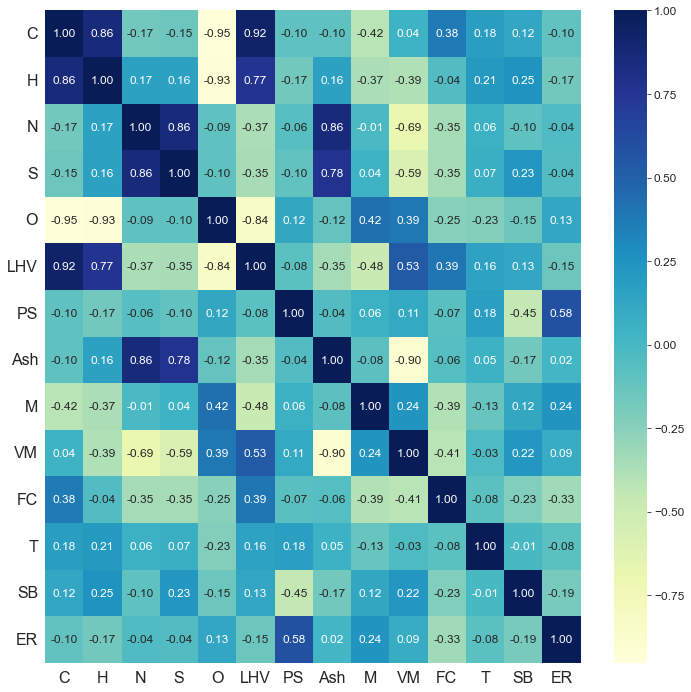

Show highly correlated values with an absolute value greater than 0.6 only


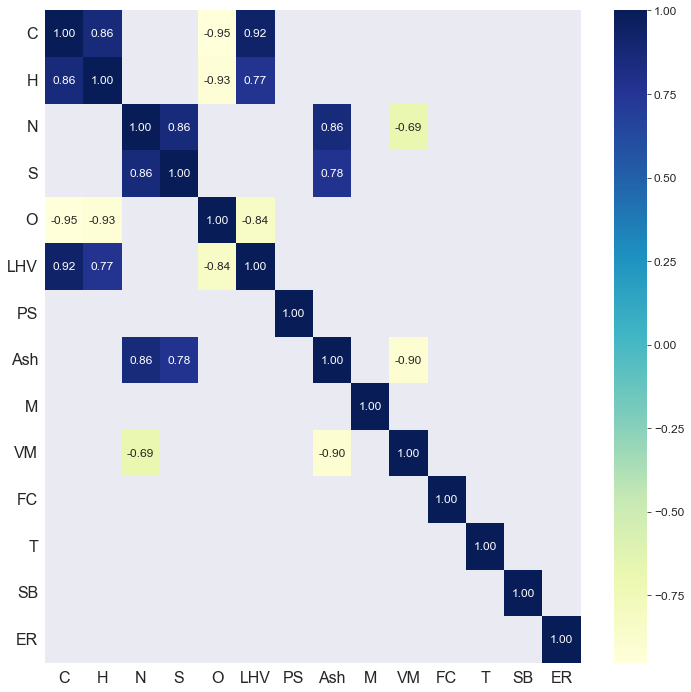


 Spearman correlation coefficient for continous predictor variables


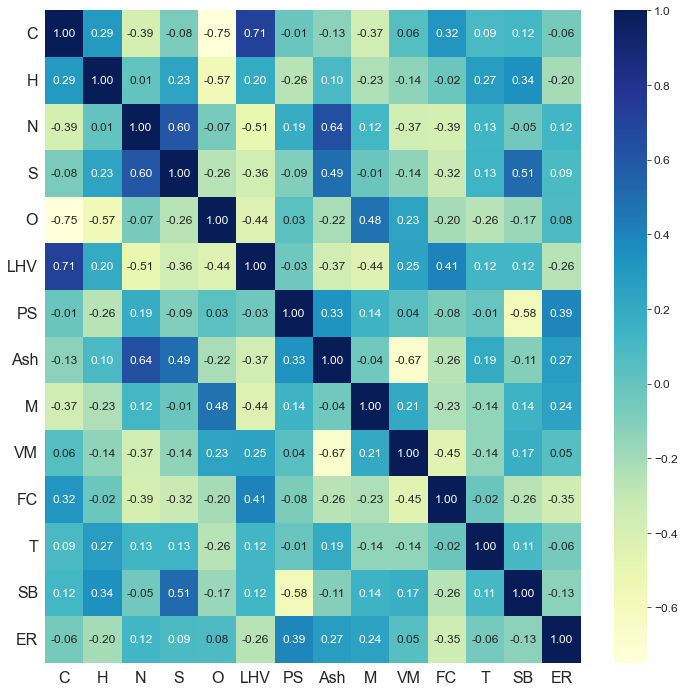

Show highly correlated values with an absolute value greater than 0.6 only


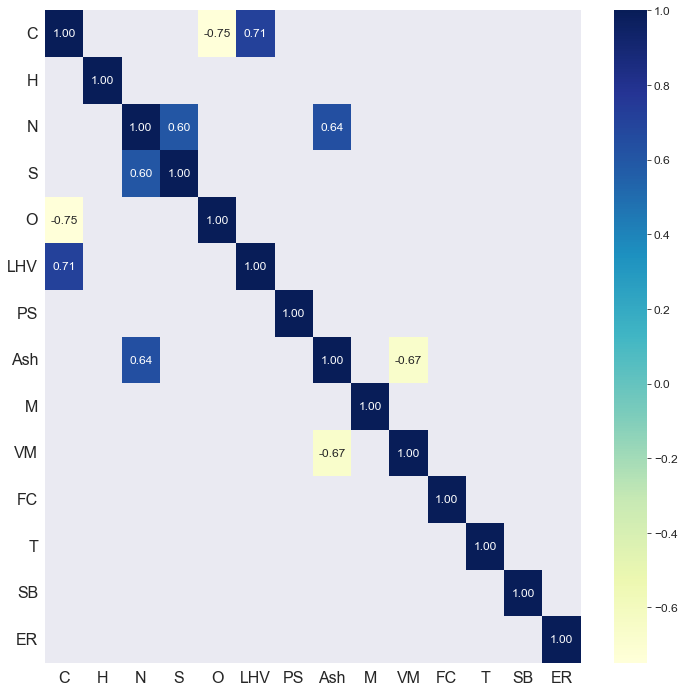

In [13]:
# Plot correlation between continous predictor variables

# Show Pearson correlation coefficients matrix

plt.rcParams.update({'font.size': 12})
rotation_angle = 0

print('Pearson correlation coefficient for continous predictor variables') # to avoid adding titles to figure
plt.figure(figsize=(12,12))
sns.heatmap(df_pred_cont.corr(method='pearson'), annot=True, cmap="YlGnBu", fmt=".2f")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.show()

# Repeat figure but this time show highly correlated factors ONLY
print('Show highly correlated values with an absolute value greater than {0} only'.format(pearson_corr_threshold))
plt.figure(figsize=(12,12))
pred_pearson_corr = df_pred_cont.corr(method='pearson')
sns.heatmap(pred_pearson_corr[abs(pred_pearson_corr)>=pearson_corr_threshold], annot=True, cmap="YlGnBu", fmt=".2f")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.show()

# Also show spearman correlation coefficients matrix
print('\n Spearman correlation coefficient for continous predictor variables') # to avoid adding titles to figure
plt.figure(figsize=(12,12))
sns.heatmap(df_pred_cont.corr(method='spearman'), annot=True, cmap="YlGnBu", fmt=".2f")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.savefig('figures\Spearman Correlation Matrices\Spearman_Correlation_Coefficient_Matrix.png', dpi=500)
plt.show()

# Repeat figure but this time show highly correlated factors ONLY
print('Show highly correlated values with an absolute value greater than {0} only'.format(spearman_corr_threshold))
plt.figure(figsize=(12,12))
pred_spearman_corr = df_pred_cont.corr(method='spearman')
sns.heatmap(pred_spearman_corr[abs(pred_spearman_corr)>=spearman_corr_threshold], annot=True, cmap="YlGnBu", fmt=".2f")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.savefig('figures\Spearman Correlation Matrices\Spearman_Correlation_Coefficient_Matrix_HighOnly.png', dpi=500)
plt.show()

#### Conclusions drawn from the predictor variables' correlation coefficients:

##### The following predictor variables have high correlations:

C - O, LHV <br>
N - S, Ash <br>
S - N <br>
O - C <br>
LHV - C <br>
Ash - N, VM <br>
VM - Ash <br>

This lead to the subsequent removal of the following factors: N, O, LHV <br>
Furthermore, VM and FC are removed as they are considered dependent factors in the literature.

---

#### 2.1.1) Show scatter plots of some of the most correlated features
---

Correlation between the feedstocks C and H content:


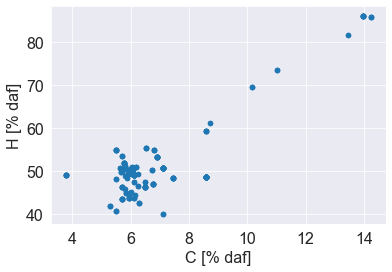

Correlation between the feedstocks C and H content and its LHV:


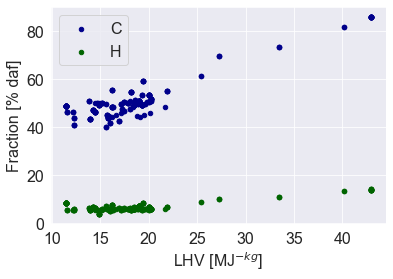

Correlation between the feedstocks S and N content


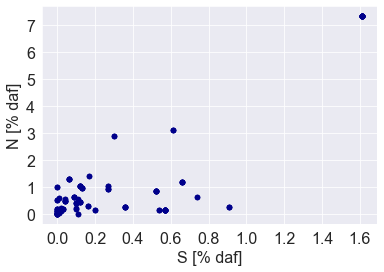

Correlation between the feedstocks S and N content, its volatile matter and its ash content:


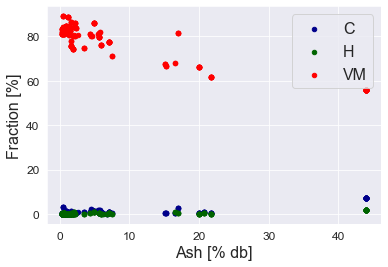

In [14]:
# Correlation between H and C
print('Correlation between the feedstocks C and H content:')
ax1 = df_pred_cont.plot.scatter(x='H', y='C')
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('C [% daf]',fontsize= 16, fontname = 'Arial')
plt.ylabel('H [% daf]',fontsize= 16, fontname = 'Arial')
plt.show()

# Parameters correlated to feedstock LHV
print('Correlation between the feedstocks C and H content and its LHV:')
ax2 = df_pred_cont.plot.scatter(x='LHV', y='C', color = 'DarkBlue', label ='C')
df_pred_cont.plot.scatter(x='LHV', y='H', color = 'DarkGreen', label ='H', ax=ax2)
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel(r'LHV [MJ$^{-kg}$]',fontsize= 16, fontname = 'Arial')
plt.ylabel('Fraction [% daf]',fontsize= 16, fontname = 'Arial')
plt.legend(['C','H'],fontsize= 16)
plt.show()

# Correlation between S and N
print('Correlation between the feedstocks S and N content')
ax3 = df_pred_cont.plot.scatter(x='S', y='N', color = 'DarkBlue')
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('S [% daf]',fontsize= 16, fontname = 'Arial')
plt.ylabel('N [% daf]',fontsize= 16, fontname = 'Arial')
plt.show()

# Parameters correlated to Ash content
print('Correlation between the feedstocks S and N content, its volatile matter and its ash content:')
ax4 = df_pred_cont.plot.scatter(x='Ash', y='N', color = 'DarkBlue', label ='C')
df_pred_cont.plot.scatter(x='Ash', y='S', color = 'DarkGreen', label ='H', ax=ax4)
df_pred_cont.plot.scatter(x='Ash', y='VM', color = 'Red', label ='VM', ax=ax4)
plt.xlabel('Ash [% db]',fontsize= 16, fontname = 'Arial')
plt.ylabel('Fraction [%]',fontsize= 16, fontname = 'Arial')
plt.legend(['C','H', 'VM'],fontsize= 16)
plt.show()

### 2.2) Target variables

Pearson correlation coefficient for target variables


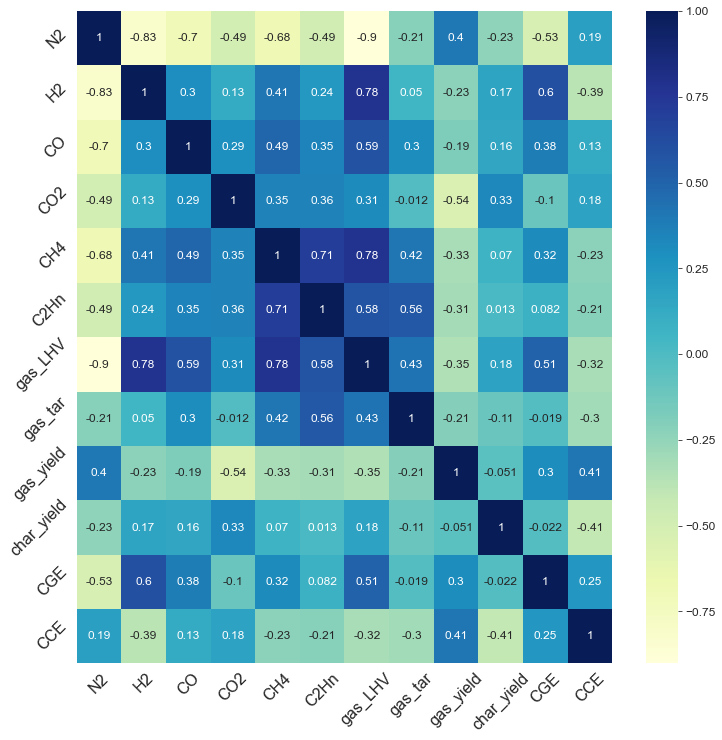

Show highly correlated values with an absolute value greater than 0.6 only


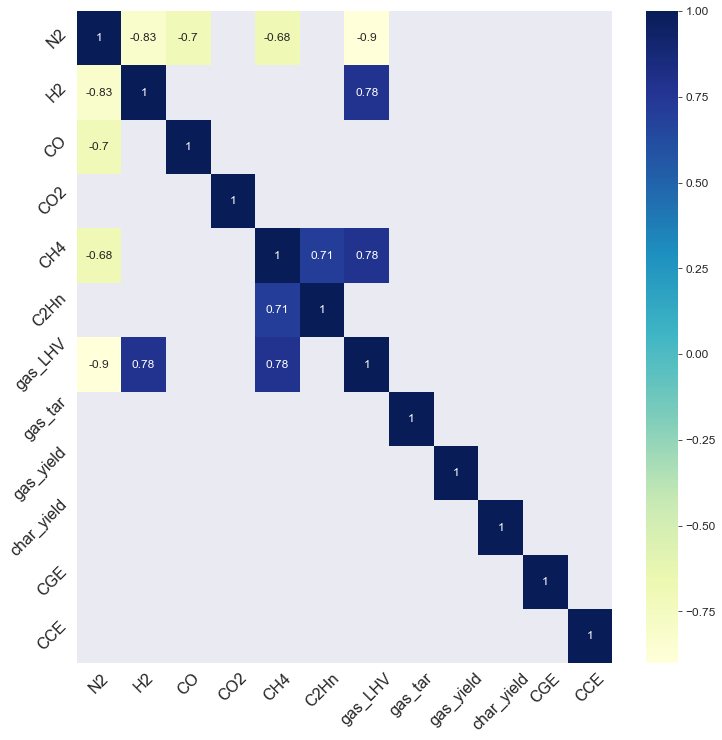


 Spearman correlation coefficient for target variables


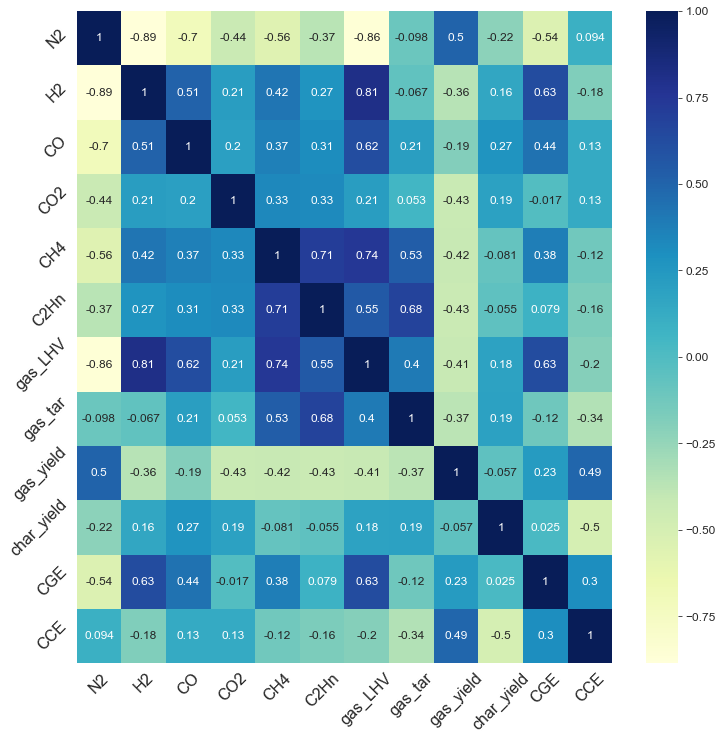

Show highly correlated values with an absolute value greater than 0.6 only


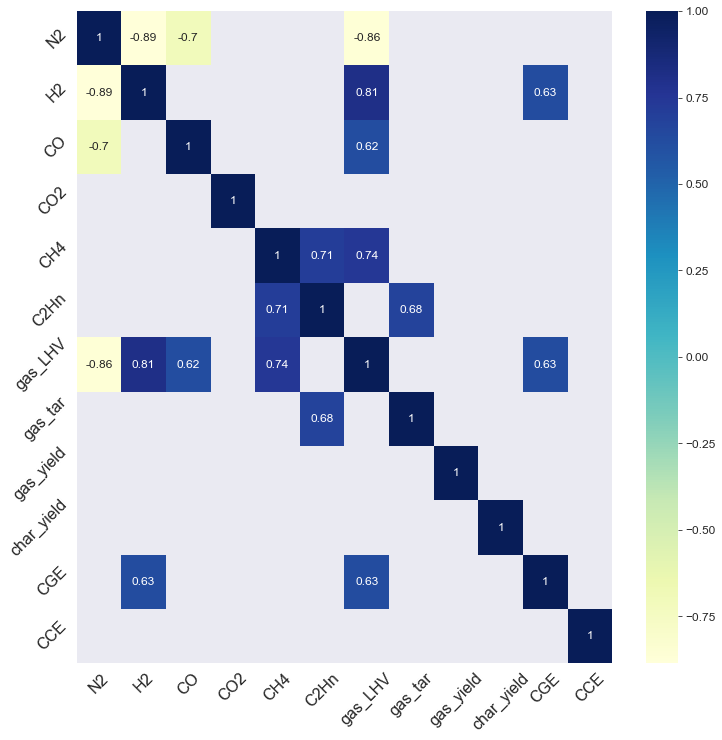

In [15]:
# Plot correlation between target variables

rotation_angle = 45
# Show Pearson correlation coefficients matrix
print('Pearson correlation coefficient for target variables') # to avoid adding titles to figure
plt.figure(figsize=(12,12))
sns.heatmap(df_tar.corr(method='pearson'), annot=True, cmap="YlGnBu")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.show()

# repeat figure but this time show highly correlated factors ONLY
print('Show highly correlated values with an absolute value greater than {0} only'.format(pearson_corr_threshold))
plt.figure(figsize=(12,12))
tar_pearson_corr = df_tar.corr(method='pearson')
sns.heatmap(tar_pearson_corr[abs(tar_pearson_corr)>=pearson_corr_threshold], annot=True, cmap="YlGnBu")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.show()

# Also show spearman correlation coefficients matrix
print('\n Spearman correlation coefficient for target variables')
plt.figure(figsize=(12,12))
sns.heatmap(df_tar.corr(method='spearman'), annot=True, cmap="YlGnBu")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.show()

# repeat figure but this time show highly correlated factors ONLY
print('Show highly correlated values with an absolute value greater than {0} only'.format(spearman_corr_threshold))
plt.figure(figsize=(12,12))
tar_spearman_corr = df_tar.corr(method='spearman')
sns.heatmap(tar_spearman_corr[abs(tar_spearman_corr)>=spearman_corr_threshold], annot=True, cmap="YlGnBu")
plt.xticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = rotation_angle, fontsize= 16, fontname = "Arial")
plt.show()


#### Conclusions drawn from the target variables' correlation coefficients: 

##### The following targets have high correlations:

N2 - H2, CO, LHV <br>
H2 - N2, LHV, CGE <br>
CO - N2, LHV <br>
CH4 - C2Hn, LHV <br>
C2Hn - CH4, Tar <br>
LHV - N2, H2, CO, CH4, CGE <br>
gas_tar - C2Hn <br>
CGE - H2, LHV <br>

Many target variables are found to be correlated. However, the linear relationships between these variables are not strong enough to justify the deletion of any target variables. <br>
However, CGE and CCE are removed as they were often calculated from other targets

---

#### 2.2.1) Show scatter plots of some of the most correlated features
---

Correlation between the syngas LHV and various gas fractions


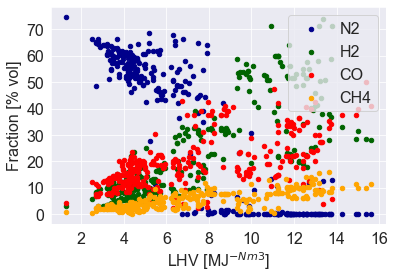

Correlation between the syngas N2 content and its H2 and CO content


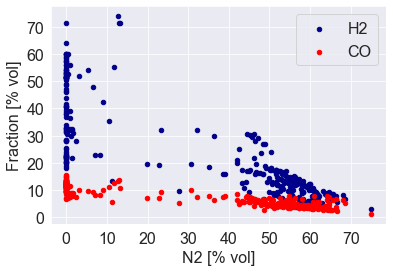

In [16]:
# Parameters correlated to LHV
print('Correlation between the syngas LHV and various gas fractions')
ax1 = df_tar.plot.scatter(x='gas_LHV', y='N2', color = 'DarkBlue', label ='N2')
df_tar.plot.scatter(x='gas_LHV', y='H2', color = 'DarkGreen', label ='H2', ax=ax1)
df_tar.plot.scatter(x='gas_LHV', y='CO', color = 'Red', label ='CO', ax=ax1)
df_tar.plot.scatter(x='gas_LHV', y='CH4', color = 'Orange', label ='CH4', ax=ax1)
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel(r'LHV [MJ$^{-Nm3}$]',fontsize= 16, fontname = 'Arial')
plt.ylabel('Fraction [% vol]',fontsize= 16, fontname = 'Arial')
plt.legend(['N2','H2','CO','CH4'],fontsize= 16)
plt.show()

print('Correlation between the syngas N2 content and its H2 and CO content')
ax2 = df_tar.plot.scatter(x='N2', y='H2', color = 'DarkBlue', label ='H2')
df_tar.plot.scatter(x='N2', y='gas_LHV', color = 'Red', label ='LHV', ax=ax2)
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('N2 [% vol]',fontsize= 16, fontname = 'Arial')
plt.ylabel('Fraction [% vol]',fontsize= 16, fontname = 'Arial')
plt.legend(['H2','CO'],fontsize= 16)
plt.show()

### 2.3) Predictor vs. target variables

Pearson correlation coefficients:


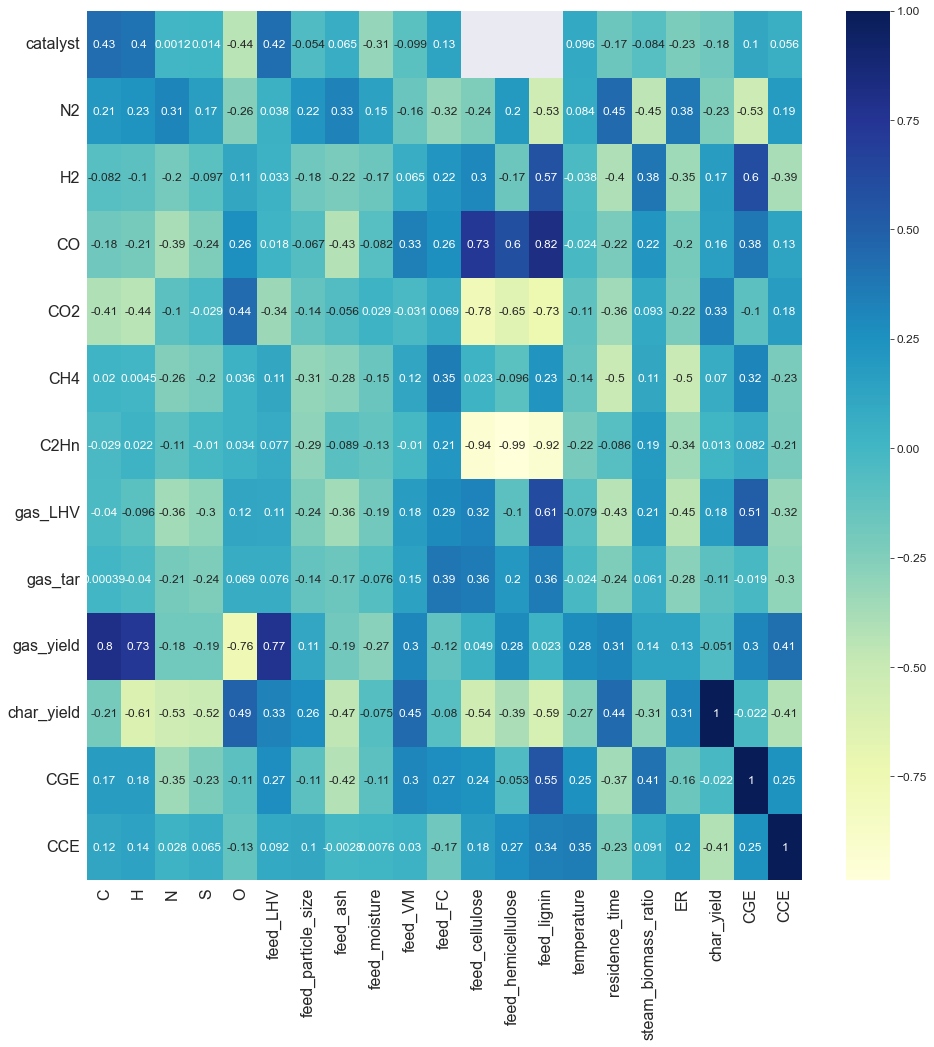

Show highly correlated values with an absolute value greater than 0.6 only:


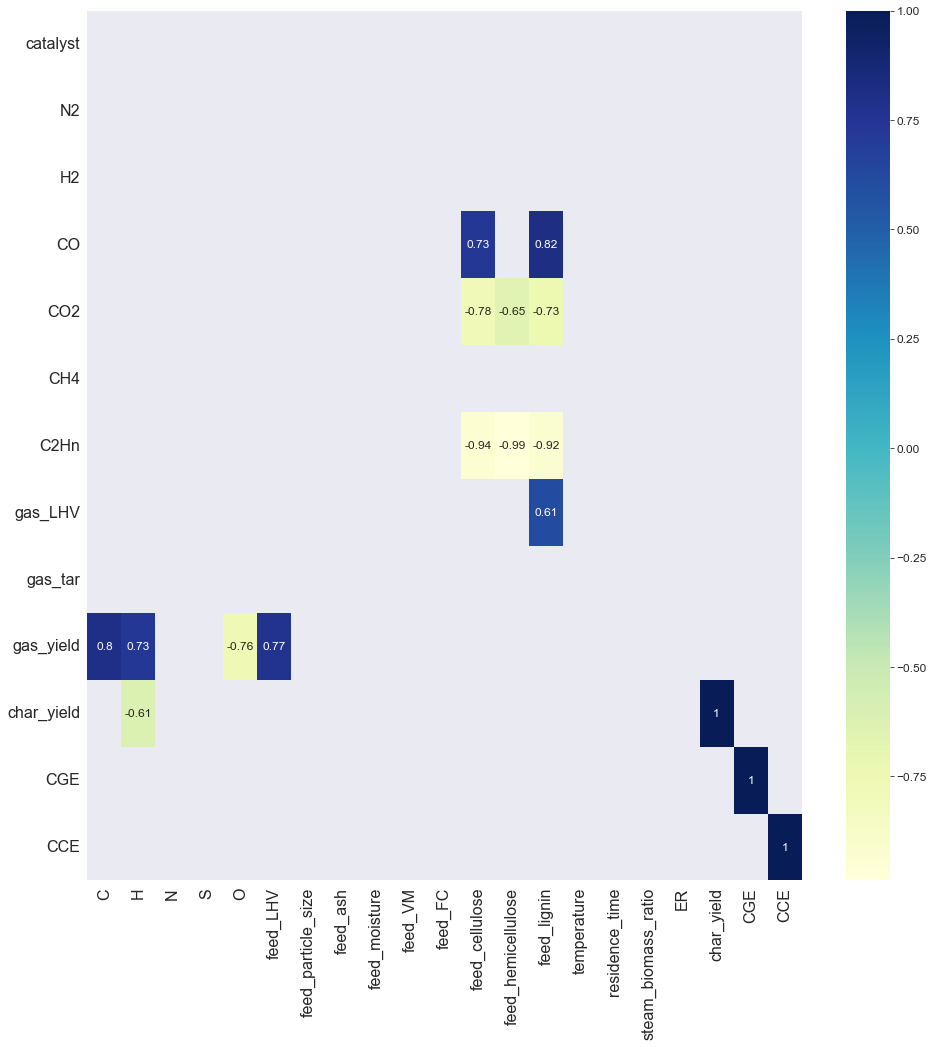

In [17]:
# Plot correlation between predictor and target variables

df_all = pd.concat([df_pred, df_tar],axis=1).copy() # combine predictor and target data frame

# calculate correlation matrix
corr_matrix = df_all.corr(method='pearson')
corr_matrix = corr_matrix.drop(corr_matrix.columns[0:19], axis = 1) # drop predictors from columns
corr_matrix = corr_matrix.drop(corr_matrix.index[19:29], axis = 0) # drop targets from rows
corr_matrix = corr_matrix.drop(corr_matrix.index[0], axis = 0) # drop index from rows
corr_matrix = corr_matrix.T

# Show Pearson correlation coefficients matrix
print('Pearson correlation coefficients:')
plt.figure(figsize=(16,16))
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.xticks(rotation = 90, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = 0, fontsize= 16, fontname = "Arial")
plt.show()

# Repeat figure but this time show highly correlated factors ONLY
print('Show highly correlated values with an absolute value greater than {0} only:'.format(pearson_corr_threshold))
plt.figure(figsize=(16,16))
sns.heatmap(corr_matrix[abs(corr_matrix)>=pearson_corr_threshold], annot=True, cmap="YlGnBu")
plt.xticks(rotation = 90, fontsize= 16, fontname = "Arial")
plt.yticks(rotation = 0, fontsize= 16, fontname = "Arial")
plt.show()


#### 2.3.1) Show scatter plots of some of the most correlated features
---

Correlation of target variables with the feedstocks cellulose, hemicellulose and lignin content are shown below:


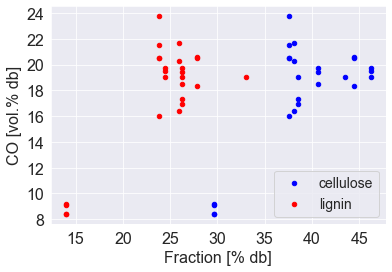

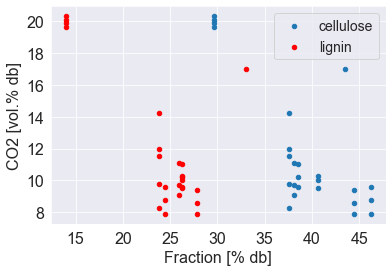

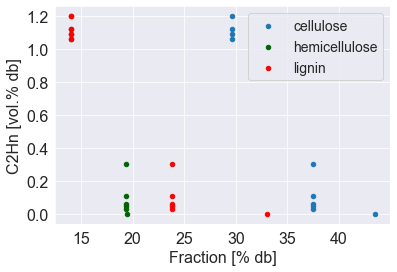

Correlation of the gas yield with the feedstocks composition and LHV:


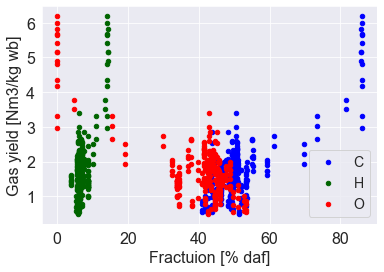

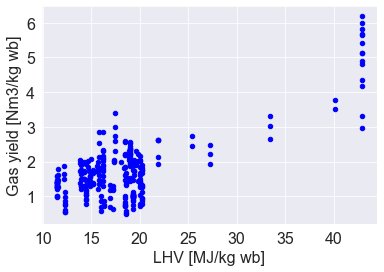

In [18]:
# Correlation between CO [vol.% db] and the feedstocks cellulose, hemicellulose and lignin content 
print('Correlation of target variables with the feedstocks cellulose, hemicellulose and lignin content are shown below:')
ax1 = df_all.plot.scatter(x='feed_cellulose', y='CO', color = 'Blue', label ='cellulose')
df_all.plot.scatter(x='feed_lignin', y='CO', color = 'Red', label ='lignin', ax=ax1)
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('Fraction [% db]',fontsize= 16, fontname = 'Arial')
plt.ylabel('CO [vol.% db]',fontsize= 16, fontname = 'Arial')
plt.legend(fontsize= 14)
plt.show()

# Correlation between CO2 [vol.% db] and the feedstocks cellulose, hemicellulose and lignin content 
ax2 = df_all.plot.scatter(x='feed_cellulose', y='CO2', label ='cellulose')
df_all.plot.scatter(x='feed_lignin', y='CO2', color = 'Red', label ='lignin', ax=ax2)
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('Fraction [% db]',fontsize= 16, fontname = 'Arial')
plt.ylabel('CO2 [vol.% db]',fontsize= 16, fontname = 'Arial')
plt.legend(fontsize= 14)
plt.show()

# Correlation between C2Hn [vol.% db] and the feedstocks cellulose, hemicellulose and lignin content 
ax3 = df_all.plot.scatter(x='feed_cellulose', y='C2Hn', label ='cellulose')
df_all.plot.scatter(x='feed_hemicellulose', y='C2Hn', color = 'DarkGreen', label ='hemicellulose', ax=ax3)
df_all.plot.scatter(x='feed_lignin', y='C2Hn', color = 'Red', label ='lignin', ax=ax3)
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('Fraction [% db]',fontsize= 16, fontname = 'Arial')
plt.ylabel('C2Hn [vol.% db]',fontsize= 16, fontname = 'Arial')
plt.legend(fontsize= 14)
plt.show()

# Correlation between Gas yield [Nm3/kg wb] and the feedstocks composition
print('Correlation of the gas yield with the feedstocks composition and LHV:')
ax4 = df_all.plot.scatter(x='C', y='gas_yield', color = 'Blue', label ='C')
df_all.plot.scatter(x='H', y='gas_yield', color = 'DarkGreen', label ='H', ax=ax4)
df_all.plot.scatter(x='O', y='gas_yield', color = 'Red', label ='O', ax=ax4)

plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('Fractuion [% daf]',fontsize= 16, fontname = 'Arial')
plt.ylabel('Gas yield [Nm3/kg wb]',fontsize= 16, fontname = 'Arial')
plt.legend(fontsize= 14)
plt.show()

ax5 = df_all.plot.scatter(x='feed_LHV', y='gas_yield', color = 'Blue')
plt.xticks(fontsize= 16, fontname = 'Arial')
plt.yticks(fontsize= 16, fontname = 'Arial')
plt.xlabel('LHV [MJ/kg wb]',fontsize= 16, fontname = 'Arial')
plt.ylabel('Gas yield [Nm3/kg wb]',fontsize= 16, fontname = 'Arial')
plt.show()

#### Conclusions drawn from the correlation coefficents and scatter plots showing predictors vs targets:

##### Gas yield was found to have a strong linear correlation with the feedstock's elemental composition and LHV.

Feedstock cellulose, hemicellulose, and lignin are the only other predictors showing a strong linear relationship with some of the target variables. However, these variables have a high number of missing parameters and hence are not considered in the model.

No other predictors were found to have a strong linear correlation with any of the other outputs - this again highlights the importance of a model suitable for non-linear data.

---

# 3.) Data preprocessing and preperation
The effects of various data preprocessing and preperation methods is studied. For instance the effect of adding categorical variables to improve the model's prediction is studied.

###### Predictor data:
The following methods are considered for predictor data (test and train).<br>

Use continuous variables only:<br>
1) Drop row if missing value is present
2) Mean impute missing values

Add categorical variables:<br>

3) Drop row if missing value is present and add categorical variables 
4) Mean impute missing values and add categorical variables

<br>


###### Target data:
Target data is only processed for the training set. If missing values are present in the test set a prediction  will not be made. The following methods are considered for the training data:<br>
1) Drop row if missing value is present
2) Mean impute missing values
3) Impute missing values using random forest submodel


---

### 3.1) Preprocessing and preparation of predictor data
Predictor data is being preprocessed to prepare for model training. Categorical variables are encoded using ordinal and one-hot encoding and instances of NaN or missing parameters in dataset are fixed.

---

In [19]:
# Define common parameters
random_state = 42

In [20]:
# Drop unrequired predictors and show data set
df_pred_dropped = df_pred.drop(['ID','feed_type','N','O','feed_LHV','feed_VM','feed_FC','feed_shape','feed_cellulose','feed_hemicellulose',
                              'feed_lignin','operating_pressure','residence_time'], axis=1).copy()

# Update predictor variable names 
df_pred_dropped.columns = ['C [%daf]','H [%daf]','S [%daf]','Particle size [mm]','Ash [%db]','Moisture [%wb]',
                        'Temperature [°C]','Operation (Batch/Continuous)','Steam/Biomass [wt/wt]','ER',
                        'Gasifying agent','Reactor type','Bed material','Catalyst','Scale']

df_pred_dropped

C [%daf]  H [%daf]  S [%daf]  Particle size [mm]  Ash [%db]  \
0       59.39      8.57      0.27                5.00      20.69   
1       59.39      8.57      0.27                5.00      20.69   
2       59.39      8.57      0.27                5.00      20.69   
3       59.39      8.57      0.27                5.00      20.69   
4       59.39      8.57      0.27                5.00      20.69   
..        ...       ...       ...                 ...        ...   
307     51.30      5.81      0.10                 NaN       0.43   
308     51.30      5.81      0.10                 NaN       0.43   
309     48.30      5.50      0.01               15.00       7.50   
310     48.30      5.50      0.01               15.00       7.50   
311     48.30      5.50      0.01               15.00       7.50   

     Moisture [%wb]  Temperature [°C] Operation (Batch/Continuous)  \
0              6.40            849.00                   continuous   
1              6.40            852.00                   continuous   
2              6.40            869.00                   continuous   
3              6.40            879.00                   continuous   
4              6.40            898.00                   continuous   
..              ...               ...                          ...   
307            8.00            750.00                   continuous   
308            8.00            800.00                   continuous   
309            0.00            850.00                   continuous   
310            0.00            850.00                   continuous   
311            0.00            850.00                   continuous   

     Steam/Biomass [wt/wt]   ER Gasifying agent   Reactor type Bed material  \
0                      NaN 0.26             air  fluidised bed      olivine   
1                      NaN 0.26             air  fluidised bed      olivine   
2                      NaN 0.27             air  fluidised bed      olivine   
3                      NaN 0.30             air  fluidised bed      olivine   
4                      NaN 0.32             air  fluidised bed      olivine   
..                     ...  ...             ...            ...          ...   
307                    NaN  NaN           steam  fluidised bed       silica   
308                    NaN  NaN           steam  fluidised bed       silica   
309                   0.60  NaN           steam          other          NaN   
310                   0.70  NaN           steam          other          NaN   
311                   1.00  NaN           steam          other          NaN   

     Catalyst  Scale  
0           1  pilot  
1           1  pilot  
2           1  pilot  
3           1  pilot  
4           1  pilot  
..        ...    ...  
307         0  pilot  
308         0  pilot  
309         0  pilot  
310         0  pilot  
311         0  pilot  

[312 rows x 15 columns]

In [21]:
# Display data types of predictor variables
print('Data types in  data frame: \n',df_pred_dropped.dtypes)

Data types in  data frame: 
 C [%daf]                        float64
H [%daf]                        float64
S [%daf]                        float64
Particle size [mm]              float64
Ash [%db]                       float64
Moisture [%wb]                  float64
Temperature [°C]                float64
Operation (Batch/Continuous)     object
Steam/Biomass [wt/wt]           float64
ER                              float64
Gasifying agent                  object
Reactor type                     object
Bed material                     object
Catalyst                          int64
Scale                            object
dtype: object


In [22]:
# Show number of NaN/missing values in each column
df_pred_dropped.isna().sum()

C [%daf]                          0
H [%daf]                          0
S [%daf]                         33
Particle size [mm]               42
Ash [%db]                         0
Moisture [%wb]                    0
Temperature [°C]                  0
Operation (Batch/Continuous)     10
Steam/Biomass [wt/wt]           179
ER                               77
Gasifying agent                   0
Reactor type                      0
Bed material                     78
Catalyst                          0
Scale                             0
dtype: int64

In [23]:
# Drop "Steam/Biomass [wt/wt]" as there is too many missing values
if 'Steam/Biomass [wt/wt]' in df_pred_dropped.columns: # ensures code does not break if the cell is run twice
    df_pred_dropped = df_pred_dropped.drop(['Steam/Biomass [wt/wt]'], axis=1) 

# Show categories/values of categorical predictors
print('Categories/values of categorical predictors:') 
print('Categories of "Operation (Batch/Continuous)" are:', df_pred_dropped['Operation (Batch/Continuous)'].unique())
print('Categories of "Reactor type" are:',df_pred_dropped['Reactor type'].unique())
print('Categories of "Bed material" are:',df_pred_dropped['Bed material'].unique())
print('Categories of "Scale" are:',df_pred_dropped['Scale'].unique(),'\n')

# Show number of NaN in Operation Mode column
print('Instances of NaN in "Operation (Batch/Continuous)" column:', sum(pd.isna(df_pred_dropped['Operation (Batch/Continuous)'])))
print('For comparison, the number of instances of the two categories are shown for:')
print(df_pred_dropped.groupby(['Operation (Batch/Continuous)']).size(),'\n')

# Fix missing values in the form of NaN in "Operation (Batch/Continuous)" colum before ordinally encoding.
# Since few values are missing and continuous is dominant fill them with the most frequent category (i.e. continuous):
df_pred_preprocessed = df_pred_dropped.copy() # create new data frame with preprocessed predictors - make sure it is a copy not a reference to original one
df_pred_preprocessed['Operation (Batch/Continuous)'] = df_pred_preprocessed['Operation (Batch/Continuous)'].fillna(df_pred_preprocessed['Operation (Batch/Continuous)'].mode().iloc[0])
print('Updated categories of "Operation (Batch/Continuous)" are:', df_pred_preprocessed['Operation (Batch/Continuous)'].unique())

# Ordinally encode Operation Mode and System Scale as they only have 2 categories 
encoder_ordinal = OrdinalEncoder()
df_pred_preprocessed[['Operation (Batch/Continuous)', 'Scale']] = encoder_ordinal.fit_transform(df_pred_preprocessed[['Operation (Batch/Continuous)', 'Scale']])
# Show encoded categories 
print('New categories of "Operation (Batch/Continuous)" are:', df_pred_preprocessed['Operation (Batch/Continuous)'].unique())
print('New categories of "Scale" are:',df_pred_preprocessed['Scale'].unique(), '\n')


Categories/values of categorical predictors:
Categories of "Operation (Batch/Continuous)" are: ['continuous' 'batch' nan]
Categories of "Reactor type" are: ['fluidised bed' 'fixed bed' 'other']
Categories of "Bed material" are: ['olivine' 'silica' 'dolomite' nan 'alumina' 'calcium oxide']
Categories of "Scale" are: ['pilot' 'lab'] 

Instances of NaN in "Operation (Batch/Continuous)" column: 10
For comparison, the number of instances of the two categories are shown for:
Operation (Batch/Continuous)
batch          24
continuous    278
dtype: int64 

Updated categories of "Operation (Batch/Continuous)" are: ['continuous' 'batch']
New categories of "Operation (Batch/Continuous)" are: [1. 0.]
New categories of "Scale" are: [1. 0.] 



In [24]:
# Check and preprocess categorical predictors with more than 2 categories before One Hot encoding

# Preprocess bed material column as missing values are present

# Show categories in "Bed material" column before preprocessing
print('Categories in "Bed material" column before preprocessing:')
print(df_pred_dropped['Bed material'].value_counts(),'\n')

# Turn categories with very few instances into category "other"
df_pred_preprocessed['Bed material'] = df_pred_preprocessed['Bed material'].replace({'calcium oxide':'other', 'dolomite':'other'})

# Turn NaN into not applicable (n/a) as these represent fixed bed gasifiers 
df_pred_preprocessed['Bed material'] = df_pred_preprocessed['Bed material'].fillna('N/A')

# Show updated values in Bed material's column
print('Updated categories in "Bed material" column after preprocessing:')
print(df_pred_preprocessed['Bed material'].value_counts(),'\n')

# Show categories in "Reactor type" and "Gasifying agent" column before One Hot encoding
print('Categories in "Reactor type" column:')
print(df_pred_dropped['Reactor type'].value_counts(),'\n')

print('Categories in "Gasifying agent" column:')
print(df_pred_dropped['Gasifying agent'].value_counts())


Categories in "Bed material" column before preprocessing:
silica           167
alumina           36
olivine           25
calcium oxide      4
dolomite           2
Name: Bed material, dtype: int64 

Updated categories in "Bed material" column after preprocessing:
silica     167
N/A         78
alumina     36
olivine     25
other        6
Name: Bed material, dtype: int64 

Categories in "Reactor type" column:
fluidised bed    234
fixed bed         75
other              3
Name: Reactor type, dtype: int64 

Categories in "Gasifying agent" column:
air            167
steam           76
air + steam     44
oxygen          18
other            7
Name: Gasifying agent, dtype: int64


In [25]:
# One Hot Encode 'Gasifying agent', 'Reactor type', and 'Bed material'
df_pred_encoded = pd.get_dummies(df_pred_preprocessed, columns=['Gasifying agent','Reactor type','Bed material',], prefix=['Agent','Reactor','Bed'])

# Show list of new column headers
list(df_pred_encoded.columns)

['C [%daf]',
 'H [%daf]',
 'S [%daf]',
 'Particle size [mm]',
 'Ash [%db]',
 'Moisture [%wb]',
 'Temperature [°C]',
 'Operation (Batch/Continuous)',
 'ER',
 'Catalyst',
 'Scale',
 'Agent_air',
 'Agent_air + steam',
 'Agent_other',
 'Agent_oxygen',
 'Agent_steam',
 'Reactor_fixed bed',
 'Reactor_fluidised bed',
 'Reactor_other',
 'Bed_N/A',
 'Bed_alumina',
 'Bed_olivine',
 'Bed_other',
 'Bed_silica']

##### Note:
Remaining pretreatment steps are done within model builder function.

---

### 3.2) Preprocessing and preparation of target data

---

In [26]:
# Display and check data types of target variables
print('Data types in  data frame:')
print(df_tar.dtypes)

Data types in  data frame:
N2            float64
H2            float64
CO            float64
CO2           float64
CH4           float64
C2Hn          float64
gas_LHV       float64
gas_tar       float64
gas_yield     float64
char_yield    float64
CGE           float64
CCE           float64
dtype: object


In [27]:
# Drop unrequired targets and show data set
if 'CGE' and 'CCE' in df_tar.columns: # ensures code does not break if the cell is run twice
    df_tar_encoded = df_tar.drop(['CGE','CCE'], axis=1).copy()
    
# Update target variable names 
df_tar_encoded.columns = ['N2 [vol.% db]','H2 [vol.% db]','CO [vol.% db]','CO2 [vol.% db]','CH4 [vol.% db]','C2Hn [vol.% db]',
                        'LHV [MJ/Nm3]','Tar [g/Nm3]','Gas yield [Nm3/kg wb]','Char yield [g/kg wb]']

df_tar_encoded # show updated dataframe


N2 [vol.% db]  H2 [vol.% db]  CO [vol.% db]  CO2 [vol.% db]  \
0            61.77           8.48           9.74           13.36   
1            60.64           7.11           8.98           15.69   
2            61.67           8.44          10.47           12.28   
3            61.86           8.24          10.40           12.83   
4            60.66           7.08          12.73           14.04   
..             ...            ...            ...             ...   
307           0.00          25.00          40.00           16.00   
308           0.00          25.50          42.50           13.00   
309           0.00          40.40          24.10           21.70   
310           0.00          39.40          23.50           23.10   
311           0.00          52.20          22.10           19.50   

     CH4 [vol.% db]  C2Hn [vol.% db]  LHV [MJ/Nm3]  Tar [g/Nm3]  \
0              4.18             2.19          5.39        73.00   
1              4.20             2.72          5.65        47.00   
2              4.57             2.14          5.55        58.00   
3              4.35             2.05          5.16        39.00   
4              3.33             1.78          4.91         5.00   
..              ...              ...           ...          ...   
307           14.00              NaN         12.77        11.90   
308           13.50              NaN         12.96        10.40   
309           12.20             1.70         12.79          NaN   
310           11.30             2.70         12.88          NaN   
311            6.00             0.20         10.69          NaN   

     Gas yield [Nm3/kg wb]  Char yield [g/kg wb]  
0                     1.62                   NaN  
1                     1.73                   NaN  
2                     1.72                   NaN  
3                     1.91                   NaN  
4                     2.04                   NaN  
..                     ...                   ...  
307                   0.51                   NaN  
308                   0.59                   NaN  
309                   0.74                219.00  
310                   0.72                217.00  
311                   0.86                212.00  

[312 rows x 10 columns]

##### Note:
Remaining pretreatment steps are done within model builder function.

---

# 4) Model training and evaluation
Various machine learning methods and pretreatment options are compared here (Section 4.2).<br>
Hyperparameter optimisation is completed to find the best performing hyperparameter combinations for each model type (Section 4.3).<br>
Finally, a super learner ensemble model based on all previously optimised models is presented (Section 4.4).<br>

---

### 4.1) Define model builder function and required subfunctions
Functions used for all different model types are defined here.

---

In [28]:
# Define prerequisite functions used within model builder function:


# Define additional error measurements:

def MAPE(Y_actual,Y_Predicted):
    # Function to calculate mean absolute percentage error
    error_values = np.abs((Y_actual - Y_Predicted)/Y_actual)*100
    error_values = np.asarray(error_values)
    inf_mask = ~np.isfinite(error_values) # check for values which are infinity due to division by zero 
    #error_values[inf_mask == True] = 0 # can be used to avoid infinite values - however this is not really a valid assumption - as it would just assume perfect prediction accuracy for all the cases where the true value is zero
    mape = np.mean(error_values)
    
    return mape # in percent


def noise_var(Y_actual,Y_Predicted,samples, regressors):
    # Function to calculate the noise variance
    # Need to double check if this is the correct equation etc - currentlyt taken from: : https://towardsdatascience.com/what-to-do-when-your-model-has-a-non-normal-error-distribution-f7c3862e475f

    # noise variance is defined by: s^2 = RSS/(n-p)
    # question - which n should I use. Size of test set, size of entire data set? - do not use until that has been resolved
    RSS = np.sum((Y_actual - Y_Predicted)**2)
    n = samples
    p = regressors
    noise_variance = (RSS/(n-p))
    return RSS # note this corresponds to sigma squared not sigma (i.e.variance not standard deviation)


# Other functions:

def check_missing(data): 
    # Function to check data for missing values
    no_missing = pd.DataFrame(data).isnull().sum().sum() # calculate number of missing values in data
    return no_missing


In [29]:
# Create one function which can fit any of the considered models with an range of possible pretreatment options
def build_models(X, Y, predictor_pretreatment, target_pretreatment, modelname = 'RF', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = True):
    
    """
    Function to train and test 'N' models for 'N' output/target variables (i.e. one model is trained for each
        ouput variable).
    A number of different ML algorithms are supported and may be defined by the variable 'modelname'.
    
    Inputs:
    X - predictor data for model training and testing
    Y - target data for model training and testing(multiple target columns possible)
    predictor_pretreatment - specifies the predictor variable pretreatment option
    target_pretreatment - specifies the target variable pretreatment option
    modelname - defines model type (default: 'RF')
    random_state - defines random seed (default: 42)
    CV_folds - define number of cross validation folds (default: 5)
    optimisation - specifies whether hyperparameter tuning is desired or default values are to be used (default: False)
    iterations_RandSearch - specifies the number of iterations for randomised grid search. Higher values cover more combinations but take longer to compute. Should
        be set to a higher value if number of combinations in optimisation grid is high (default: 100)
    display = If True graphs and description of model training are shown. If False these won't be shown (default: True)
    Output:
    performance_summary - pandas dataframe containing trained models, performance measures, and more
    """       
    
    # ---------------------------------------
    # 2.) Select which ML model is to be used and define grid/randomised search parameter grids for hyperparameter optimisation:
    # ---------------------------------------
    
    if modelname == 'RF': # Use sklearn's random forest regressor  
        model = RandomForestRegressor(random_state= random_state) 
        
        # Define grid/randomised search parameters
        max_depth = max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
        max_depth.append(None)
        
        param_grid = {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'max_features': ['auto', 'sqrt'],
        'max_depth': max_depth,
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        }
        
    elif modelname == 'GBR': # Use sklearn's gradient boosting regressor 
        model = GradientBoostingRegressor(random_state= random_state)
        
        # Define grid/randomised search parameters
        param_grid = {
        'loss': ['squared_error', 'absolute_error', 'huber'],
        'learning_rate': [0.02, 0.05, 0.10, 0.15, 0.20, 0.50],
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'subsample': [0.6, 0.8, 1.0],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_depth': [2, 3, 5, 10],
        'max_features': ['auto', 'sqrt', 0.3],
        }                
        
    elif modelname == 'XGBoost': # Use xgboost's extreme gradient boosting regressor 
        model = XGBRegressor(random_state=random_state)        
        
        param_grid = {
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],    
        'max_depth': [2, 5, 7, 10], 
        'eta': [0.01, 0.1, 0.3], 
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        }
        
        simplefilter('ignore', category=FutureWarning) # turn depreciation warnings off - required for versions of XGBoost ealier than 1.6

        
    elif modelname == 'AdaBoost': # Use sklearn's AdaBoost regressor
        model = AdaBoostRegressor(random_state= random_state)
                
        # Define grid/randomised search parameters
        base_estimator_depths = list() # define depth of decision tree stumps and base model
        for i in range(1,10,2):
            base_estimator_depths.insert(i, DecisionTreeRegressor(max_depth=i))
        
        param_grid = {
        'base_estimator': base_estimator_depths, 
        'n_estimators': [10, 50, 100, 200, 500, 1000, 2000],
        'learning_rate': [0.2, 0.5, 1, 1.5, 2, 5],
        'loss': ['linear', 'square', 'exponential']
        }
        
    elif modelname == 'SVM': # Use sklearn's support vector machine 
        model = make_pipeline(StandardScaler(), svm.SVR())
        
        if optimisation == True:
            print('Note: Optimisation currently not supported for SVM - change to "False" \n') 

            
    elif modelname == 'ANN': # Use sklearn's multi-layer perceptron
        model = make_pipeline(StandardScaler(),MLPRegressor(solver = 'lbfgs', random_state = random_state, early_stopping = True, max_iter = 1000))     
        
        param_grid = {
        'mlpregressor__hidden_layer_sizes': [int(x) for x in np.linspace(3, 15, num = 7)],  
        'mlpregressor__activation': ['logistic', 'tanh', 'relu'],
        'mlpregressor__solver': ['lbfgs', 'adam'], 
        'mlpregressor__early_stopping': [True, False],
        'mlpregressor__max_iter': [200, 500, 1000, 2000]
        }     
        
        simplefilter('ignore', category=ConvergenceWarning) # turn convergence warnings off


    else:
        print('Error: Model name not defined!')
    
    if display == True:
        print(modelname, 'model selected!\n') # show which model has been selected
        print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n') # to seperate model selection info from performance information
    
    if optimisation == True:
        parameter_combinations = len(ParameterGrid(param_grid))
        print('Total number of combinations in optimisation grid:', parameter_combinations,'\n') # show number of combinations in optimisation grid
        
        if iterations_RandSearch == 'auto': # Define number of iterations if 'auto' has been selected and no manual numerical input
            iterations_RandSearch = int(parameter_combinations * 0.25) # consider 25% of all possible parameter combinations in optimisation or at least 100
            if iterations_RandSearch < 100: # set minimum number of iterations to 100
                iterations_RandSearch = 100
                
            if iterations_RandSearch > 1000: # set maximum number of iterations to 1000
                iterations_RandSearch = 1000
                print('Random Search Iterations have been limited to 1000 \n')

                    
        print(iterations_RandSearch, 'combinations will be considered in search \n')
        
        if (iterations_RandSearch/parameter_combinations) < 0.10: # give warning if iterations_RandSearch was manually entered and is low 
            print('Warning: Only {:0.2f}% of grid combinations considered in Optimisation. Increase "iterations_RandSearch" or decrease parameter combinations in parameter grid \n'.format((iterations_RandSearch/parameter_combinations)*100))
                
        print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n') # to optimisation information from rest of model

    # ------------------------------------------
    # 2.5.) Split data into train and test sets:  
    # ------------------------------------------          
            
    test_fraction = 0.15 # define fraction used for testing
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_fraction, random_state= random_state) 
            
    # ----------------------------------------------------
    # 3.) Initialise performance matrix for storing values:  
    # ----------------------------------------------------    
    
    perf_sum = pd.DataFrame(index = ['R2_train', 'R2_test', 'RMSE_train', 'RMSE_test', 'MAPE_train', 'MAPE_test','R2_CV', 'RMSE_CV', 
                                                'size_train', 'size_test', 'best_parameters', 'model', 'predictor_pretreatment', 'target_pretreatment', 'no_predictors', 'gini', 'perm_imp_mean','perm_imp_std',
                                                'shap_train', 'shap_test', 'shap_compressed_train', 'shap_compressed_test', 'x_test', 'x_train', 'y_test', 'y_train', 'test_predictions', 'test_targets'] , columns = y_train.columns)   
    # ---------------------------------------------------
    # 4.) Create loop to iterate through output variables: 
    # ---------------------------------------------------
        
    for count, column in enumerate(np.arange(y_train.columns.shape[0])):
    # for count, column in enumerate(np.arange(1)): # quick execution for testing

        target_variable = y_train.columns[count] # select output parameter for which model is to be fitted
         

        
        # Initialise pretreated data frames
        X_train_pretreated = x_train.copy()
        X_test_pretreated = x_test.copy()
        Y_train_pretreated = y_train[target_variable].copy()        
        Y_test_pretreated = y_test[target_variable].copy()
        
        # Define name of categorical variables
        categorical_names = ['Operation (Batch/Continuous)', 'Catalyst', 'Scale', 'Agent_air', 'Agent_air + steam', 'Agent_other', 'Agent_oxygen', 'Agent_steam',
                             'Reactor_fixed bed', 'Reactor_fluidised bed', 'Reactor_other', 'Bed_alumina', 'Bed_N/A','Bed_olivine', 'Bed_other', 'Bed_silica']

        # Pretreat predictor variables:
        if predictor_pretreatment == 1: # Drop rows with missing values and remove non-continuous predictors
            # Training data
            X_train_dropped =  X_train_pretreated.drop(categorical_names, axis=1).copy() # drop non-continuous variables
            X_train_dropped = X_train_dropped.dropna(axis=0)
            X_train_dropped_mask = ~X_train_pretreated.isna().any(axis=1) # get mask to drop corresponding values from Y data frame - True to keep value, False to drop it
            Y_train_pretreated = Y_train_pretreated[X_train_dropped_mask] # drop corresponding rows in Y data frame         
            X_train_pretreated = X_train_dropped # update pretreated data frame
            
            # Test data
            X_test_dropped = X_test_pretreated.drop(categorical_names, axis=1).copy() # drop non-continuous variables
            X_test_dropped = X_test_dropped.dropna(axis=0)
            X_test_dropped_mask = ~X_test_pretreated.isna().any(axis=1) # get mask to drop corresponding values from Y data frame - True to keep value, False to drop it
            Y_test_pretreated = Y_test_pretreated[X_test_dropped_mask] # drop corresponding rows in Y data frame         
            X_test_pretreated = X_test_dropped # update pretreated data frame                         
        
        elif predictor_pretreatment == 2: # Mean impute missing values and remove non-continuous predictors
            # Training data
            X_train_dropped = X_train_pretreated.drop(categorical_names, axis=1).copy() # drop non-continuous variables           
            for column in X_train_dropped.columns[X_train_dropped.isnull().any()].tolist(): # go through list of missing column names 
                X_train_dropped[column] = X_train_dropped[column].fillna(X_train_dropped[column].mean()) # mean impute missing values
            X_train_pretreated = X_train_dropped # update dataframe
            
            # Test data
            X_test_dropped = X_test_pretreated.drop(categorical_names, axis=1).copy() # drop non-continuous variables
            for column in X_test_dropped.columns[X_test_dropped.isnull().any()].tolist(): # go through list of missing column names 
                X_test_dropped[column] = X_test_dropped[column].fillna(X_test_dropped[column].mean()) # mean impute missing values
            X_test_pretreated = X_test_dropped # update dataframe

        elif predictor_pretreatment == 3: # Drop rows with missing values and add categorical variables 
            # Training data
            X_train_dropped = X_train_pretreated.dropna(axis=0).copy()
            X_train_dropped_mask = ~X_train_pretreated.isna().any(axis=1) # get mask to drop corresponding values from Y data frame - True to keep value, False to drop it
            Y_train_pretreated = Y_train_pretreated[X_train_dropped_mask] # drop corresponding rows in Y data frame         
            X_train_pretreated = X_train_dropped # update pretreated data frame
            
            # Test data
            X_test_dropped = X_test_pretreated.dropna(axis=0).copy()
            X_test_dropped_mask = ~X_test_pretreated.isna().any(axis=1) # get mask to drop corresponding values from Y data frame - True to keep value, False to drop it
            Y_test_pretreated = Y_test_pretreated[X_test_dropped_mask] # drop corresponding rows in Y data frame         
            X_test_pretreated = X_test_dropped # update pretreated data frame                  
        
        elif predictor_pretreatment == 4: # Mean impute missing values and add categorical variables
            # Training data
            for column in X_train_pretreated.columns[X_train_pretreated.isnull().any()].tolist(): # go through list of missing column names 
                X_train_pretreated[column] = X_train_pretreated[column].fillna(X_train_pretreated[column].mean()) # mean impute missing values
            
            # Test data
            for column in X_test_pretreated.columns[X_test_pretreated.isnull().any()].tolist(): # go through list of missing column names 
                X_test_pretreated[column] = X_test_pretreated[column].fillna(X_test_pretreated[column].mean()) # mean impute missing values          
        
        elif predictor_pretreatment == 5: # KNN impute missing variables and add categorical variables
            # Training data
            KNN_imputer_train = KNNImputer(n_neighbors=3)
            X_train_pretreated = pd.DataFrame(KNN_imputer_train.fit_transform(X_train_pretreated))
            # Test data
            KNN_imputer_test = KNNImputer(n_neighbors=3)
            X_test_pretreated = pd.DataFrame(KNN_imputer_test.fit_transform(X_test_pretreated))
            # Note: Currently not working - Dataframe looks different to the way it is supposed to look after imputation - get in the same format as for the other methods
        else:
            print('Warning: Predictor pretreatment option invalid! Select an integer between 1 and 4 \n')           
            
            
        # Pretreat target variables: 
        if target_pretreatment == 1: # drop rows with missing values present 
            # Training data
            Y_train_dropped = Y_train_pretreated.dropna(axis=0)
            Y_train_dropped_mask = ~Y_train_pretreated.isna() # get mask to drop corresponding values from X data frame - True to keep value, False to drop it
            X_train_pretreated = X_train_pretreated[Y_train_dropped_mask] # drop corresponding rows in X data frame         
            Y_train_pretreated = Y_train_dropped # update pretreated data frame
  
        elif target_pretreatment == 2: # Mean impute missing values
            Y_train_pretreated = Y_train_pretreated.fillna(Y_train_pretreated.mean()) # mean impute missing values         
            
        elif target_pretreatment == 3: # Impute missing values using random forest submodel
            # Training data
            XY_temp = pd.concat([X_train_pretreated, X_test_pretreated]) # create dataframe with all inputs and considered target
            XY_temp[target_variable] = pd.concat([Y_train_pretreated, Y_test_pretreated]) # add target
            XY_temp = XY_temp.dropna() # drop all rows with missing values for model training
            
            # Create temporary data sets for model training and testing
            x_RF_temp = XY_temp.drop([target_variable], axis=1) 
            y_RF_temp = XY_temp[target_variable]
            
            # Create and fit model
            model_RF_temp = RandomForestRegressor(random_state = random_state)
            model_RF_temp.fit(x_RF_temp, y_RF_temp)
            
            # Make predictions and NaNs with predictions 
            imputer_predictions = pd.DataFrame(model_RF_temp.predict(X_train_pretreated))
            target_array= Y_train_pretreated.to_numpy().flatten() # extract target array with NaNs
            target_array[np.isnan(target_array)] = imputer_predictions.to_numpy().flatten()[np.isnan(target_array)] # replace NaNs with predictions
            updated_tar_name = target_variable + "_imputed"
            Y_train_pretreated = pd.DataFrame(target_array) # add output parameter to temporary data frame
            #Y_train_pretreated[updated_tar_name] = (target_array) # add output parameter to temporary data frame
            #Y_train_pretreated = Y_train_pretreated.drop([target_variable], axis=1) # drop old column
            Y_train_pretreated.columns = [target_variable] # rename updated column to old name   
            Y_train_pretreated = Y_train_pretreated.squeeze() # turn variable back into a pandas Series object
                    
        else:
            print('Warning: Target pretreatment option invalid!Select an integer between 1 and 3 \n')
        
        
        # Always treat target test data in the same way - i.e. do not make predicitons for missing values
        Y_test_dropped = Y_test_pretreated.dropna(axis=0)
        Y_test_dropped_mask = ~Y_test_pretreated.isna() # get mask to drop corresponding values from X data frame - True to keep value, False to drop it
        X_test_pretreated = X_test_pretreated[Y_test_dropped_mask] # drop corresponding rows in X data frame         
        Y_test_pretreated = Y_test_dropped # update pretreated data frame      

        
    # -------------------------------------------------------------------------------------------------------------------
    # 5.) Check for missing values in data and select training and testing data.   
    #     If missing values present - drop corresponding rows. Note: This should only be the case for missing target data
    #        in the test set as this should not be imputed/filled with any method. Flag warning if this is not the case. 
    # -------------------------------------------------------------------------------------------------------------------
            
        if check_missing(X_train_pretreated) != 0 or check_missing(Y_train_pretreated) != 0 or check_missing(X_test_pretreated) != 0:
            print('Warning: Missing values in x_train or x_test set. Missing values should only be present in y_test set')
        
        if modelname == 'XGBoost': # update column names for XGBoost Model - cannot handle "[]" in column names
            
            if predictor_pretreatment == 1 or predictor_pretreatment == 2:
                X_train_pretreated.columns = ['C', 'H', 'S', 'PS', 'Ash', 'Moisture', 'Temp', 'ER']
                X_test_pretreated.columns = ['C', 'H', 'S', 'PS', 'Ash', 'Moisture', 'Temp', 'ER']
            else:
                X_train_pretreated.columns = ['C', 'H', 'S', 'PS', 'Ash', 'Moisture', 'Temp', 'Operation', 'ER', 'Cat', 'Scale', 'agent_air',
                                 'agent_air_steam', 'agent_other', 'agent_oxygen', 'agent_steam', 'reactor_fixed bed',
                                 'reactor_fluidised bed', 'reactor_other', 'bed_alumina', 'bed_na',
                                 'bed_olivine', 'bed_other', 'bed_silica']
                X_test_pretreated.columns = ['C', 'H', 'S', 'PS', 'Ash', 'Moisture', 'Temp', 'Operation', 'ER', 'Cat', 'Scale', 'agent_air',
                                 'agent_air_steam', 'agent_other', 'agent_oxygen', 'agent_steam', 'reactor_fixed bed',
                                 'reactor_fluidised bed', 'reactor_other', 'bed_alumina', 'bed_na',
                                 'bed_olivine', 'bed_other', 'bed_silica']                

            Y_train_pretreated.columns = ['N2','H2','CO','CO2','CH4','C2Hn', 'LHV','Tar','Gas yield','Char yield']
            Y_test_pretreated.columns = ['N2','H2','CO','CO2','CH4','C2Hn', 'LHV','Tar','Gas yield','Char yield']
        
    # ------------------------------------------
    # 6.) Fit model and evaluate its performance: 
    # ------------------------------------------
        # Random search of parameters, using 3 fold cross validation, 
        # search across 100 different combinations, and use all available cores
        
        if optimisation == True:
            iterations_RandSearch = 10 # change back to 100 or go for proper grid search
            RandSearch_model = RandomizedSearchCV(estimator = model, param_distributions = param_grid, n_iter = iterations_RandSearch,
                                       cv = CV_folds, verbose=0, random_state=random_state)
            # Fit the random search model
            RandSearch_model.fit(X_train_pretreated, Y_train_pretreated)
            best_parameters = RandSearch_model.best_params_
            model = RandSearch_model.best_estimator_ # select best estimator as model for rest of code 
            
        else:
            # fit model and make predictions
            model.fit(X_train_pretreated, Y_train_pretreated)
            best_parameters = 'default' # note that default paramters have been used

        pickled_model = pickle.dumps(model)# create storable instance of model
        y_train_pred = model.predict(X_train_pretreated)
        y_test_pred = model.predict(X_test_pretreated)
        
        # Evaluate performance - other performance measures can be shown with sorted(sklearn.metrics.SCORERS.keys())
        
        # R2
        R2_train = model.score(X_train_pretreated, Y_train_pretreated)
        R2_test = model.score(X_test_pretreated, Y_test_pretreated)
        
        # RMSE
        RMSE_train = mean_squared_error(Y_train_pretreated, y_train_pred, squared=False)
        RMSE_test = mean_squared_error(Y_test_pretreated, y_test_pred, squared=False)
        
        # MAPE
        MAPE_train = MAPE(Y_train_pretreated, y_train_pred)
        MAPE_test = MAPE(Y_test_pretreated, y_test_pred)

        # Noise variance - Currently results in division by zero which causes warning to be displayed - code still works
        #sqrt_noise_var_train = np.sqrt(noise_var(y_train_ready, y_train_pred, len(x_train_ready), len(x_train_ready)))       
        #sqrt_noise_var_test = np.sqrt(noise_var(y_test_ready, y_test_pred, len(x_test_ready), len(x_train_ready)))
       
        # Evaluate cross validated performance on entire dataset
        
        # Combine datasets again before calculating cross validation scores
        x_complete = pd.concat([X_train_pretreated, X_test_pretreated])
        y_complete = pd.concat([Y_train_pretreated, Y_test_pretreated])
        
        # Calculate cross validated scores 
        CV_R2_scores = cross_val_score(model, x_complete, y_complete, cv=CV_folds, scoring='r2')
        R2_CV = np.mean(CV_R2_scores)
        CV_RMSE_scores = -cross_val_score(model, x_complete, y_complete, cv=CV_folds, scoring='neg_root_mean_squared_error')
        RMSE_CV = np.mean(CV_RMSE_scores)
        
    # ---------------------------------------------------------
    # 7.) Compute feature importances using a range of methods: 
    # ---------------------------------------------------------   
        if modelname == 'RF' or modelname == 'GBR' or modelname == 'XGBoost' or modelname == 'AdaBoost':
            # 1.) Gini importance:
            gini_importances = model.feature_importances_

            # 2.) Permutation importance
            perm_importances = permutation_importance(model, X_test_pretreated, Y_test_pretreated, n_repeats=30, random_state=random_state)      
            perm_importances_mean = np.abs(perm_importances.importances_mean)
            perm_importances_std = np.abs(perm_importances.importances_std)

            if modelname == 'RF' or modelname == 'GBR' or modelname == 'XGBoost': 
            # 3. SHAP importance
                shap_explainer = shap.TreeExplainer(model)
                shap_values_train = shap_explainer.shap_values(X_train_pretreated)
                shap_values_test = shap_explainer.shap_values(X_test_pretreated)
                
            elif modelname == 'AdaBoost':
                shap_values_train = 'not applicable for AdaBoost'
                shap_values_test = 'not applicable for AdaBoost'                
                
        elif modelname == 'SVM' or modelname == 'ANN': # feature importance not calculated for SVM or ANN
            gini_importances = 'not applicable for SVM or ANN'
            perm_importances_mean = 'not applicable for SVM or ANN'
            perm_importances_std = 'not applicable for SVM or ANN'
            shap_values_train = 'not applicable for SVM or ANN'
            shap_values_test = 'not applicable for SVM or ANN'
            
    # -------------------------------------------------------------------
    # 8.) Store performance indicators and other information in dataframe: 
    # -------------------------------------------------------------------    
        # Performance measure (R2, RMSE, etc)
        perf_sum.at['R2_train', target_variable] = R2_train
        perf_sum.at['R2_test', target_variable] = R2_test       
        perf_sum.at['RMSE_train', target_variable] = RMSE_train    
        perf_sum.at['RMSE_test', target_variable] = RMSE_test    
        perf_sum.at['R2_CV', target_variable] = R2_CV    
        perf_sum.at['RMSE_CV', target_variable] = RMSE_CV
        perf_sum.at['MAPE_train', target_variable] = MAPE_train
        perf_sum.at['MAPE_test', target_variable] = MAPE_test
        perf_sum.at['best_parameters', target_variable] = best_parameters
        #perf_sum.at['sqrt_noise_var_train', target_variable] = sqrt_noise_var_train
        #perf_sum.at['sqrt_noise_var_test', target_variable] = sqrt_noise_var_test
        
        # Model and other info
        perf_sum.at['model', target_variable] = pickled_model # unpickle to load model again
        perf_sum.at['predictor_pretreatment', target_variable] = predictor_pretreatment 
        perf_sum.at['target_pretreatment', target_variable] = target_pretreatment
        perf_sum.at['no_predictors', target_variable] = np.size(X_train_pretreated.columns)
        perf_sum.at['size_train', target_variable] = len(X_train_pretreated)
        perf_sum.at['size_test', target_variable] = len(X_test_pretreated)
        
        # Variable importance measures and related      
        perf_sum.at['gini', target_variable] = gini_importances   
        perf_sum.at['perm_imp_mean', target_variable] = perm_importances_mean
        perf_sum.at['perm_imp_std', target_variable] = perm_importances_std
        perf_sum.at['shap_train', target_variable] = shap_values_train
        perf_sum.at['shap_test', target_variable] = shap_values_test
        perf_sum.at['x_test', target_variable] = X_test_pretreated # required to create shap plots and superlearner
        perf_sum.at['x_train', target_variable] = X_train_pretreated # required to create shap plots and superlearner
        perf_sum.at['y_test', target_variable] = Y_test_pretreated # required for superlearner
        perf_sum.at['y_train', target_variable] = Y_train_pretreated # required for superlearner

        # Test prediction and true values
        perf_sum.at['test_predictions', target_variable] = y_test_pred   
        perf_sum.at['test_targets', target_variable] = Y_test_pretreated
                
    # ---------------------------------------------------
    # 9.) Display model performance and other information at runtime:
    # --------------------------------------------------- 
        if display == True: # Choose whether to display figures and performance of model
            # Predicted variable and sample size    
            print('Performance of model number %d for the output' %(count+1),target_variable, ':\n')
            print('Number of samples in training set: %.1f \t Number of sample in test set: %.1f \n' %(len(X_train_pretreated),len(X_test_pretreated)))

            # R2
            print('\t Train R2: %.3f \n' %(R2_train))
            print('\t Test R2: %.3f\n' %(R2_test))
            print('\t CV R2: %.3f (+/- %.3f) \n' %(R2_CV, CV_R2_scores.std()))       

            # RMSE 
            print('\t Train RMSE: %.3f \n' %(RMSE_train))
            print('\t Test RMSE: %.3f\n' %(RMSE_test))
            print('\t CV RMSE: %.3f (+/- %.3f) \n' %(RMSE_CV, CV_RMSE_scores.std()))
            # MAPE
            print('\t Test MAPE: %.3f\n' %(MAPE_test))

    # -------------------
    # 10.) Plot model fit:
    # ------------------- 
            x_labels = [r'Target $N_{2}$ [vol. % db]', 
                        r'Target $H_{2}$ [vol. % db]',
                        r'Target CO [vol. % db]',
                        r'Target $CO_{2}$ [vol. % db]',
                        r'Target $CH_{4}$ [vol. % db]',
                        r'Target $C_{2}H_{n}$ [vol. % db]',
                        r'Target LHV [MJ/$Nm^{3}$]',
                        r'Target Tar [g/$Nm^{3}$]',
                        r'Target Gas Yield [$Nm^{3}$/kg wb]',
                        r'Target Char Yield [g/kg wb]'
                       ]
            
            y_labels = [r'Predicted $N_{2}$ [vol. % db]', 
                        r'Predicted $H_{2}$ [vol. % db]',
                        r'Predicted CO [vol. % db]',
                        r'Predicted $CO_{2}$ [vol. % db]',
                        r'Predicted $CH_{4}$ [vol. % db]',
                        r'Predicted $C_{2}H_{n}$ [vol. % db]',
                        r'Predicted LHV [MJ/$Nm^{3}$]',
                        r'Predicted Tar [g/$Nm^{3}$]',
                        r'Predicted Gas Yield [$Nm^{3}$/kg wb]',
                        r'Predicted Char Yield [g/kg wb]'
                       ]
    
    
            target_axis_string = x_labels[count]
            predicted_axis_string = y_labels[count]
            g = sns.JointGrid(x=Y_test_pretreated, y=y_test_pred)
            g.fig.set_figwidth(5) # change fig width for publication
            g.fig.set_figheight(2.25) # change fig height for publication
            sns.scatterplot(x=Y_train_pretreated, y=y_train_pred, s=100, color='orange', ax=g.ax_joint)
            sns.scatterplot(x=Y_test_pretreated, y=y_test_pred, s=100, color='blue', ax=g.ax_joint)
            # sns.regplot(x=Y_test_pretreated, y=y_test_pred, ax=g.ax_joint)
            g.set_axis_labels(target_axis_string, predicted_axis_string, fontsize =16, fontname = 'Arial')
            sns.histplot(x=Y_train_pretreated,ax=g.ax_marg_x, color ='orange')
            sns.histplot(x=Y_test_pretreated, ax=g.ax_marg_x, color ='blue')
            g.ax_marg_x.legend(['Train', 'Test'])
            plt.show()
            fig = g.fig # get current seaborn axis as figure to save it
            fig.savefig(directory + '\Figures\\Scatter Plots\\' + modelname + '\\Scatter_target' + '_' + str(count + 1) + '.png', dpi=500, bbox_inches = 'tight')
                
    # --------------------------
    # 11.) Turn warnings back on:
    # --------------------------   
        simplefilter('default', category=FutureWarning) # turn depreciation warnings back on
        simplefilter('default', category=ConvergenceWarning) # turn convergence warnings back on    
    
    # ----------------------------------
    # 12.) Return outputs as a dataframe:
    # ----------------------------------
    
        if display == True:
            print ('# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # \n')
    
    return perf_sum       
        

### 4.2) Comparison of various pre-treatment options and their effect on the models' prediction accuracy

---

#### 4.2.1) Definition of shared functions

In [30]:
# Define function to compare performance of predictor and target pretreatment methods for different model types

def pre_treatment_comparison(X, Y, modelname = 'RF'):
    # Create dataframe to compare pretreatment options
    Pretreatment_comp = pd.DataFrame(columns=['predictor_pretreatment','target_pretreatment','CV_R2'])
    for count in np.arange((4*3)):
        # Select input paramter combinations
        if count <= 11:
            predictor_method = count - 7
            target_method = 3
        if count <= 7:
            predictor_method = count - 3
            target_method = 2
        if count <= 3:
            predictor_method = count + 1
            target_method = 1

        # Train models and extract performance summary
        model_performance_summary = build_models(X, Y, predictor_pretreatment = predictor_method, target_pretreatment = target_method, modelname = modelname,
                                                 random_state = 42, CV_folds = 5, optimisation = False, display = False)

        Pretreatment_comp.loc[count, 'predictor_pretreatment'] = model_performance_summary.loc['predictor_pretreatment'][0]
        Pretreatment_comp.loc[count, 'target_pretreatment'] = model_performance_summary.loc['target_pretreatment'][0]
        Pretreatment_comp.loc[count, 'CV_R2'] = np.mean(model_performance_summary.loc['R2_CV'])

    return Pretreatment_comp # return dataframe

# Define function to display most important performance metrics stored within a model performance summary dataframe


def disp_performance_metrics(model_performance_summary):
    # Where model_performance_summary specifies the performance summary data frame of the model we are interested in
    print('Results for predictor pretreatment option: {:0} and target pretreatment option: {:1} \n'.format(model_performance_summary.loc['predictor_pretreatment'][0], model_performance_summary.loc['target_pretreatment'][0]))
    print('Mean cross validated R2 value: {:0.3f} % \n'.format(np.mean(model_performance_summary.loc['R2_CV']))) # mean R2 value across all models
    

#### 4.2.2) Random Forest

---

In [31]:
RF_Pretreatment_comp = pre_treatment_comparison(df_pred_encoded, df_tar_encoded, modelname = 'RF') # calculate comparison results
RF_Pretreatment_comp # display dataframe

predictor_pretreatment target_pretreatment CV_R2
0                       1                   1  0.73
1                       2                   1  0.75
2                       3                   1  0.81
3                       4                   1  0.82
4                       1                   2  0.75
5                       2                   2  0.74
6                       3                   2  0.83
7                       4                   2  0.81
8                       1                   3  0.78
9                       2                   3  0.79
10                      3                   3  0.86
11                      4                   3  0.84

##### The optimisation showed that the following methods resulted in the best cross-validated model performance:
Predictor pretreatment method: 3 (i.e. Drop row if missing value is present and add categorical variables) <br>
Target pretreatment method: 3 (i.e. Impute missing values in training data using random forest submodel) <br>
<br>
Use these pretreatment options to find the best performing model type with randomised gridsearch optmisation<br>


In [32]:
# Show performance of model with highest cross validated R2
RF_performance_summary = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'RF', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = False)

disp_performance_metrics(RF_performance_summary)

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.859 % 



#### 4.2.3) Sklearn Gradient Boosting

---

In [33]:
GBR_Pretreatment_comp = pre_treatment_comparison(df_pred_encoded, df_tar_encoded, modelname = 'GBR') # calculate comparison results
GBR_Pretreatment_comp # display dataframe

predictor_pretreatment target_pretreatment CV_R2
0                       1                   1  0.73
1                       2                   1  0.73
2                       3                   1  0.84
3                       4                   1  0.81
4                       1                   2  0.72
5                       2                   2  0.70
6                       3                   2  0.84
7                       4                   2  0.81
8                       1                   3  0.74
9                       2                   3  0.77
10                      3                   3  0.87
11                      4                   3  0.84

##### The optimisation showed that the following methods resulted in the best cross-validated model performance:
Predictor pretreatment method: 3 (i.e. Drop row if missing value is present and add categorical variables) <br>
Target pretreatment method: 3 (i.e. Impute missing values in training data using random forest submodel) <br>
<br>
Use these pretreatment options to find the best performing model type with randomised gridsearch optmisation<br>


In [34]:
# Show performance of model with highest cross validated R2
GBR_performance_summary = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'GBR', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = False)
disp_performance_metrics(GBR_performance_summary)

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.869 % 



#### 4.2.4) XGBoost Gradient Boosting

---

In [35]:
%%capture
# use capture magic to supress depreciation warnings off - required for versions of XGBoost ealier than 1.6

XGBoost_Pretreatment_comp = pre_treatment_comparison(df_pred_encoded, df_tar_encoded, modelname = 'XGBoost') # calculate comparison results


In [36]:
XGBoost_Pretreatment_comp # display dataframe


predictor_pretreatment target_pretreatment CV_R2
0                       1                   1  0.66
1                       2                   1  0.73
2                       3                   1  0.77
3                       4                   1  0.80
4                       1                   2  0.70
5                       2                   2  0.71
6                       3                   2  0.79
7                       4                   2  0.79
8                       1                   3  0.72
9                       2                   3  0.77
10                      3                   3  0.83
11                      4                   3  0.84

##### The optimisation showed that the following methods resulted in the best cross-validated model performance:
Predictor pretreatment method: 4 (i.e. Drop row if missing value is present and add categorical variables) <br>
Target pretreatment method: 3 (i.e. Impute missing values in training data using random forest submodel) <br>
<br>
However, further trial and error test indicated that predictor pretreatment method 3 results in better performance. Hence this option was used to find the best performing model type with randomised gridsearch optmisation<br>


In [37]:
%%capture
# use capture magic to supress depreciation warnings off - required for versions of XGBoost ealier than 1.6

# Show performance of model with highest cross validated R2
XGBoost_performance_summary = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 4, target_pretreatment = 3, modelname = 'XGBoost', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = False)


In [38]:
disp_performance_metrics(XGBoost_performance_summary)


Results for predictor pretreatment option: 4 and target pretreatment option: 3 

Mean cross validated R2 value: 0.835 % 



#### 4.2.5) AdaBoost

---

In [39]:
AdaBoost_Pretreatment_comp = pre_treatment_comparison(df_pred_encoded, df_tar_encoded, modelname = 'AdaBoost') # calculate comparison results
AdaBoost_Pretreatment_comp # display dataframe

predictor_pretreatment target_pretreatment CV_R2
0                       1                   1  0.67
1                       2                   1  0.64
2                       3                   1  0.79
3                       4                   1  0.74
4                       1                   2  0.69
5                       2                   2  0.61
6                       3                   2  0.78
7                       4                   2  0.70
8                       1                   3  0.71
9                       2                   3  0.67
10                      3                   3  0.80
11                      4                   3  0.76

##### The optimisation showed that the following methods resulted in the best cross-validated model performance:
Predictor pretreatment method: 3 (i.e. Drop row if missing value is present and add categorical variables) <br>
Target pretreatment method: 3 (i.e. Impute missing values in training data using random forest submodel) <br>
<br>
Use these pretreatment options to find the best performing model type with randomised gridsearch optmisation<br>
<br>
Note: Whilest the performance of this model was found to be adequate, it was found to be worse than RF, GBR, and XGBoost.


In [40]:
# Show performance of model with highest cross validated R2
AdaBoost_performance_summary = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'AdaBoost', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = False)

disp_performance_metrics(AdaBoost_performance_summary)

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.800 % 



#### 4.2.6) Support Vector Machine

---

In [41]:
SVM_Pretreatment_comp = pre_treatment_comparison(df_pred_encoded, df_tar_encoded, modelname = 'SVM') # calculate comparison results
SVM_Pretreatment_comp # display dataframe

predictor_pretreatment target_pretreatment CV_R2
0                       1                   1  0.33
1                       2                   1  0.29
2                       3                   1  0.52
3                       4                   1  0.47
4                       1                   2  0.35
5                       2                   2  0.30
6                       3                   2  0.55
7                       4                   2  0.48
8                       1                   3  0.37
9                       2                   3  0.32
10                      3                   3  0.56
11                      4                   3  0.49

##### The optimisation showed that the following methods resulted in the best cross-validated model performance:
Predictor pretreatment method: 3 (i.e. Drop row if missing value is present and add categorical variables) <br>
Target pretreatment method: 3 (i.e. Impute missing values in training data using random forest submodel) <br>
<br>
Use these pretreatment options to find the best performing model type with randomised gridsearch optmisation<br>
<br>
Note: The performance of this model type was found to be poor in comparison to RF, GBR, and XGBoost


In [42]:
# Show performance of model with highest cross validated R2
SVM_performance_summary = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'SVM', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = False)

disp_performance_metrics(SVM_performance_summary)

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.558 % 



#### 4.2.7) Multilayer Perceptron Neural Network

---

In [43]:
%%capture
# use capture magic to supress convergence warnings being displayed many times

ANN_Pretreatment_comp = pre_treatment_comparison(df_pred_encoded, df_tar_encoded, modelname = 'ANN') # calculate comparison results


In [44]:
ANN_Pretreatment_comp # display dataframe


predictor_pretreatment target_pretreatment CV_R2
0                       1                   1  0.35
1                       2                   1  0.27
2                       3                   1  0.64
3                       4                   1  0.56
4                       1                   2  0.05
5                       2                   2  0.20
6                       3                   2  0.08
7                       4                   2 -0.15
8                       1                   3  0.50
9                       2                   3  0.35
10                      3                   3  0.64
11                      4                   3  0.36

In [45]:
%%capture
# use capture magic to supress convergence warnings being displayed many times

# Show performance of model with highest cross validated R2
ANN_performance_summary = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'ANN', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = False)


In [46]:
disp_performance_metrics(ANN_performance_summary)


Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.638 % 



#### 4.2.8) Conclusions
In general, the pretreatment choices were found to have a major impact on the performance of the trained models.<br>
The main findings are listed below:<br>
- The addition of categorical variables significantly improved the performance of all tested models.<br>
- For the predictor data simply dropping a row if missing values are present was found to be more effective than mean imputing missing values. <br>
- For the target data the most advanced method, which fits a random forest submodel to predict and fill missing values, was found to outperform mean imputation and dropping the row if missing values are present.<br>

---

### 4.3) Comparison of model types with hyperparameter optimisation
Model types with optimised hyperparameters are compared in this section. The best predictor and target pretreatment methods identified in Section 4.2 are employed here. Randomised grid search is used to find the best performing hyperparameter combinations for each model.

---

#### 4.3.1) Random Forest

---

RF model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 1386 

346 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.985 

	 Test R2: 0.983

	 CV R2: 0.960 (+/- 0.016) 

	 Train RMSE: 2.751 

	 Test RMSE: 3.053

	 CV RMSE: 4.454 (+/- 1.117) 

	 Test MAPE: inf



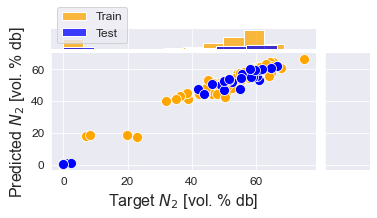

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.937 

	 Test R2: 0.937

	 CV R2: 0.851 (+/- 0.074) 

	 Train RMSE: 2.154 

	 Test RMSE: 2.157

	 CV RMSE: 3.130 (+/- 0.723) 

	 Test MAPE: 16.163



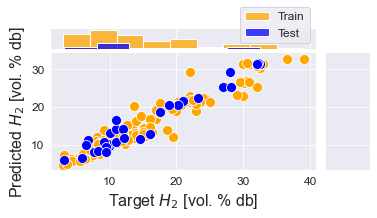

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.962 

	 Test R2: 0.953

	 CV R2: 0.914 (+/- 0.031) 

	 Train RMSE: 1.895 

	 Test RMSE: 2.181

	 CV RMSE: 2.760 (+/- 0.560) 

	 Test MAPE: 11.589



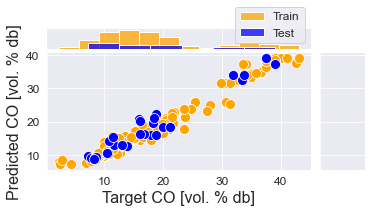

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.972 

	 Test R2: 0.953

	 CV R2: 0.921 (+/- 0.033) 

	 Train RMSE: 1.123 

	 Test RMSE: 1.467

	 CV RMSE: 1.830 (+/- 0.354) 

	 Test MAPE: 9.728



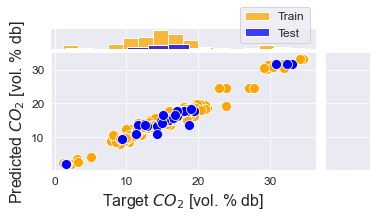

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.919 

	 Test R2: 0.948

	 CV R2: 0.817 (+/- 0.082) 

	 Train RMSE: 0.788 

	 Test RMSE: 0.576

	 CV RMSE: 1.134 (+/- 0.307) 

	 Test MAPE: 12.719



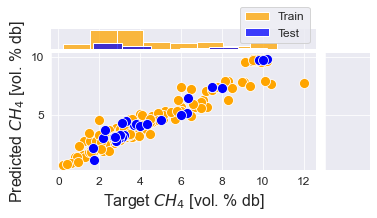

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.926 

	 Test R2: 0.868

	 CV R2: 0.748 (+/- 0.141) 

	 Train RMSE: 0.304 

	 Test RMSE: 0.394

	 CV RMSE: 0.537 (+/- 0.148) 

	 Test MAPE: 25.358



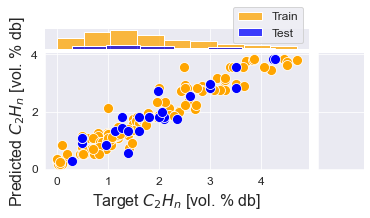

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.975 

	 Test R2: 0.937

	 CV R2: 0.920 (+/- 0.033) 

	 Train RMSE: 0.395 

	 Test RMSE: 0.656

	 CV RMSE: 0.684 (+/- 0.084) 

	 Test MAPE: 8.861



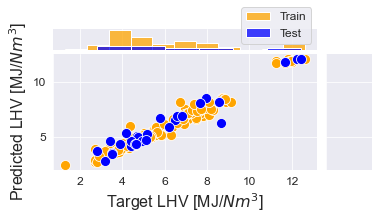

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.808 

	 Test R2: 0.743

	 CV R2: 0.613 (+/- 0.128) 

	 Train RMSE: 9.537 

	 Test RMSE: 10.349

	 CV RMSE: 13.294 (+/- 4.873) 

	 Test MAPE: inf



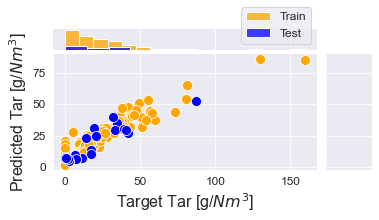

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.942 

	 Test R2: 0.930

	 CV R2: 0.902 (+/- 0.030) 

	 Train RMSE: 0.235 

	 Test RMSE: 0.296

	 CV RMSE: 0.308 (+/- 0.066) 

	 Test MAPE: 10.466



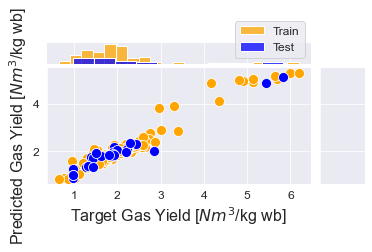

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
`max

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.919 

	 Test R2: 0.225

	 CV R2: 0.830 (+/- 0.042) 

	 Train RMSE: 14.815 

	 Test RMSE: 28.896

	 CV RMSE: 21.744 (+/- 4.477) 

	 Test MAPE: 61.074



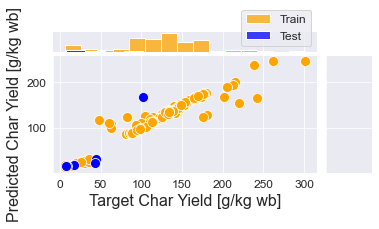

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.848 % 



In [47]:
# Show performance of model with highest cross validated R2
RF_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'RF', random_state = 42, CV_folds = 5, optimisation = True, iterations_RandSearch = 'auto' , display = True)

disp_performance_metrics(RF_performance_summary_opt)

#### 4.3.2) Sklearn Gradient Boosting 

---

GBR model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 40824 

1000 combinations will be considered in search 


# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.996 

	 Test R2: 0.988

	 CV R2: 0.965 (+/- 0.014) 

	 Train RMSE: 1.410 

	 Test RMSE: 2.621

	 CV RMSE: 4.142 (+/- 1.065) 

	 Test MAPE: inf



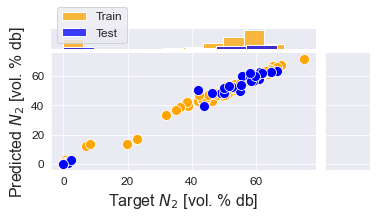

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.978

	 CV R2: 0.897 (+/- 0.070) 

	 Train RMSE: 0.724 

	 Test RMSE: 1.270

	 CV RMSE: 2.520 (+/- 0.767) 

	 Test MAPE: 9.949



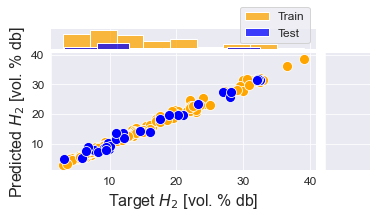

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.994 

	 Test R2: 0.959

	 CV R2: 0.941 (+/- 0.018) 

	 Train RMSE: 0.781 

	 Test RMSE: 2.049

	 CV RMSE: 2.289 (+/- 0.391) 

	 Test MAPE: 9.287



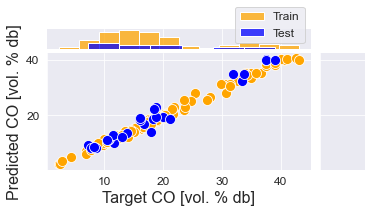

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.959

	 CV R2: 0.942 (+/- 0.023) 

	 Train RMSE: 0.546 

	 Test RMSE: 1.369

	 CV RMSE: 1.578 (+/- 0.266) 

	 Test MAPE: 8.796



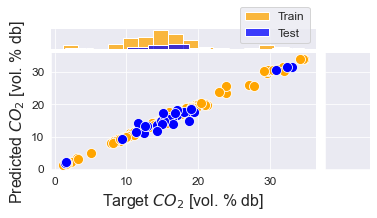

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.996 

	 Test R2: 0.977

	 CV R2: 0.883 (+/- 0.096) 

	 Train RMSE: 0.170 

	 Test RMSE: 0.385

	 CV RMSE: 0.875 (+/- 0.361) 

	 Test MAPE: 8.255



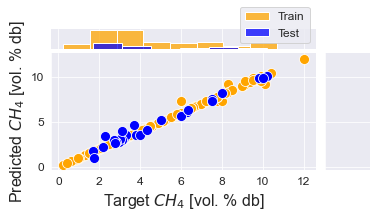

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.974 

	 Test R2: 0.911

	 CV R2: 0.835 (+/- 0.077) 

	 Train RMSE: 0.180 

	 Test RMSE: 0.324

	 CV RMSE: 0.439 (+/- 0.103) 

	 Test MAPE: 17.978



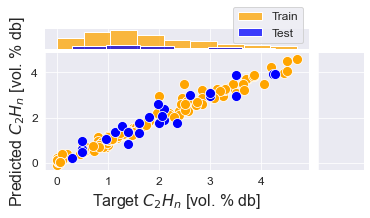

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.995 

	 Test R2: 0.952

	 CV R2: 0.941 (+/- 0.027) 

	 Train RMSE: 0.171 

	 Test RMSE: 0.575

	 CV RMSE: 0.586 (+/- 0.087) 

	 Test MAPE: 7.474



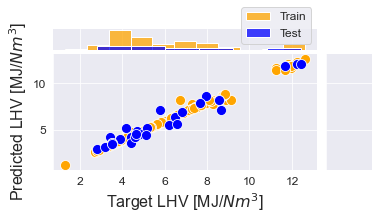

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.996 

	 Test R2: 0.664

	 CV R2: 0.770 (+/- 0.080) 

	 Train RMSE: 1.374 

	 Test RMSE: 11.830

	 CV RMSE: 9.817 (+/- 2.331) 

	 Test MAPE: inf



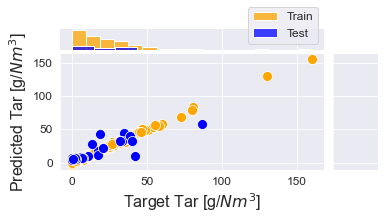

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.992 

	 Test R2: 0.966

	 CV R2: 0.956 (+/- 0.018) 

	 Train RMSE: 0.086 

	 Test RMSE: 0.205

	 CV RMSE: 0.203 (+/- 0.034) 

	 Test MAPE: 6.834



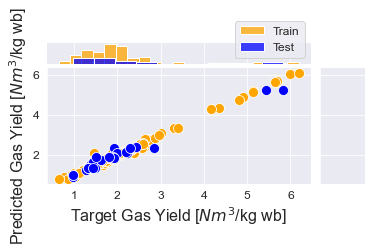

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.997 

	 Test R2: -2.084

	 CV R2: 0.825 (+/- 0.080) 

	 Train RMSE: 2.709 

	 Test RMSE: 57.663

	 CV RMSE: 21.667 (+/- 5.287) 

	 Test MAPE: 67.820



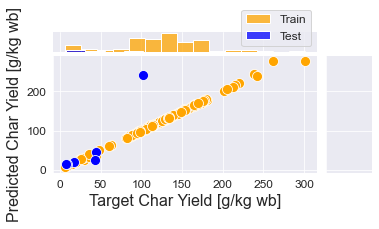

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



In [48]:
GBR_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'GBR', random_state = 42, CV_folds = 5, optimisation = True, iterations_RandSearch = 1000, display = True)


GBR model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 40824 

10000 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.996 

	 Test R2: 0.988

	 CV R2: 0.965 (+/- 0.014) 

	 Train RMSE: 1.410 

	 Test RMSE: 2.621

	 CV RMSE: 4.142 (+/- 1.065) 

	 Test MAPE: inf



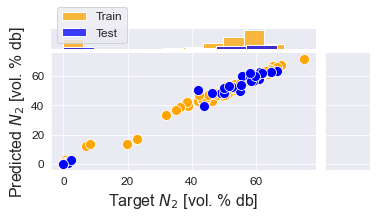

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.978

	 CV R2: 0.897 (+/- 0.070) 

	 Train RMSE: 0.724 

	 Test RMSE: 1.270

	 CV RMSE: 2.520 (+/- 0.767) 

	 Test MAPE: 9.949



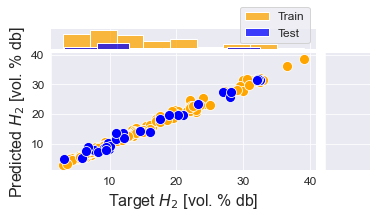

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.994 

	 Test R2: 0.959

	 CV R2: 0.941 (+/- 0.018) 

	 Train RMSE: 0.781 

	 Test RMSE: 2.049

	 CV RMSE: 2.289 (+/- 0.391) 

	 Test MAPE: 9.287



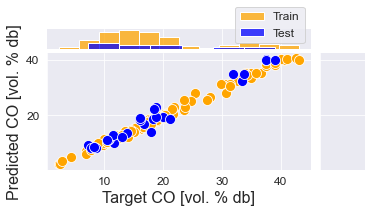

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.959

	 CV R2: 0.942 (+/- 0.023) 

	 Train RMSE: 0.546 

	 Test RMSE: 1.369

	 CV RMSE: 1.578 (+/- 0.266) 

	 Test MAPE: 8.796



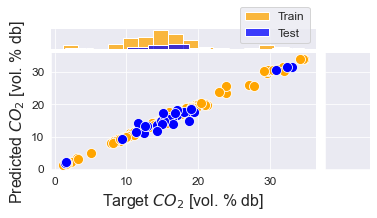

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.996 

	 Test R2: 0.977

	 CV R2: 0.883 (+/- 0.096) 

	 Train RMSE: 0.170 

	 Test RMSE: 0.385

	 CV RMSE: 0.875 (+/- 0.361) 

	 Test MAPE: 8.255



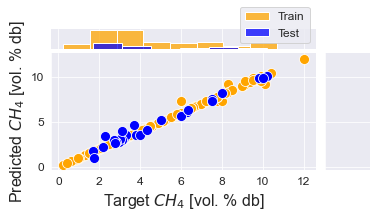

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.974 

	 Test R2: 0.911

	 CV R2: 0.835 (+/- 0.077) 

	 Train RMSE: 0.180 

	 Test RMSE: 0.324

	 CV RMSE: 0.439 (+/- 0.103) 

	 Test MAPE: 17.978



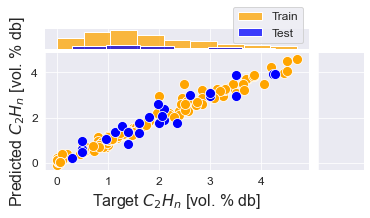

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.995 

	 Test R2: 0.952

	 CV R2: 0.941 (+/- 0.027) 

	 Train RMSE: 0.171 

	 Test RMSE: 0.575

	 CV RMSE: 0.586 (+/- 0.087) 

	 Test MAPE: 7.474



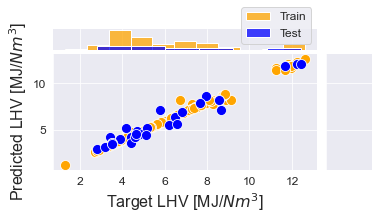

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.996 

	 Test R2: 0.664

	 CV R2: 0.770 (+/- 0.080) 

	 Train RMSE: 1.374 

	 Test RMSE: 11.830

	 CV RMSE: 9.817 (+/- 2.331) 

	 Test MAPE: inf



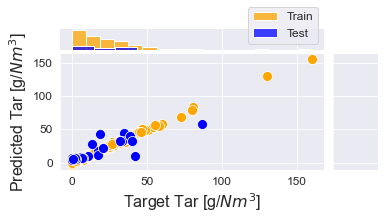

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.992 

	 Test R2: 0.966

	 CV R2: 0.956 (+/- 0.018) 

	 Train RMSE: 0.086 

	 Test RMSE: 0.205

	 CV RMSE: 0.203 (+/- 0.034) 

	 Test MAPE: 6.834



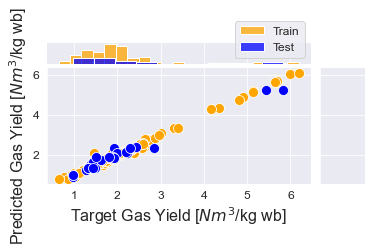

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
`max_features

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.997 

	 Test R2: -2.084

	 CV R2: 0.825 (+/- 0.080) 

	 Train RMSE: 2.709 

	 Test RMSE: 57.663

	 CV RMSE: 21.667 (+/- 5.287) 

	 Test MAPE: 67.820



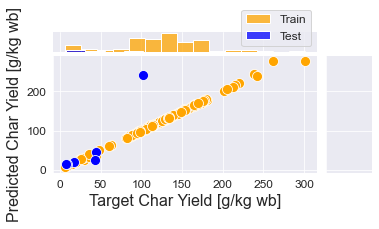

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.895 % 



In [49]:
# Show performance of model with highest cross validated R2
GBR_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'GBR', random_state = 42, CV_folds = 5, optimisation = True, iterations_RandSearch = 10000, display = True)

disp_performance_metrics(GBR_performance_summary_opt)

#### 4.3.3) XGBoost Gradient Boosting

---

XGBoost model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.999 

	 Test R2: 0.988

	 CV R2: 0.963 (+/- 0.015) 

	 Train RMSE: 0.784 

	 Test RMSE: 2.649

	 CV RMSE: 4.211 (+/- 0.890) 

	 Test MAPE: inf



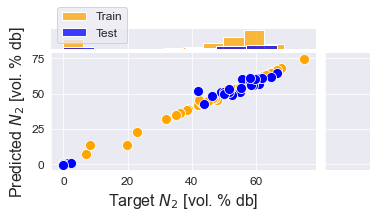

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.999 

	 Test R2: 0.952

	 CV R2: 0.846 (+/- 0.118) 

	 Train RMSE: 0.328 

	 Test RMSE: 1.883

	 CV RMSE: 3.052 (+/- 1.069) 

	 Test MAPE: 10.628



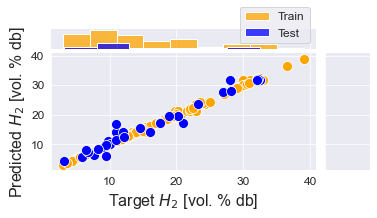

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.997 

	 Test R2: 0.957

	 CV R2: 0.932 (+/- 0.025) 

	 Train RMSE: 0.489 

	 Test RMSE: 2.084

	 CV RMSE: 2.456 (+/- 0.524) 

	 Test MAPE: 8.552



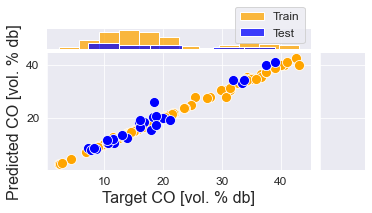

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.997 

	 Test R2: 0.960

	 CV R2: 0.920 (+/- 0.038) 

	 Train RMSE: 0.352 

	 Test RMSE: 1.354

	 CV RMSE: 1.827 (+/- 0.385) 

	 Test MAPE: 7.508



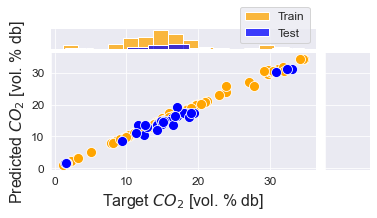

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.996 

	 Test R2: 0.955

	 CV R2: 0.825 (+/- 0.092) 

	 Train RMSE: 0.170 

	 Test RMSE: 0.536

	 CV RMSE: 1.096 (+/- 0.356) 

	 Test MAPE: 9.965



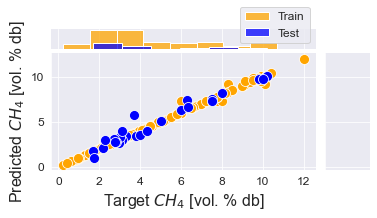

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.987 

	 Test R2: 0.889

	 CV R2: 0.784 (+/- 0.118) 

	 Train RMSE: 0.130 

	 Test RMSE: 0.363

	 CV RMSE: 0.496 (+/- 0.137) 

	 Test MAPE: 18.492



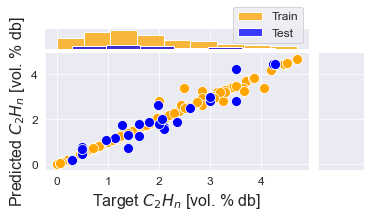

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.995 

	 Test R2: 0.945

	 CV R2: 0.931 (+/- 0.024) 

	 Train RMSE: 0.171 

	 Test RMSE: 0.613

	 CV RMSE: 0.639 (+/- 0.068) 

	 Test MAPE: 8.015



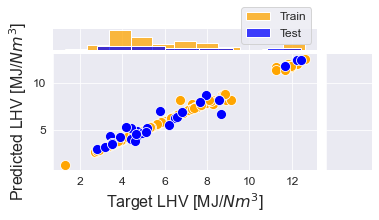

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.999 

	 Test R2: 0.552

	 CV R2: 0.411 (+/- 0.531) 

	 Train RMSE: 0.557 

	 Test RMSE: 13.663

	 CV RMSE: 15.452 (+/- 8.901) 

	 Test MAPE: inf



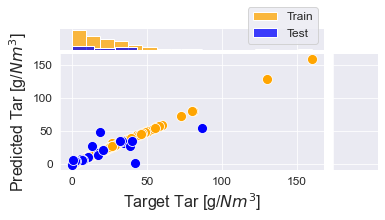

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.996 

	 Test R2: 0.972

	 CV R2: 0.910 (+/- 0.064) 

	 Train RMSE: 0.065 

	 Test RMSE: 0.187

	 CV RMSE: 0.284 (+/- 0.111) 

	 Test MAPE: 6.103



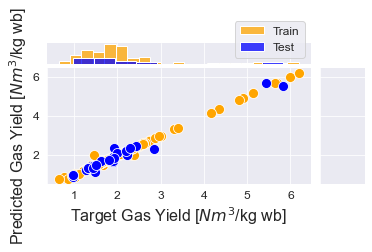

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
pandas.Int64Index is deprecated an

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.998 

	 Test R2: -0.677

	 CV R2: 0.773 (+/- 0.152) 

	 Train RMSE: 2.197 

	 Test RMSE: 42.524

	 CV RMSE: 23.947 (+/- 8.074) 

	 Test MAPE: 37.757



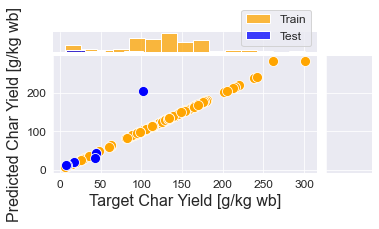

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.830 % 



In [50]:
# Show performance of model with highest cross validated R2
XGBoost_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'XGBoost', random_state = 42, CV_folds = 5, optimisation = 'auto', iterations_RandSearch = 756, display = True)

disp_performance_metrics(XGBoost_performance_summary_opt)


#### 4.3.4) AdaBoost

---

AdaBoost model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 630 

157 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.995 

	 Test R2: 0.987

	 CV R2: 0.964 (+/- 0.012) 

	 Train RMSE: 1.635 

	 Test RMSE: 2.755

	 CV RMSE: 4.188 (+/- 0.820) 

	 Test MAPE: nan



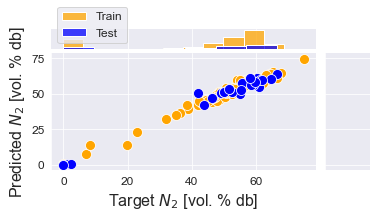

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.997 

	 Test R2: 0.938

	 CV R2: 0.881 (+/- 0.081) 

	 Train RMSE: 0.468 

	 Test RMSE: 2.138

	 CV RMSE: 2.701 (+/- 0.649) 

	 Test MAPE: 13.101



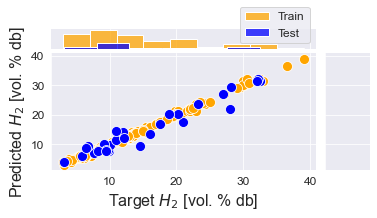

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.957

	 CV R2: 0.947 (+/- 0.011) 

	 Train RMSE: 0.807 

	 Test RMSE: 2.098

	 CV RMSE: 2.178 (+/- 0.242) 

	 Test MAPE: 8.869



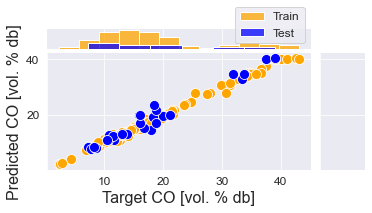

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.964

	 CV R2: 0.941 (+/- 0.024) 

	 Train RMSE: 0.568 

	 Test RMSE: 1.293

	 CV RMSE: 1.589 (+/- 0.291) 

	 Test MAPE: 8.256



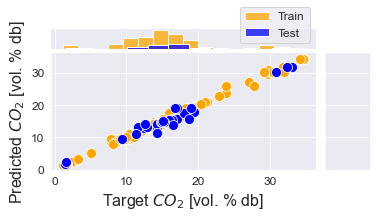

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.988 

	 Test R2: 0.931

	 CV R2: 0.887 (+/- 0.058) 

	 Train RMSE: 0.305 

	 Test RMSE: 0.667

	 CV RMSE: 0.891 (+/- 0.247) 

	 Test MAPE: 11.856



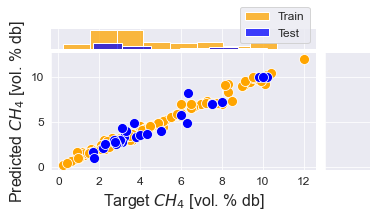

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.955 

	 Test R2: 0.788

	 CV R2: 0.766 (+/- 0.117) 

	 Train RMSE: 0.238 

	 Test RMSE: 0.501

	 CV RMSE: 0.523 (+/- 0.127) 

	 Test MAPE: 26.677



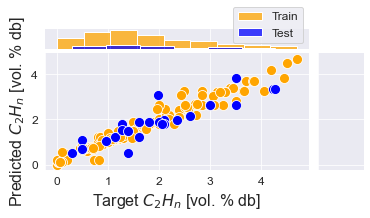

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.993 

	 Test R2: 0.937

	 CV R2: 0.917 (+/- 0.030) 

	 Train RMSE: 0.215 

	 Test RMSE: 0.661

	 CV RMSE: 0.701 (+/- 0.081) 

	 Test MAPE: 8.890



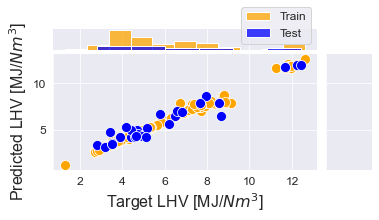

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.998 

	 Test R2: 0.477

	 CV R2: 0.357 (+/- 0.769) 

	 Train RMSE: 1.075 

	 Test RMSE: 14.763

	 CV RMSE: 14.889 (+/- 11.197) 

	 Test MAPE: nan



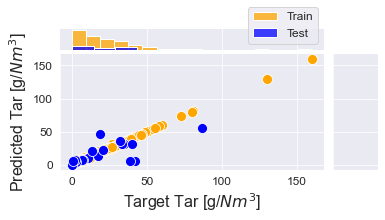

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.959 

	 Test R2: 0.931

	 CV R2: 0.915 (+/- 0.015) 

	 Train RMSE: 0.197 

	 Test RMSE: 0.294

	 CV RMSE: 0.289 (+/- 0.040) 

	 Test MAPE: 13.018



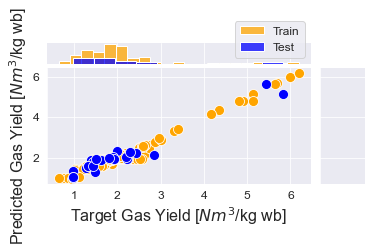

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.991 

	 Test R2: -1.239

	 CV R2: 0.808 (+/- 0.075) 

	 Train RMSE: 4.794 

	 Test RMSE: 49.131

	 CV RMSE: 22.648 (+/- 4.754) 

	 Test MAPE: 82.667



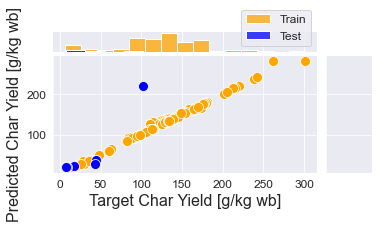

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.838 % 



In [51]:
# Show performance of model with highest cross validated R2
AdaBoost_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'AdaBoost', random_state = 42, CV_folds = 5, optimisation = True, iterations_RandSearch = 'auto', display = True)

disp_performance_metrics(AdaBoost_performance_summary_opt)

#### 4.3.5) Support Vector Machine

---

SVM model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.294 

	 Test R2: 0.261

	 CV R2: 0.243 (+/- 0.150) 

	 Train RMSE: 19.128 

	 Test RMSE: 20.427

	 CV RMSE: 19.698 (+/- 3.314) 

	 Test MAPE: inf



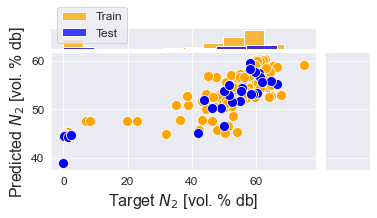

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.638 

	 Test R2: 0.621

	 CV R2: 0.576 (+/- 0.098) 

	 Train RMSE: 5.178 

	 Test RMSE: 5.304

	 CV RMSE: 5.523 (+/- 1.427) 

	 Test MAPE: 30.233



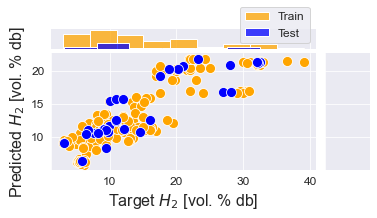

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.646 

	 Test R2: 0.643

	 CV R2: 0.532 (+/- 0.185) 

	 Train RMSE: 5.810 

	 Test RMSE: 6.025

	 CV RMSE: 6.468 (+/- 1.478) 

	 Test MAPE: 28.059



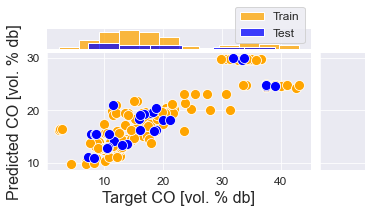

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.774 

	 Test R2: 0.790

	 CV R2: 0.740 (+/- 0.046) 

	 Train RMSE: 3.207 

	 Test RMSE: 3.110

	 CV RMSE: 3.408 (+/- 0.246) 

	 Test MAPE: 40.995



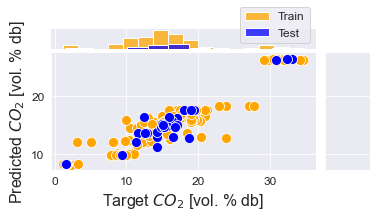

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.816 

	 Test R2: 0.911

	 CV R2: 0.763 (+/- 0.102) 

	 Train RMSE: 1.185 

	 Test RMSE: 0.754

	 CV RMSE: 1.299 (+/- 0.334) 

	 Test MAPE: 15.168



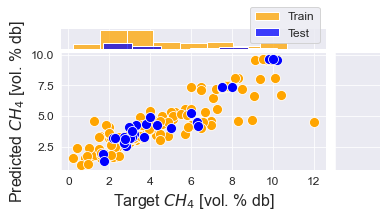

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.818 

	 Test R2: 0.775

	 CV R2: 0.693 (+/- 0.094) 

	 Train RMSE: 0.478 

	 Test RMSE: 0.516

	 CV RMSE: 0.610 (+/- 0.081) 

	 Test MAPE: 27.241



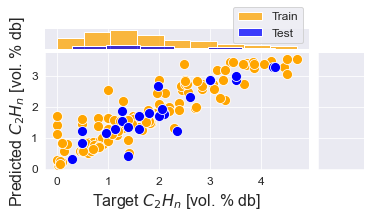

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.917 

	 Test R2: 0.930

	 CV R2: 0.898 (+/- 0.023) 

	 Train RMSE: 0.720 

	 Test RMSE: 0.692

	 CV RMSE: 0.784 (+/- 0.052) 

	 Test MAPE: 10.606



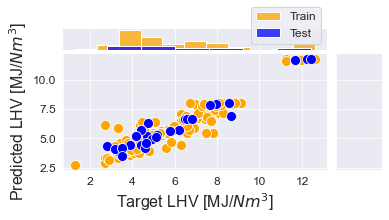

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.123 

	 Test R2: 0.141

	 CV R2: 0.089 (+/- 0.063) 

	 Train RMSE: 20.371 

	 Test RMSE: 18.914

	 CV RMSE: 20.217 (+/- 5.102) 

	 Test MAPE: inf



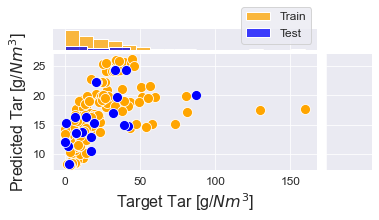

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.926 

	 Test R2: 0.934

	 CV R2: 0.896 (+/- 0.049) 

	 Train RMSE: 0.265 

	 Test RMSE: 0.287

	 CV RMSE: 0.313 (+/- 0.095) 

	 Test MAPE: 8.816



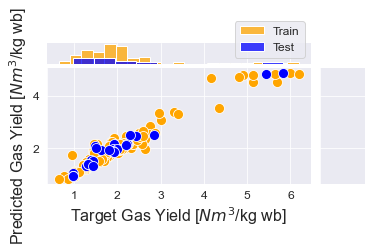

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.209 

	 Test R2: -4.770

	 CV R2: 0.149 (+/- 0.045) 

	 Train RMSE: 46.202 

	 Test RMSE: 78.872

	 CV RMSE: 48.581 (+/- 5.093) 

	 Test MAPE: 554.503



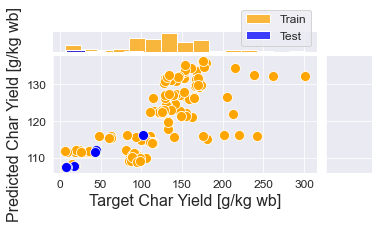

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.558 % 



In [52]:
# Show performance of model with highest cross validated R2
SVM_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'SVM', random_state = 42, CV_folds = 5, optimisation = False, iterations_RandSearch = 'auto', display = True)

disp_performance_metrics(SVM_performance_summary_opt)

#### 4.3.6) Multilayer Perceptron Neural Network

---

ANN model selected!

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Total number of combinations in optimisation grid: 336 

100 combinations will be considered in search 

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Performance of model number 1 for the output N2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.992 

	 Test R2: 0.992

	 CV R2: 0.951 (+/- 0.014) 

	 Train RMSE: 2.012 

	 Test RMSE: 2.065

	 CV RMSE: 4.970 (+/- 0.995) 

	 Test MAPE: inf



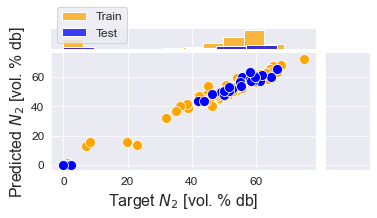

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 2 for the output H2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.985 

	 Test R2: 0.960

	 CV R2: 0.845 (+/- 0.101) 

	 Train RMSE: 1.059 

	 Test RMSE: 1.723

	 CV RMSE: 3.089 (+/- 1.296) 

	 Test MAPE: 10.828



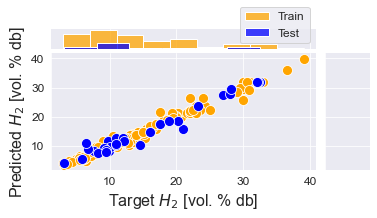

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 3 for the output CO [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.973 

	 Test R2: 0.936

	 CV R2: 0.918 (+/- 0.034) 

	 Train RMSE: 1.607 

	 Test RMSE: 2.543

	 CV RMSE: 2.676 (+/- 0.559) 

	 Test MAPE: 12.753



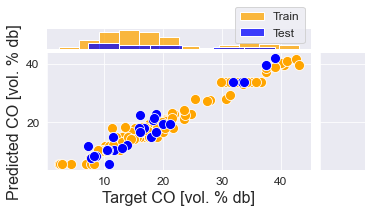

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 4 for the output CO2 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.994 

	 Test R2: 0.934

	 CV R2: 0.856 (+/- 0.049) 

	 Train RMSE: 0.513 

	 Test RMSE: 1.747

	 CV RMSE: 2.495 (+/- 0.371) 

	 Test MAPE: 9.405



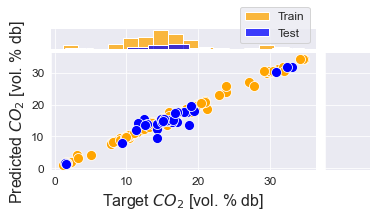

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 5 for the output CH4 [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.975 

	 Test R2: 0.950

	 CV R2: 0.848 (+/- 0.098) 

	 Train RMSE: 0.439 

	 Test RMSE: 0.567

	 CV RMSE: 1.004 (+/- 0.319) 

	 Test MAPE: 11.472



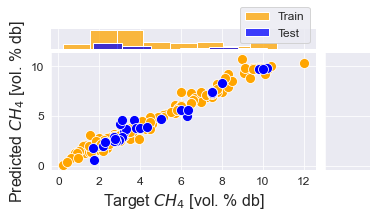

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 6 for the output C2Hn [vol.% db] :

Number of samples in training set: 163.0 	 Number of sample in test set: 26.0 

	 Train R2: 0.961 

	 Test R2: 0.805

	 CV R2: 0.772 (+/- 0.080) 

	 Train RMSE: 0.221 

	 Test RMSE: 0.480

	 CV RMSE: 0.525 (+/- 0.088) 

	 Test MAPE: 24.531



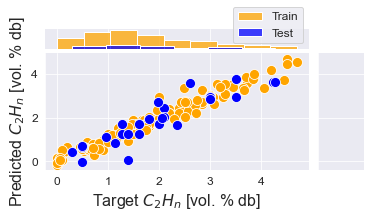

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 7 for the output LHV [MJ/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 30.0 

	 Train R2: 0.987 

	 Test R2: 0.976

	 CV R2: 0.898 (+/- 0.063) 

	 Train RMSE: 0.290 

	 Test RMSE: 0.405

	 CV RMSE: 0.748 (+/- 0.171) 

	 Test MAPE: 5.700



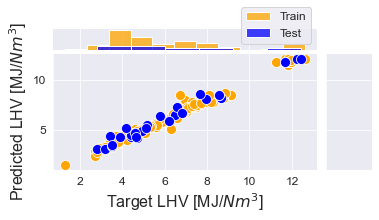

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 8 for the output Tar [g/Nm3] :

Number of samples in training set: 163.0 	 Number of sample in test set: 21.0 

	 Train R2: 0.975 

	 Test R2: 0.529

	 CV R2: 0.553 (+/- 0.272) 

	 Train RMSE: 3.446 

	 Test RMSE: 14.001

	 CV RMSE: 13.103 (+/- 3.689) 

	 Test MAPE: inf



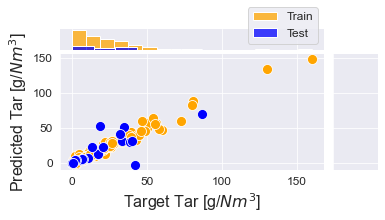

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 9 for the output Gas yield [Nm3/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 28.0 

	 Train R2: 0.984 

	 Test R2: 0.984

	 CV R2: 0.938 (+/- 0.019) 

	 Train RMSE: 0.124 

	 Test RMSE: 0.141

	 CV RMSE: 0.244 (+/- 0.052) 

	 Test MAPE: 5.656



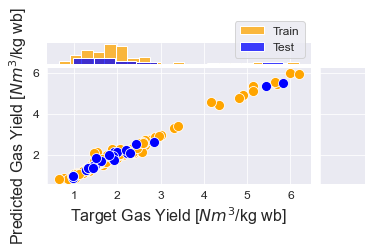

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 



lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterat

Performance of model number 10 for the output Char yield [g/kg wb] :

Number of samples in training set: 163.0 	 Number of sample in test set: 6.0 

	 Train R2: 0.946 

	 Test R2: -1.537

	 CV R2: 0.737 (+/- 0.072) 

	 Train RMSE: 12.083 

	 Test RMSE: 52.297

	 CV RMSE: 27.089 (+/- 6.125) 

	 Test MAPE: 80.354



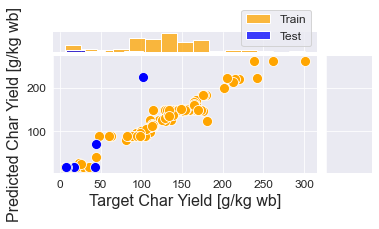

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Results for predictor pretreatment option: 3 and target pretreatment option: 3 

Mean cross validated R2 value: 0.831 % 



In [53]:
# Show performance of model with highest cross validated R2
ANN_performance_summary_opt = build_models(df_pred_encoded, df_tar_encoded, predictor_pretreatment = 3, target_pretreatment = 3, modelname = 'ANN', random_state = 42, CV_folds = 5, optimisation = True, iterations_RandSearch = 'auto', display = True)

disp_performance_metrics(ANN_performance_summary_opt)

#### 4.3.7) Summary plots & conclusions

---

##### 4.3.7.1) Summary

---

In [54]:
# Summary of key model scores (mean values shown - individual values shown in cell below)

# Select models to be stored
modellabels = ['RF','GBR', 'XGBoost', 'AdaBoost', 'SVM', 'ANN']

# Initialise dataframe
# CV R2
optmised_models_summary = pd.DataFrame(columns= modellabels, index = ['R2_CV', 'R2_test', 'RMSE_CV', 'RMSE_test'])
optmised_models_summary.loc['R2_CV']['RF'] = np.mean(RF_performance_summary_opt.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['GBR'] = np.mean(GBR_performance_summary_opt.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['XGBoost'] = np.mean(XGBoost_performance_summary_opt.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['AdaBoost'] = np.mean(AdaBoost_performance_summary_opt.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['SVM'] = np.mean(SVM_performance_summary_opt.loc['R2_CV'])
optmised_models_summary.loc['R2_CV']['ANN'] = np.mean(ANN_performance_summary_opt.loc['R2_CV'])

# R2 for test set
optmised_models_summary.loc['R2_test']['RF'] = np.mean(RF_performance_summary_opt.loc['R2_test'])
optmised_models_summary.loc['R2_test']['GBR'] = np.mean(GBR_performance_summary_opt.loc['R2_test'])
optmised_models_summary.loc['R2_test']['XGBoost'] = np.mean(XGBoost_performance_summary_opt.loc['R2_test'])
optmised_models_summary.loc['R2_test']['AdaBoost'] = np.mean(AdaBoost_performance_summary_opt.loc['R2_test'])
optmised_models_summary.loc['R2_test']['SVM'] = np.mean(SVM_performance_summary_opt.loc['R2_test'])
optmised_models_summary.loc['R2_test']['ANN'] = np.mean(ANN_performance_summary_opt.loc['R2_test'])


# CV RMSE
optmised_models_summary.loc['RMSE_CV']['RF'] = np.mean(RF_performance_summary_opt.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['GBR'] = np.mean(GBR_performance_summary_opt.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['XGBoost'] = np.mean(XGBoost_performance_summary_opt.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['AdaBoost'] = np.mean(AdaBoost_performance_summary_opt.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['SVM'] = np.mean(SVM_performance_summary_opt.loc['RMSE_CV'])
optmised_models_summary.loc['RMSE_CV']['ANN'] = np.mean(ANN_performance_summary_opt.loc['RMSE_CV'])

# RMSE for test set
optmised_models_summary.loc['RMSE_test']['RF'] = np.mean(RF_performance_summary_opt.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['GBR'] = np.mean(GBR_performance_summary_opt.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['XGBoost'] = np.mean(XGBoost_performance_summary_opt.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['AdaBoost'] = np.mean(AdaBoost_performance_summary_opt.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['SVM'] = np.mean(SVM_performance_summary_opt.loc['RMSE_test'])
optmised_models_summary.loc['RMSE_test']['ANN'] = np.mean(ANN_performance_summary_opt.loc['RMSE_test'])

# Display performance of models
optmised_models_summary

RF  GBR XGBoost AdaBoost   SVM  ANN
R2_CV     0.85 0.90    0.83     0.84  0.56 0.83
R2_test   0.85 0.63    0.75     0.67  0.12 0.65
RMSE_CV   4.99 4.41    5.35     5.06 10.69 5.59
RMSE_test 5.00 7.83    6.59     7.43 13.49 7.60

In [55]:
# Summary of individual model scores

# List of output models to be columns of dataframe
modellabels = RF_performance_summary_opt.columns

# Initialise dataframe
optmised_individual_models_summary = pd.DataFrame(columns= modellabels, index = ['RF_R2_CV', 'GBR_R2_CV', 'XGBoost_R2_CV', 'AdaBoost_R2_CV', 'SVM_R2_CV', 'ANN_R2_CV', # R2 CV
                                                                                 'RF_R2_test', 'GBR_R2_test', 'XGBoost_R2_test', 'AdaBoost_R2_test', 'SVM_R2_test', 'ANN_R2_test', # R2 test
                                                                                 'RF_RMSE_CV', 'GBR_RMSE_CV', 'XGBoost_RMSE_CV', 'AdaBoost_RMSE_CV', 'SVM_RMSE_CV', 'ANN_RMSE_CV', # RMSE CV
                                                                                 'RF_RMSE_test', 'GBR_RMSE_test', 'XGBoost_RMSE_test', 'AdaBoost_RMSE_test', 'SVM_RMSE_test', 'ANN_RMSE_test', # RMSE test
                                                                                ]) 
# CV R2
optmised_individual_models_summary.loc['RF_R2_CV'] = RF_performance_summary_opt.loc['R2_CV']
optmised_individual_models_summary.loc['GBR_R2_CV'] = GBR_performance_summary_opt.loc['R2_CV']
optmised_individual_models_summary.loc['XGBoost_R2_CV'] = XGBoost_performance_summary_opt.loc['R2_CV']
optmised_individual_models_summary.loc['AdaBoost_R2_CV'] = AdaBoost_performance_summary_opt.loc['R2_CV']
optmised_individual_models_summary.loc['SVM_R2_CV'] = SVM_performance_summary_opt.loc['R2_CV']
optmised_individual_models_summary.loc['ANN_R2_CV'] = ANN_performance_summary_opt.loc['R2_CV']

# R2 for test set
optmised_individual_models_summary.loc['RF_R2_test'] = RF_performance_summary_opt.loc['R2_test']
optmised_individual_models_summary.loc['GBR_R2_test'] = GBR_performance_summary_opt.loc['R2_test']
optmised_individual_models_summary.loc['XGBoost_R2_test'] = XGBoost_performance_summary_opt.loc['R2_test']
optmised_individual_models_summary.loc['AdaBoost_R2_test'] = AdaBoost_performance_summary_opt.loc['R2_test']
optmised_individual_models_summary.loc['SVM_R2_test'] = SVM_performance_summary_opt.loc['R2_test']
optmised_individual_models_summary.loc['ANN_R2_test'] = ANN_performance_summary_opt.loc['R2_test']


# CV RMSE
optmised_individual_models_summary.loc['RF_RMSE_CV'] = RF_performance_summary_opt.loc['RMSE_CV']
optmised_individual_models_summary.loc['GBR_RMSE_CV'] = GBR_performance_summary_opt.loc['RMSE_CV']
optmised_individual_models_summary.loc['XGBoost_RMSE_CV'] = XGBoost_performance_summary_opt.loc['RMSE_CV']
optmised_individual_models_summary.loc['AdaBoost_RMSE_CV'] = AdaBoost_performance_summary_opt.loc['RMSE_CV']
optmised_individual_models_summary.loc['SVM_RMSE_CV'] = SVM_performance_summary_opt.loc['RMSE_CV']
optmised_individual_models_summary.loc['ANN_RMSE_CV'] = ANN_performance_summary_opt.loc['RMSE_CV']

# RMSE for test set
optmised_individual_models_summary.loc['RF_RMSE_test'] = RF_performance_summary_opt.loc['RMSE_test']
optmised_individual_models_summary.loc['GBR_RMSE_test'] = GBR_performance_summary_opt.loc['RMSE_test']
optmised_individual_models_summary.loc['XGBoost_RMSE_test'] = XGBoost_performance_summary_opt.loc['RMSE_test']
optmised_individual_models_summary.loc['AdaBoost_RMSE_test'] = AdaBoost_performance_summary_opt.loc['RMSE_test']
optmised_individual_models_summary.loc['SVM_RMSE_test'] = SVM_performance_summary_opt.loc['RMSE_test']
optmised_individual_models_summary.loc['ANN_RMSE_test'] = ANN_performance_summary_opt.loc['RMSE_test']


# Display performance of models
optmised_individual_models_summary

N2 [vol.% db] H2 [vol.% db] CO [vol.% db] CO2 [vol.% db]  \
RF_R2_CV                    0.96          0.85          0.91           0.92   
GBR_R2_CV                   0.97          0.90          0.94           0.94   
XGBoost_R2_CV               0.96          0.85          0.93           0.92   
AdaBoost_R2_CV              0.96          0.88          0.95           0.94   
SVM_R2_CV                   0.24          0.58          0.53           0.74   
ANN_R2_CV                   0.95          0.84          0.92           0.86   
RF_R2_test                  0.98          0.94          0.95           0.95   
GBR_R2_test                 0.99          0.98          0.96           0.96   
XGBoost_R2_test             0.99          0.95          0.96           0.96   
AdaBoost_R2_test            0.99          0.94          0.96           0.96   
SVM_R2_test                 0.26          0.62          0.64           0.79   
ANN_R2_test                 0.99          0.96          0.94           0.93   
RF_RMSE_CV                  4.45          3.13          2.76           1.83   
GBR_RMSE_CV                 4.14          2.52          2.29           1.58   
XGBoost_RMSE_CV             4.21          3.05          2.46           1.83   
AdaBoost_RMSE_CV            4.19          2.70          2.18           1.59   
SVM_RMSE_CV                19.70          5.52          6.47           3.41   
ANN_RMSE_CV                 4.97          3.09          2.68           2.50   
RF_RMSE_test                3.05          2.16          2.18           1.47   
GBR_RMSE_test               2.62          1.27          2.05           1.37   
XGBoost_RMSE_test           2.65          1.88          2.08           1.35   
AdaBoost_RMSE_test          2.75          2.14          2.10           1.29   
SVM_RMSE_test              20.43          5.30          6.02           3.11   
ANN_RMSE_test               2.07          1.72          2.54           1.75   

                   CH4 [vol.% db] C2Hn [vol.% db] LHV [MJ/Nm3] Tar [g/Nm3]  \
RF_R2_CV                     0.82            0.75         0.92        0.61   
GBR_R2_CV                    0.88            0.84         0.94        0.77   
XGBoost_R2_CV                0.83            0.78         0.93        0.41   
AdaBoost_R2_CV               0.89            0.77         0.92        0.36   
SVM_R2_CV                    0.76            0.69         0.90        0.09   
ANN_R2_CV                    0.85            0.77         0.90        0.55   
RF_R2_test                   0.95            0.87         0.94        0.74   
GBR_R2_test                  0.98            0.91         0.95        0.66   
XGBoost_R2_test              0.96            0.89         0.95        0.55   
AdaBoost_R2_test             0.93            0.79         0.94        0.48   
SVM_R2_test                  0.91            0.77         0.93        0.14   
ANN_R2_test                  0.95            0.80         0.98        0.53   
RF_RMSE_CV                   1.13            0.54         0.68       13.29   
GBR_RMSE_CV                  0.87            0.44         0.59        9.82   
XGBoost_RMSE_CV              1.10            0.50         0.64       15.45   
AdaBoost_RMSE_CV             0.89            0.52         0.70       14.89   
SVM_RMSE_CV                  1.30            0.61         0.78       20.22   
ANN_RMSE_CV                  1.00            0.52         0.75       13.10   
RF_RMSE_test                 0.58            0.39         0.66       10.35   
GBR_RMSE_test                0.38            0.32         0.57       11.83   
XGBoost_RMSE_test            0.54            0.36         0.61       13.66   
AdaBoost_RMSE_test           0.67            0.50         0.66       14.76   
SVM_RMSE_test                0.75            0.52         0.69       18.91   
ANN_RMSE_test                0.57            0.48         0.40       14.00   

                   Gas yield [Nm3/kg wb] Char yield [g/kg wb]  
RF_R2_CV                    

##### 4.3.7.2) Combined regression plots


###### 4.3.7.2.1) Function

---

In [56]:
# Define prerequisite functions used within the plotting function:

# Create Function to scale values in array to choosen range:
def ScaleArray(array, lower_bound = 0, upper_bound = 1):
    scaled_array = lower_bound + (array - np.min(array)) / (np.max(array) - np.min(array))*(upper_bound - lower_bound)
    return scaled_array

# Create function that splits array in half:
def SplitArray(array):
    half = len(array)//2
    FirstHalf = array[:half]
    SecondHalf = array[half:]
    return FirstHalf, SecondHalf

In [57]:
def ScatterAll(performance_summary, modeltype, marker_style = 'varied', save_fig = False,):
        
    """
    Function to create a combined scatter plot of all test predictions of a model.
    
    Inputs:
    performance_summary - Performance summary dataframe of the model which is to be plotted
    modeltype - String that is used to save the figure. E.g. for Random Forest model: modeltype = 'RF' 
    marker_style - Defines which markers should be used for scatter plot (default: 'varied') Change to 'o' for a neater looking plot but less distinction between points
    save_fig - Specifies whether the model should be saved (default: False). Change to save_fig = True if figure should be saved
    """ 

    # Initialise Figure 
    plt.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(10,10))
    ax1 = fig.add_subplot(111)
    
    if marker_style == 'varied':
        marker_styles = np.array(matplotlib.markers.MarkerStyle.filled_markers)
    else:
        marker_styles = np.array([marker_style] *performance_summary.columns.shape[0])
    
    # Loop to extract, scale, and plot values
    for column in np.arange(performance_summary.columns.shape[0]):

        # Extract predictions and targets
        predictions = performance_summary.iloc[:,column]['test_predictions']
        targets = np.array(performance_summary.iloc[:,column]['test_targets'])
        combined_array = np.concatenate((targets, predictions)) # combined to scale together 
        scaled_array = ScaleArray(combined_array)
        scaled_predictions, scaled_targets =  SplitArray(scaled_array)

        # Extract correspoding label and marker styles
        legend_label = np.array(GBR_performance_summary_opt.columns)[column]
        
        marker = marker_styles[column]
            
        # Plot predictions vs. targets
        ax1.scatter(scaled_targets, scaled_predictions, marker=marker, label=legend_label, s=60, alpha=0.7, zorder=3)
    
    # Configure graph
    plt.legend(loc='upper left');
    plt.legend([r'$N_{2}$',
                r'$H_{2}$',
                r'CO',
                r'$CO_{2}$',
                r'$CH_{4}$',
                r'$C_{2}H_{n}$',
                r'LHV',
                r'Tar',
                r'Gas Yield',
                r'Char Yield'
               ])

    plt.xlabel('Scaled Targets', fontsize= 18)
    plt.ylabel('Scaled Predictions', fontsize= 18)
    
    # Add best fit line
    line = np.linspace(min(scaled_array),max(scaled_array))
    ax1.plot(line, line,color = 'black', linewidth=1.5, linestyle='dashed', zorder=4)
    
    # Add error regions
    ax1.fill_between(line, line - 0.1, line + 0.1,color ='blue', alpha = 0.1, zorder=1) # 10% error
    ax1.fill_between(line, line - 0.2, line + 0.2,color ='blue', alpha = 0.05, zorder=2) # 20% error

    
    
    # Save figure if desired
    if save_fig == True: 
        filename = '\\' + modeltype + '_combined_scatter' + '_marker_' + marker_style + '.png'
        plt.savefig('Figures\Combined Scatter Plots' + filename , dpi=500)
        
    plt.show()
    

###### 4.3.7.2.2) Plots

---

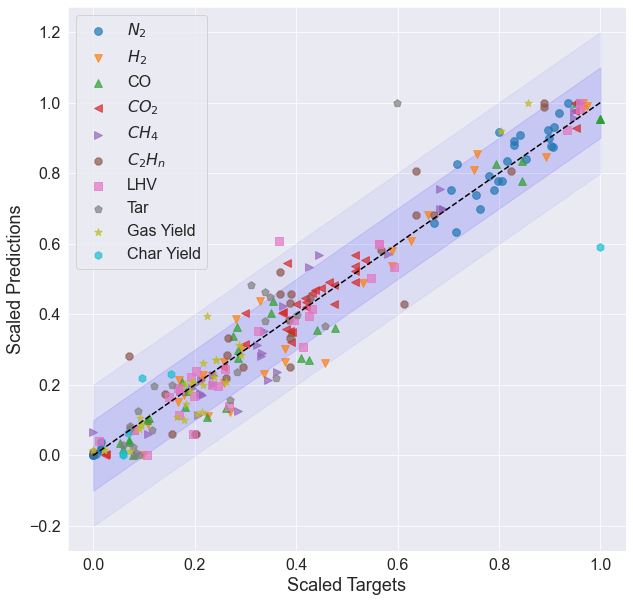

In [58]:
# RF
ScatterAll(performance_summary=RF_performance_summary_opt, modeltype='RF', save_fig=True, marker_style='varied')

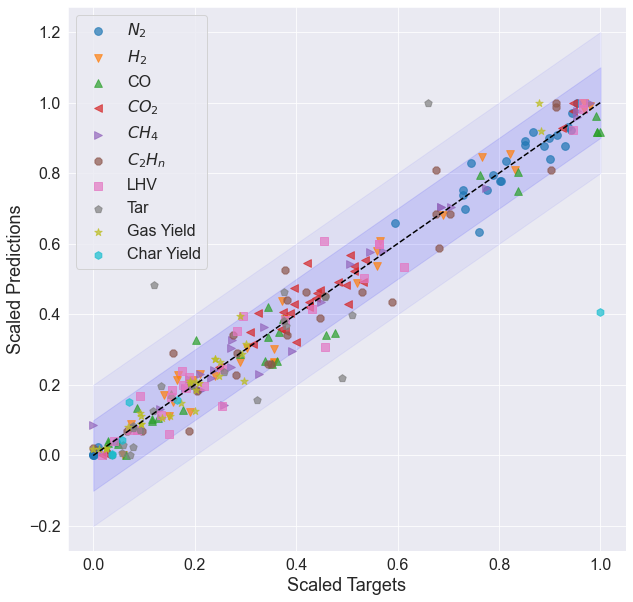

In [59]:
# GBR
ScatterAll(performance_summary=GBR_performance_summary_opt, modeltype='GBR', save_fig=True, marker_style='varied')

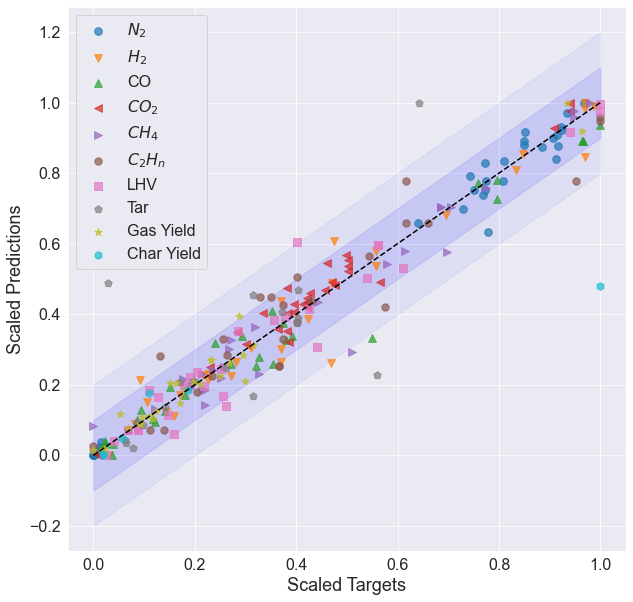

In [60]:
# XGBoost
ScatterAll(performance_summary=XGBoost_performance_summary_opt, modeltype='XGBoost', save_fig=True, marker_style='varied')

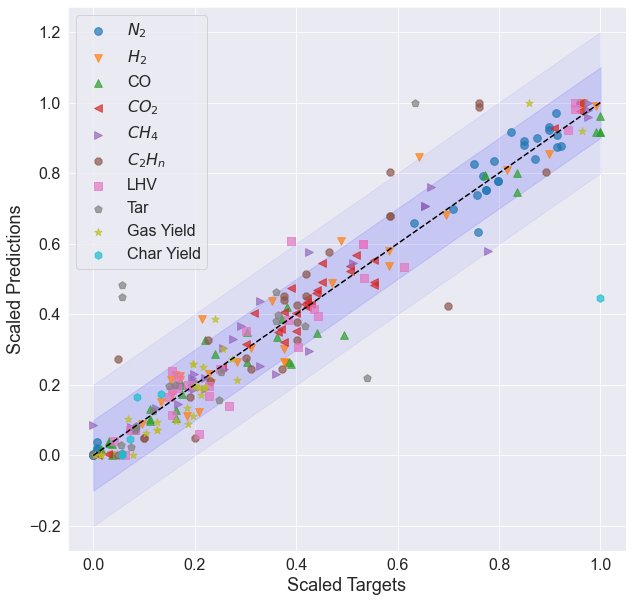

In [61]:
# AdaBoost
ScatterAll(performance_summary=AdaBoost_performance_summary_opt, modeltype='AdaBoost', save_fig=True, marker_style='varied')

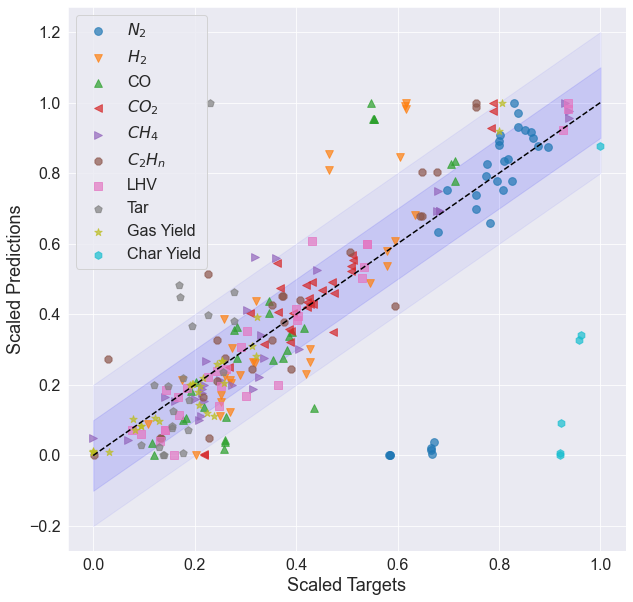

In [62]:
# SVM
ScatterAll(performance_summary=SVM_performance_summary_opt, modeltype='SVM', save_fig=True, marker_style='varied')

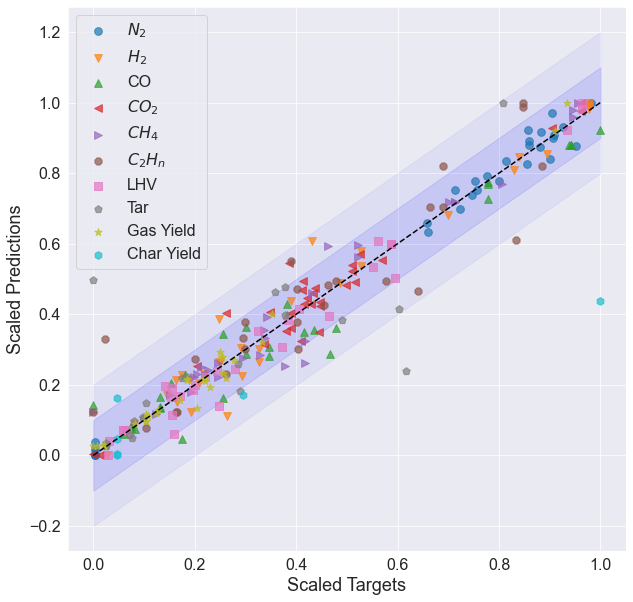

In [63]:
# ANN
ScatterAll(performance_summary=ANN_performance_summary_opt, modeltype='ANN', save_fig=True, marker_style='varied')

##### 4.3.7.3) Conclusions


###### Best performing models:
Sklearn's implementation of a gradient boosting regression model has been found to have the highest average cross-validated prediction accuracy in terms of R2 and RMSE. <br>
The developed Random Forest Models were found to have the 2nd best performance.<br>
XGBoost and AdaBoost were found to perform 3rd best. Whilest XGBoost showed a better test performance, AdaBoost showed a better cross validated performance.<br>
These top performing models will be further compared in the feature importance analysis. <br>
Furthermore, they will be compared to a super learner ensemble (Section 4.4).<br>

---

### 4.4) Super learner ensemble model
A super learner ensemble model which combines all previously optimised models is tested here.

---

#### 4.4.1) Define functions to build super learner

---

In [64]:
# Define prerequisite functions used within model builder function:

# Cost function for base models
def rmse_func(y_true, y_pred):
	return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to update ANN best parameters to requried format for superlearner 
def update_ANN_best_param(best_param_dict):
    # best_param_dict should be in the following form: best_param_dict = ANN_performance_summary_opt[column_header].best_parameters
    updated_dict = dict()
    for parameter in np.arange(len(best_param_dict)):
        value = best_param_dict[list(best_param_dict)[parameter]] # extract values from old dictionary

        excess ,updated_key = list(best_param_dict)[parameter].split("mlpregressor__",1) # extract updated keywords
        updated_dict.update({updated_key: value})

    return updated_dict

# Function to specify base models
def get_basemodels(column_header):
    models = list() # initialise list of base models
    models.append(RandomForestRegressor(random_state=random_state, **RF_performance_summary_opt[column_header].best_parameters))
    models.append(GradientBoostingRegressor(random_state=random_state, **GBR_performance_summary_opt[column_header].best_parameters))
    models.append(XGBRegressor(random_state=random_state)) # default found to be best for XGBoost
    models.append(AdaBoostRegressor(random_state=random_state, **AdaBoost_performance_summary_opt[column_header].best_parameters))
    models.append(make_pipeline(StandardScaler(), svm.SVR())) # default found to be best for SVM
    ANN_best_params_dict = update_ANN_best_param(ANN_performance_summary_opt[column_header].best_parameters) # get best ANN parameters in required format
    models.append(make_pipeline(StandardScaler(), MLPRegressor(random_state = random_state, **ANN_best_params_dict)))                                                                                            
    
    # # Alternative Code to load models 
    # models.append(pickle.loads(RF_performance_summary_opt[column_header]['model']))
    # models.append(pickle.loads(GBR_performance_summary_opt[column_header]['model']))
    # models.append(pickle.loads(XGBoost_performance_summary_opt[column_header]['model']))
    # models.append(pickle.loads(AdaBoost_performance_summary_opt[column_header]['model']))
    # models.append(pickle.loads(SVM_performance_summary_opt[column_header]['model']))
    # models.append(pickle.loads(ANN_performance_summary_opt[column_header]['model']))
    
    return models

# Function to create super learner ensemble
def get_super_learner(X, column_header, scorer = 'RMSE'):
    # Initialise super learner ensemble
    if scorer == 'RMSE':
        ensemble = SuperLearner(scorer=rmse_func, folds=5, shuffle=True, sample_size=len(X))
    elif scorer == 'R2':
        ensemble = SuperLearner(scorer=r2_score, folds=5, shuffle=True, sample_size=len(X))
    else:
        print('Scorer function not supported')
        
    # add base models
    models = get_basemodels(column_header)
    ensemble.add(models)
    
    # add the meta model
    ensemble.add_meta(LinearRegression())
    
    return ensemble


#### 4.4.2) Train super learner

---

In [65]:
%%capture
# Use capture magic to supress warning - that way output does not get clogged up with warning messages

# Build superlearner model

# Initialise data frame to store performance measures of superlearner models
superlearner_performance_summmary = pd.DataFrame(index = ['R2_test', 'RMSE_test', 'R2_CV', 'RMSE_CV'] , columns = GBR_performance_summary_opt.columns) 

# Fit and evaluate models for each target variable
for column in np.arange(GBR_performance_summary_opt.columns.shape[0]):

    # Extract column header - to train model for each output one at a time
    column_header = np.array(GBR_performance_summary_opt.columns)[column]
    print('\n Performance of model for output',column_header,': \n') 
    # Extract pretreated inputs and outputs from previously best performing model
    x_train = np.array(GBR_performance_summary_opt[column_header].x_train)
    x_test = np.array(GBR_performance_summary_opt[column_header].x_test)
    y_train =np.array( GBR_performance_summary_opt[column_header].y_train)
    y_test = np.array(GBR_performance_summary_opt[column_header].y_test)

    # Create and fit super learner
    superlearner = get_super_learner(x_train, column_header, scorer = 'RMSE')
    superlearner.fit(x_train, y_train)

    # Show performance summary of base learners - note: first row contains score 
    print('Performance of base leaners: \n') 
    print(superlearner.data)

    # Evaluate Superlearner model
    y_pred = superlearner.predict(x_test) # get test predictions

    # Evaluate test Performance
    RMSE_test =rmse_func(y_test, y_pred)
    R2_test = r2_score(y_test, y_pred)

    # Evaluate cross validated performance on entire dataset

    # Combine datasets again before calculating cross validation scores
    x_complete = np.array(pd.concat([GBR_performance_summary_opt[column_header].x_train, GBR_performance_summary_opt[column_header].x_test]))
    y_complete = np.array(pd.concat([GBR_performance_summary_opt[column_header].y_train, GBR_performance_summary_opt[column_header].y_test]))

    # Calculate cross validated scores 
    CV_RMSE_scores = -cross_val_score(superlearner, x_complete, y_complete, cv=5, scoring='neg_root_mean_squared_error')
    RMSE_CV = np.mean(CV_RMSE_scores)
    CV_R2_scores = cross_val_score(superlearner, x_complete, y_complete, cv=5, scoring='r2')
    R2_CV = np.mean(CV_R2_scores)    

    # Print performance of superlearner
    # Test scores
    print('Test performance of super learner: \n')
    print('Super learner test RMSE: %.3f' % RMSE_test)
    print('Super learner test R2: %.3f' % R2_test)
    # Cross validated scores
    print('Cross validated performance of super learner: \n')
    print('Super learner cross validated RMSE: %.3f' % RMSE_CV)
    print('Super learner test cross validated: %.3f' % R2_CV)    

    # Store model performance in dataframe
    superlearner_performance_summmary.at['RMSE_test', column_header] = RMSE_test    
    superlearner_performance_summmary.at['R2_test', column_header] = R2_test    
    superlearner_performance_summmary.at['RMSE_CV', column_header] = RMSE_CV
    superlearner_performance_summmary.at['R2_CV', column_header] = R2_CV    



#### 4.4.3) Performance of super learner & Conclusions

---

In [66]:
superlearner_performance_summmary

N2 [vol.% db] H2 [vol.% db] CO [vol.% db] CO2 [vol.% db]  \
R2_test            0.99          0.95          0.97           0.96   
RMSE_test          2.70          1.91          1.88           1.38   
R2_CV              0.96          0.89          0.95           0.94   
RMSE_CV            4.21          2.62          2.20           1.66   

          CH4 [vol.% db] C2Hn [vol.% db] LHV [MJ/Nm3] Tar [g/Nm3]  \
R2_test             0.97            0.91         0.96        0.38   
RMSE_test           0.43            0.33         0.50       16.05   
R2_CV               0.91            0.84         0.94        0.72   
RMSE_CV             0.76            0.48         0.59        9.28   

          Gas yield [Nm3/kg wb] Char yield [g/kg wb]  
R2_test                    0.96                -2.97  
RMSE_test                  0.21                65.44  
R2_CV                      0.94                 0.82  
RMSE_CV                    0.26                22.85

In [67]:
# Show mean performance of super learner in comparison with other models
superlearner_comparison_summary = optmised_models_summary # load performance of old models
superlearner_comparison_summary['Super learner'] = np.nan
# Add mean performance measure of super learner
superlearner_comparison_summary.loc['R2_CV','Super learner'] = np.mean(superlearner_performance_summmary.loc['R2_CV'])
superlearner_comparison_summary.loc['R2_test','Super learner'] = np.mean(superlearner_performance_summmary.loc['R2_test'])
superlearner_comparison_summary.loc['RMSE_CV','Super learner'] = np.mean(superlearner_performance_summmary.loc['RMSE_CV'])
superlearner_comparison_summary.loc['RMSE_test','Super learner'] = np.mean(superlearner_performance_summmary.loc['RMSE_test'])
superlearner_comparison_summary # display dataframe for comparison 

RF  GBR XGBoost AdaBoost   SVM  ANN  Super learner
R2_CV     0.85 0.90    0.83     0.84  0.56 0.83           0.89
R2_test   0.85 0.63    0.75     0.67  0.12 0.65           0.51
RMSE_CV   4.99 4.41    5.35     5.06 10.69 5.59           4.49
RMSE_test 5.00 7.83    6.59     7.43 13.49 7.60           9.08

###### Conclusions:
The developed super learner model was found to perform well. <br>
When comparing the super learner's cross validated R2 and RMSE only the gradient boosting model performed better. On a whole it performed better than the other considered model types. <br>
With a mean cross validated R2 of 0.89 and mean cross validated RMSE of 4.73 only the gradient boosting model performed better by a small margin. <br>
When looking at the mean test performance, it can be seen that the super learner model performed best out of all models - both in terms of R2 and RMSE. This may be explained by the fact that some other models which performed well (e.g. Gradient Boosting Model) showed a bad test performance for the char yied prediction due to the lack of test samples. This outlier in turn affected the mean prediction performance of the Gradient Boosting Model on the test set. Thus individual or cross validated mean model performances need to be studied in addition to the mean test performances.<br>
In conclusion, whilest the super learner performed well it could not be shown that it consistanly outperformed the best performing individual model. <br>

---

# 5.) Feature importance analysis

---

### 5.1) Define common functions

---

In [68]:
def individual_feat_imp_plot(model_performance_summary, plottype, error_bar = True, shap_set = 'train', save = False, save_loc = 'any'):
    """
    Function to plot various individual feature importance plots
    model_performance_summary - dataframe containing the performance summary of trained models
    plottype - defines which type of plot should be plotted (i.e. 'gini', 'perm', 'shap')
    error_bar - defines whether error bars should be shown for 'perm' plot (default: True)
    shap_set - defines whether train or test set should be used to display shap plots (default: 'train')
    save - defined whether or not the figure should be saved (default: False)
    save_loc - defines where the model should be saved - i.e. folder indicating the model type (default: 'any')

    """
    # Define common parameters
    bar_thickness = 0.8
    plt.rcParams.update({'font.size': 16})
    plt.rcParams['figure.figsize'] = (8,8)
    
    
    if plottype == 'gini':
        for count,model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])):
            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable
            print('Gini importance of model predicting:',predicted_output_name)

            # extract importances and sorting index   
            importances = model_performance_summary.loc['gini'][predicted_output_name]
            sorted_idx = model_performance_summary.loc['gini'][predicted_output_name].argsort()

            # plot importances
            plt.barh(df_pred_encoded.columns[sorted_idx], importances[sorted_idx])
            plt.xlabel('Gini Feature Importance')  
            plt.show()
            
            if save == True:
                fig.savefig(directory + '\Figures\\Individual Feature Importance Graphs\\' + save_loc + '\\Gini_output_' + save_loc + '_' + count + '.png', dpi=500)        
        
    elif plottype == 'perm':
        for count,model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])):
            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable
            print('Feature permutation importance of model predicting:',predicted_output_name)

            # extract importances and sorting index   
            importances = model_performance_summary.loc['perm_imp_mean'][predicted_output_name]
            std = model_performance_summary.loc['perm_imp_std'][predicted_output_name]
            sorted_idx = model_performance_summary.loc['perm_imp_mean'][predicted_output_name].argsort()

            # plot importances
            if error_bar == True:
                plt.barh(df_pred_encoded.columns[sorted_idx], importances[sorted_idx], xerr = std)
            else:
                plt.barh(df_pred_encoded.columns[sorted_idx], importances[sorted_idx])

            
            plt.xlabel('Permutation Feature Importance')  
            plt.show()

            if save == True:
                fig.savefig(directory + '\Figures\\Individual Feature Importance Graphs\\' + save_loc + '\\Perm_output_' + save_loc + '_' + count + '.png', dpi=500)
                
    elif plottype == 'shap':
        for count,model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])):
            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable
            print('Shap importance of model predicting:',predicted_output_name)

            # extract importances and sorting index and plot importances

            if shap_set == 'train':
                importances = model_performance_summary.loc['shap_train'][predicted_output_name]

                fig = plt.figure(figsize=(12,8))
                ax1 = fig.add_subplot(121)
                shap.summary_plot(importances, model_performance_summary.loc['x_train'][count], plot_type='bar', plot_size=None, show = False, max_display = 24)
                ax1.set_xlabel(r'Mean SHAP values', fontsize=12)
                ax2 = fig.add_subplot(122)
                shap.summary_plot(importances, model_performance_summary.loc['x_train'][count], plot_size=None, show = False, max_display = 24) # note: other plot types like violin plot etc available
                ax2.set_xlabel(r'SHAP values', fontsize=12)
                plt.tight_layout()
                plt.show()
                
            elif shap_set == 'test':
                importances = model_performance_summary.loc['shap_test'][predicted_output_name]

                fig = plt.figure(figsize=(15,10))
                ax1 = fig.add_subplot(121)
                shap.summary_plot(importances, model_performance_summary.loc['x_test'][count], plot_type='bar', plot_size=None, show = False, max_display = 24)
                ax1.set_xlabel(r'Mean SHAP values', fontsize=12)
                ax2 = fig.add_subplot(122)
                shap.summary_plot(importances, model_performance_summary.loc['x_test'][count], plot_size=None, show = False, max_display = 24)
                ax2.set_xlabel(r'SHAP values', fontsize=12)
                plt.tight_layout()
                plt.show()
            
            if save == True:
                fig.savefig(directory + '\Figures\\Individual Feature Importance Graphs\\' + save_loc + '\\Shap_output_' + save_loc + '_' + str(count + 1) + '.png', dpi=500)
                

    else:
        print('Warning: Plottype not supported!') 
        
        
def combined_feat_imp_plot(model_performance_summary, plottype, no_plots = 1, error_bar = True, save = False, save_loc = 'any'):
    """
    Function to plot various combined feature importance plots
    model_performance_summary - dataframe containing the performance summary of trained models
    plottype - defines which type of plot should be plotted (i.e. 'gini', 'perm', 'shap')
    no_plots - defines whether both plots should be shown or only the first one (default: 1 (i.e. only plot second figure))
    error_bar - defines whether error bars should be shown for 'perm' plot (default: True)
    save - defined whether or not the figure should be saved (default: False)
    save_loc - defines where the model should be saved - i.e. folder indicating the model type (default: 'any')
    """
    
    # Define common parameters
    # plt.style.use('_mpl-gallery-nogrid') # use a different style
    bar_thickness = 0.8
    plt.rcParams.update({'font.size': 18})
    plt.rcParams['figure.figsize'] = (11,11)
    labels = model_performance_summary.loc['x_test'][0].columns
    
    
    if plottype == 'gini':
        # Take sum of all importances
        imp_arrays = list() # create list of gini values of all models
        for i in np.arange(model_performance_summary.loc['model'].shape[0]): 
            imp_arrays.insert(i, model_performance_summary.loc['gini'][i]) # fill list

        imp_sum = np.array(sum([sum(x) for x in zip(imp_arrays)])) /model_performance_summary.loc['model'].shape[0]
        imp_sum_sorted_idx = imp_sum.argsort() # to order bars in descending order
        
        if no_plots != 1:
            # Fig 1: Plot sum of feature importances (i.e. without showing contributions)
            fig, ax = plt.subplots()
            ax.barh(labels[imp_sum_sorted_idx], imp_sum[imp_sum_sorted_idx], height = bar_thickness)
            ax.set_xlabel('Gini Importance Scores')
            plt.tight_layout()
            plt.show()

        # Fig 2: Plot sum of feature importances with contributions
        running_total_importances = np.array([0] * np.size(model_performance_summary.loc['gini'][1])) # Initialise running total vector 

        fig, ax = plt.subplots()
        for count,model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])):

            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable
            importances = model_performance_summary.loc['gini'][predicted_output_name] / model_performance_summary.loc['model'].shape[0] # get importances

            # Calculate running total & plot
            if count == 0:
                # Plot directly
                ax.barh(labels[imp_sum_sorted_idx], importances[imp_sum_sorted_idx], height = bar_thickness, label=predicted_output_name)
            else:
                predicted_output_name_prev = model_performance_summary.columns[count-1] # extract name of predicted output variable
                importances_prev = model_performance_summary.loc['gini'][predicted_output_name_prev][imp_sum_sorted_idx] / model_performance_summary.loc['model'].shape[0] # get importances
                running_total_importances = running_total_importances + importances_prev # calculate running total
                # Plot with running total as 'left'
                ax.barh(labels[imp_sum_sorted_idx], importances[imp_sum_sorted_idx], height = bar_thickness, label= predicted_output_name, left = running_total_importances)

        ax.set_xlabel('Gini Importance Scores')
        ax.legend([r'$N_{2}$ [vol. % db]',
                   r'$H_{2}$ [vol. % db]',
                   r'CO [vol. % db]',
                   r'$CO_{2}$ [vol. % db]',
                   r'$CH_{4}$ [vol. % db]',
                   r'$C_{2}H_{n}$ [vol. % db]',
                   r'LHV [MJ/$Nm^{3}$]',
                   r'Tar [g/$Nm^{3}$]',
                   r'Gas Yield [$Nm^{3}$/kg wb]',
                   r'Char Yield [g/kg wb]'
                  ])
        plt.tight_layout()
        plt.show()
        
        
             
            
        
        if save == True:
            fig.savefig(directory + '\Figures\\Stacked Feature Importance Graphs\\' + save_loc + '\\gini_stacked_' + save_loc + '.png', dpi=500)
            
    elif plottype == 'perm':
        # Take sum of all importances
        imp_arrays = list() # create list of permutation importance values of all models
        for i in np.arange(model_performance_summary.loc['model'].shape[0]): 
            imp_arrays.insert(i, model_performance_summary.loc['perm_imp_mean'][i]) # fill list

        imp_sum = np.array(sum([sum(x) for x in zip(imp_arrays)])) /model_performance_summary.loc['model'].shape[0]
        imp_sum_sorted_idx = imp_sum.argsort() # to order bars in descending order

        # Take sum of all std values
        imp_std_arrays = list() # create list of permutation importance std values of all models
        for i in np.arange(model_performance_summary.loc['model'].shape[0]): 
            imp_std_arrays.insert(i, model_performance_summary.loc['perm_imp_std'][i]) # fill list
        std_sum = np.array(sum([sum(x) for x in zip(imp_std_arrays)])) /model_performance_summary.loc['model'].shape[0]

        if no_plots != 1:
            # Fig 1: Plot sum of feature importances (i.e. without showing contributions)
            fig, ax = plt.subplots()
            if error_bar == True:
                ax.barh(labels[imp_sum_sorted_idx], imp_sum[imp_sum_sorted_idx], height = bar_thickness, xerr=std_sum)    
            else:    
                ax.barh(labels[imp_sum_sorted_idx], imp_sum[imp_sum_sorted_idx], height = bar_thickness)
            ax.set_xlabel('Permutation Importance Scores')
            plt.tight_layout()
            plt.show()

        # Fig 2: Plot sum of feature importances with contributions
        running_total_importances = np.array([0] * np.size(model_performance_summary.loc['perm_imp_mean'][1])) # Initialise running total vector 

        fig, ax = plt.subplots()
        for count,model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])):

            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable
            importances = model_performance_summary.loc['perm_imp_mean'][predicted_output_name] # get importances

            # Calculate running total & plot
            if count == 0:
                # Plot directly
                ax.barh(labels[imp_sum_sorted_idx], importances[imp_sum_sorted_idx], height = bar_thickness, label=predicted_output_name)
            else:
                predicted_output_name_prev = model_performance_summary.columns[count-1] # extract name of predicted output variable
                importances_prev = model_performance_summary.loc['perm_imp_mean'][predicted_output_name_prev][imp_sum_sorted_idx]# get importances
                running_total_importances = running_total_importances + importances_prev # calculate running total
                # Plot with running total as 'left'
                ax.barh(labels[imp_sum_sorted_idx], importances[imp_sum_sorted_idx], label = predicted_output_name, height = bar_thickness, left = running_total_importances)

        ax.set_xlabel('Permutation Importance Scores')
        ax.legend([r'$N_{2}$ [vol. % db]',
                   r'$H_{2}$ [vol. % db]',
                   r'CO [vol. % db]',
                   r'$CO_{2}$ [vol. % db]',
                   r'$CH_{4}$ [vol. % db]',
                   r'$C_{2}H_{n}$ [vol. % db]',
                   r'LHV [MJ/$Nm^{3}$]',
                   r'Tar [g/$Nm^{3}$]',
                   r'Gas Yield [$Nm^{3}$/kg wb]',
                   r'Char Yield [g/kg wb]'
                  ], loc = 4)
        plt.tight_layout()
        plt.show()

        if save == True:
            fig.savefig(directory + '\Figures\\Stacked Feature Importance Graphs\\' + save_loc + '\\permutation_stacked_' + save_loc + '.png', dpi=500)
        
    elif plottype == 'shap':
        # First turn shap arrays in dataframe into required format (same format as gini and permutation feature importance arrays)
        shap_compressed = [] # initialise array to hold values
        for count, model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])): # iterate through different models
            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable   

            matrix = model_performance_summary.loc['shap_test'][predicted_output_name] # extract importance matrix

            for column_no in (np.arange(np.shape(model_performance_summary.loc['shap_test'][1])[1])): # iterate through columns
                column = np.abs(matrix[:,column_no]) # extract absolute values of 1 column at a time
                column_mean = sum(column) / (np.shape(model_performance_summary.loc['shap_test'][1])[0])# calulcate average across all rows 
                shap_compressed.append(column_mean) # store in array    

            model_performance_summary.loc['shap_compressed_test'][predicted_output_name] = np.array(shap_compressed) # store compressed array in dataframe
            shap_compressed = [] # reset storing array


        # Take sum of all importances
        imp_arrays = list() # create list of shap values of all models
        for i in np.arange(model_performance_summary.loc['model'].shape[0]): 
            imp_arrays.insert(i, model_performance_summary.loc['shap_compressed_test'][i]) # fill list
        imp_sum = np.array(sum([sum(x) for x in zip(imp_arrays)])) /model_performance_summary.loc['model'].shape[0]
        imp_sum_sorted_idx = imp_sum.argsort() # to order bars in descending order
    
        if no_plots != 1:
            # Fig 1: Plot sum of feature importances (i.e. without showing contributions)
            fig, ax = plt.subplots()
            ax.barh(labels[imp_sum_sorted_idx], imp_sum[imp_sum_sorted_idx], height = bar_thickness)
            ax.set_xlabel('Absolute Shap Importance Scores')
            plt.tight_layout()
            plt.show()

        # Fig 2: Plot sum of feature importances with contributions
        running_total_importances = np.array([0] * np.size(model_performance_summary.loc['shap_compressed_test'][1])) # Initialise running total vector 

        fig, ax = plt.subplots()
        for count,model in enumerate(np.arange(model_performance_summary.loc['model'].shape[0])):

            predicted_output_name = model_performance_summary.columns[count] # extract name of predicted output variable
            importances = model_performance_summary.loc['shap_compressed_test'][predicted_output_name] # get importances

            # Calculate running total & plot
            if count == 0:
                # Plot directly
                ax.barh(labels[imp_sum_sorted_idx], importances[imp_sum_sorted_idx], height = bar_thickness, label=predicted_output_name)
            else:
                predicted_output_name_prev = model_performance_summary.columns[count-1] # extract name of predicted output variable
                importances_prev = model_performance_summary.loc['shap_compressed_test'][predicted_output_name_prev][imp_sum_sorted_idx]# get importances
                running_total_importances = running_total_importances + importances_prev # calculate running total
                # Plot with running total as 'left'
                ax.barh(labels[imp_sum_sorted_idx], importances[imp_sum_sorted_idx], label = predicted_output_name, height = bar_thickness, left = running_total_importances)

        ax.set_xlabel('Absolute Shap Importance Scores')
        ax.legend([r'$N_{2}$ [vol. % db]',
                   r'$H_{2}$ [vol. % db]',
                   r'CO [vol. % db]',
                   r'$CO_{2}$ [vol. % db]',
                   r'$CH_{4}$ [vol. % db]',
                   r'$C_{2}H_{n}$ [vol. % db]',
                   r'LHV [MJ/$Nm^{3}$]',
                   r'Tar [g/$Nm^{3}$]',
                   r'Gas Yield [$Nm^{3}$/kg wb]',
                   r'Char Yield [g/kg wb]'
                  ])
        plt.tight_layout()
        plt.show()

        if save == True:
            fig.savefig(directory + '\Figures\\Stacked Feature Importance Graphs\\' + save_loc + '\\shap_stacked_' + save_loc + '.png', dpi=500)
            
    else:
        print('Warning: Plottype not supported!')
        

def Individual_Shap_Plots(test_df, target_name = 'Gas yield [Nm3/kg wb]', save = False, save_type = 'any'):
    """
    Function to plot SHAP force plots for individual predictions
    test_df - dataframe containing data for which predictions are to be made on
    target_name - defines the target variable we are interested in (default: 'Gas yield [Nm3/kg wb]')
    save - defined whether or not the figure should be saved (default: False)
    save_type - defines what type of data is used for model - used for saving (default: 'any')
    """
    
    # Load optimised GBR model for choosen output
    GBR_model_optimised = pickle.loads(GBR_performance_summary_opt.loc['model'][target_name])
    shap.initjs()

    # Create SHAP explainer and get shap values
    GBR_shap_explainer = shap.TreeExplainer(GBR_model_optimised)

    for row in np.arange(test_df.index.shape[0]):
        index_name = np.array(test_df.index)[row]
        print('Test data:', index_name)
        data_samples = pd.DataFrame([test_df.loc[index_name]])

        # Make prediction for new data
        GBR_prediction = GBR_model_optimised.predict(data_samples)
        print('Predicted', target_name ,': %.3f' % GBR_prediction)

        GBR_prediction_shap_values = GBR_shap_explainer.shap_values(data_samples)

        # Plot results:
        if save == False:
            shap.force_plot(GBR_shap_explainer.expected_value, GBR_prediction_shap_values, data_samples, matplotlib = True, figsize=(18, 4), show = False)
        elif save == True:
            shap.force_plot(GBR_shap_explainer.expected_value, GBR_prediction_shap_values, data_samples, matplotlib = True, figsize=(18, 4), show = False).savefig(directory + '\Figures\\Individual SHAP Explanations\\' + 'individual_shap_explanation_' + save_type + '_' + index_name + '.png', dpi=500, bbox_inches = 'tight')

        plt.show()


### 5.2) Random Forest Feature Importance Plots

---

#### 5.2.1) Individual Feature Importance Plots

---

Gini importance of model predicting: N2 [vol.% db]


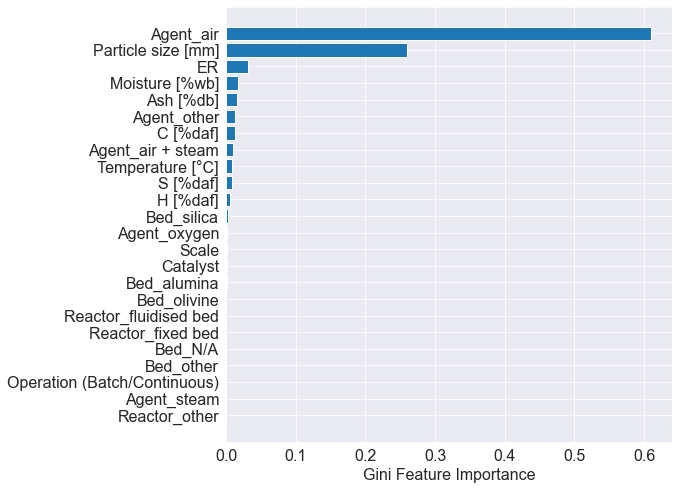

Gini importance of model predicting: H2 [vol.% db]


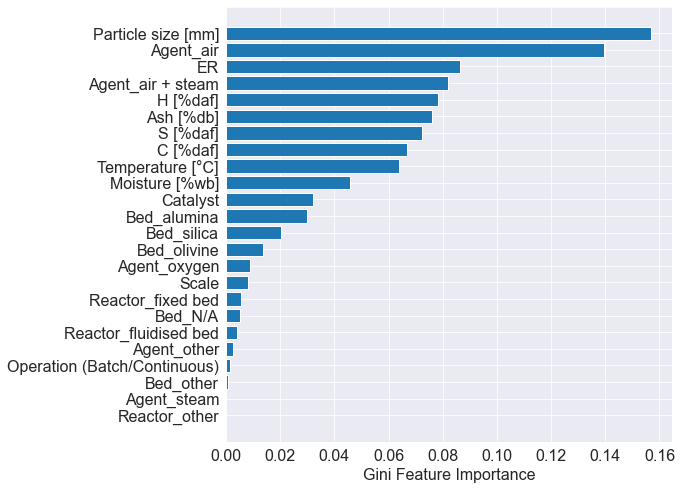

Gini importance of model predicting: CO [vol.% db]


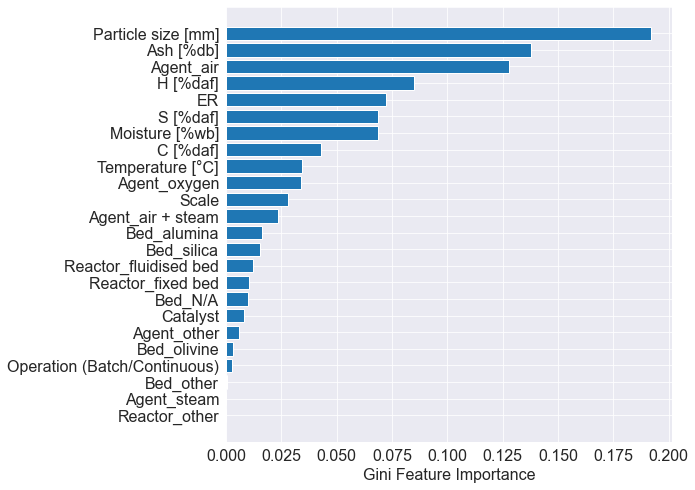

Gini importance of model predicting: CO2 [vol.% db]


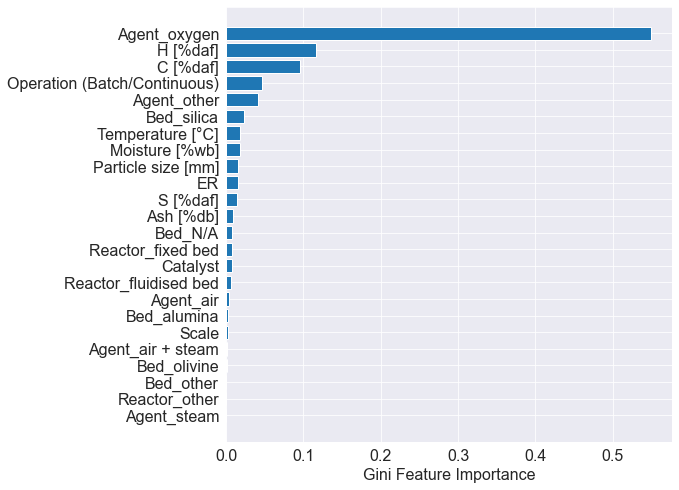

Gini importance of model predicting: CH4 [vol.% db]


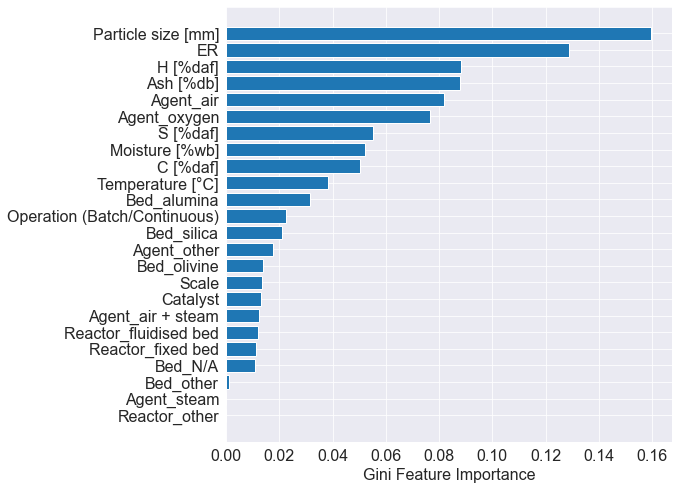

Gini importance of model predicting: C2Hn [vol.% db]


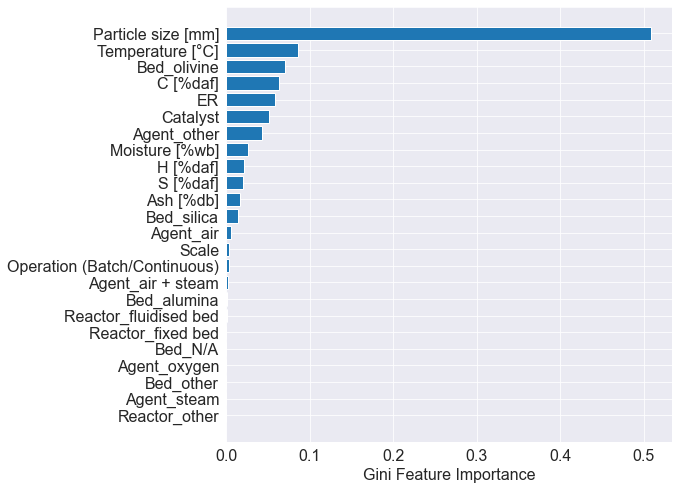

Gini importance of model predicting: LHV [MJ/Nm3]


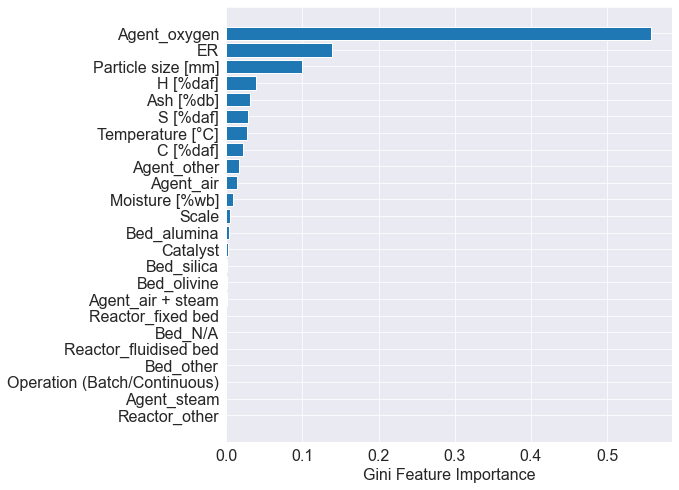

Gini importance of model predicting: Tar [g/Nm3]


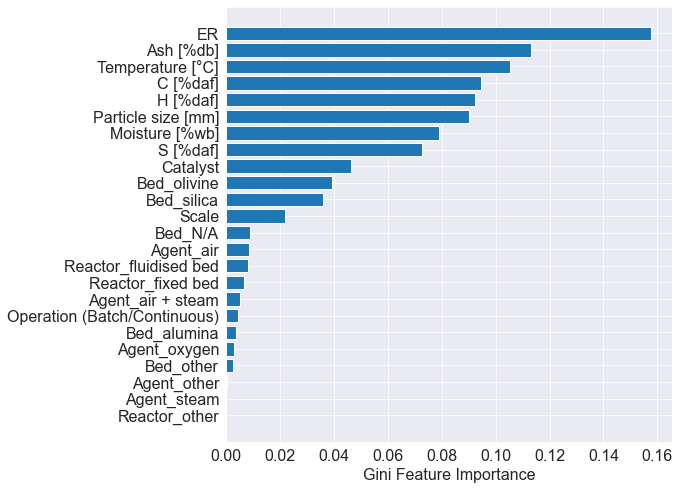

Gini importance of model predicting: Gas yield [Nm3/kg wb]


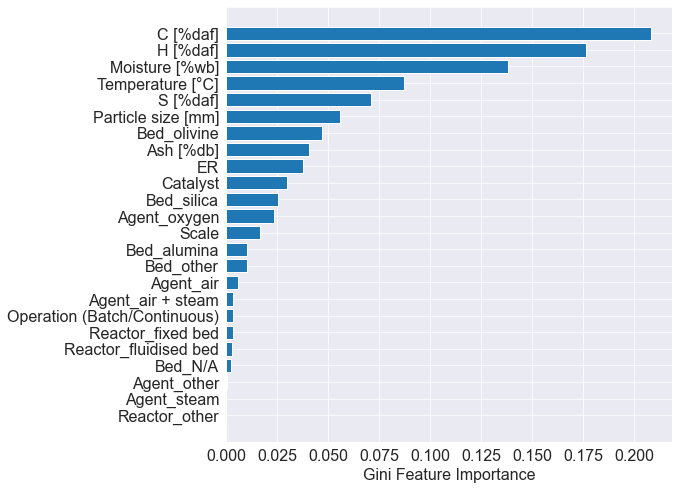

Gini importance of model predicting: Char yield [g/kg wb]


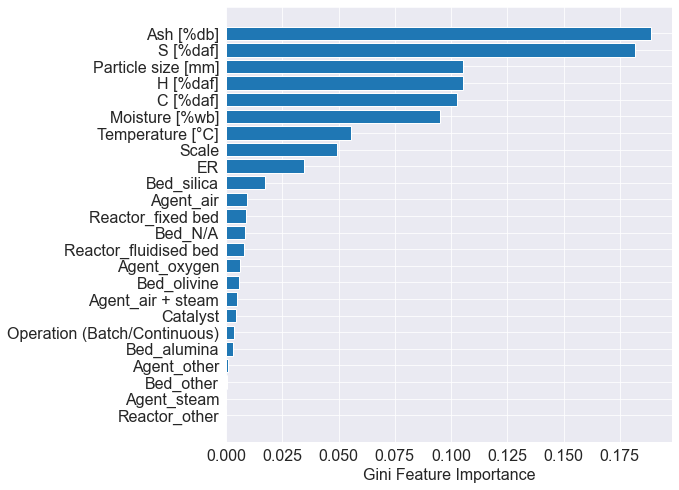

In [69]:
# Gini importance
individual_feat_imp_plot(RF_performance_summary_opt, plottype = 'gini')

Feature permutation importance of model predicting: N2 [vol.% db]


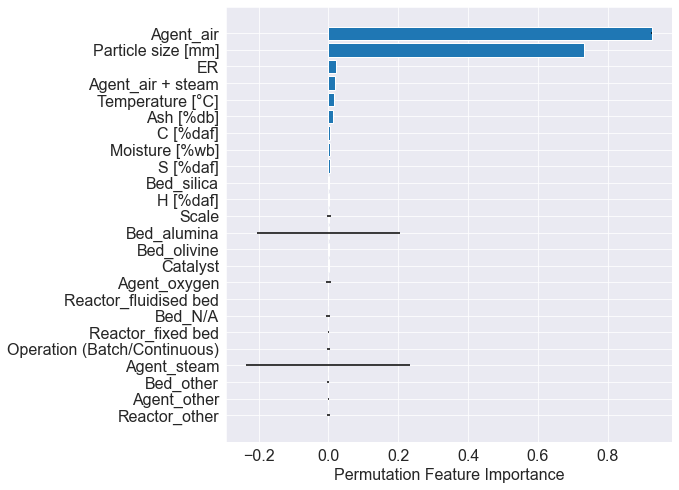

Feature permutation importance of model predicting: H2 [vol.% db]


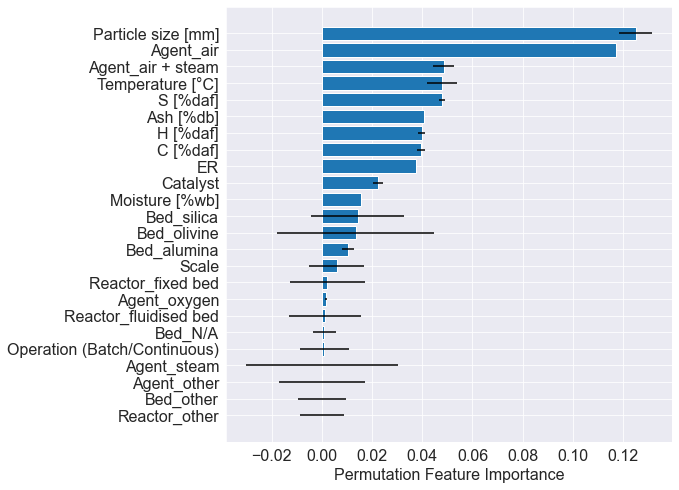

Feature permutation importance of model predicting: CO [vol.% db]


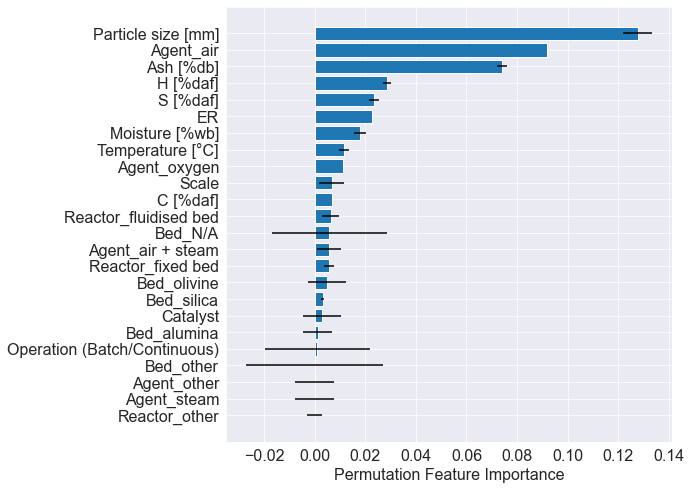

Feature permutation importance of model predicting: CO2 [vol.% db]


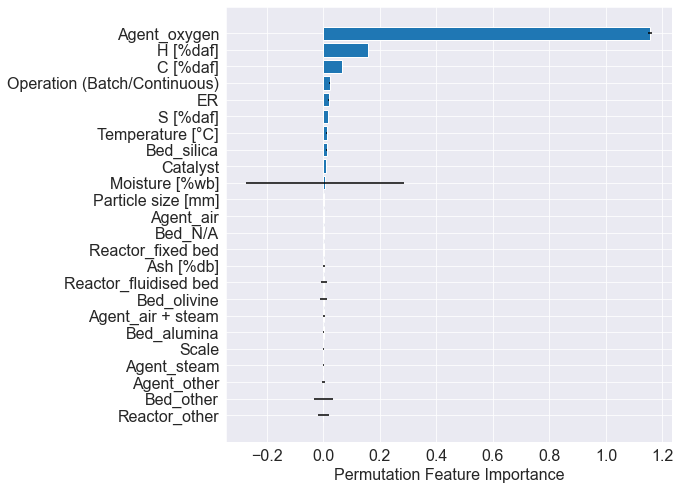

Feature permutation importance of model predicting: CH4 [vol.% db]


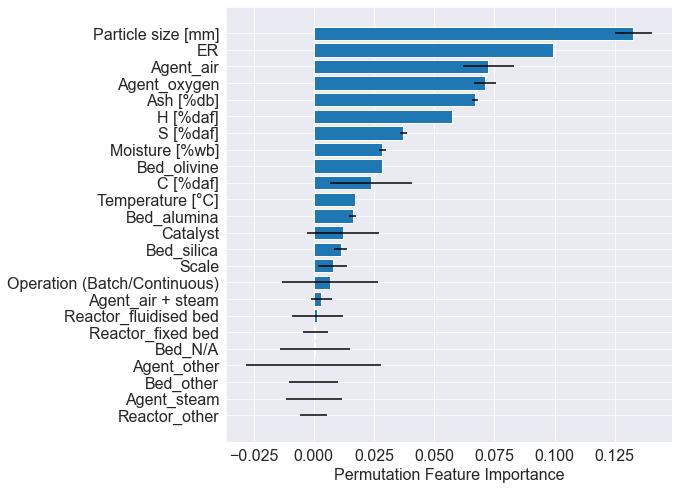

Feature permutation importance of model predicting: C2Hn [vol.% db]


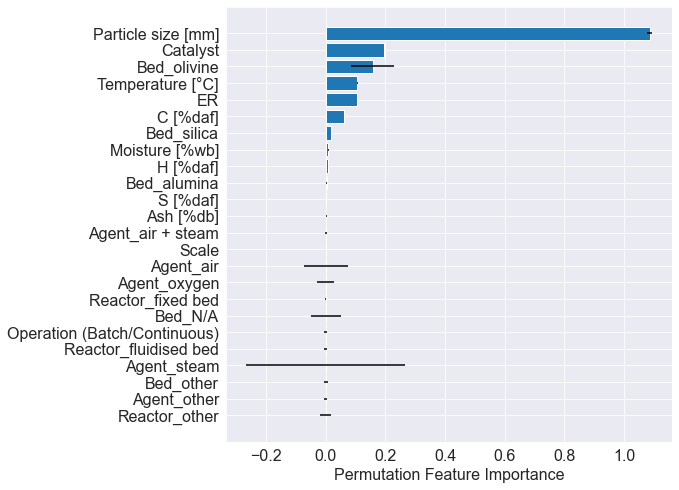

Feature permutation importance of model predicting: LHV [MJ/Nm3]


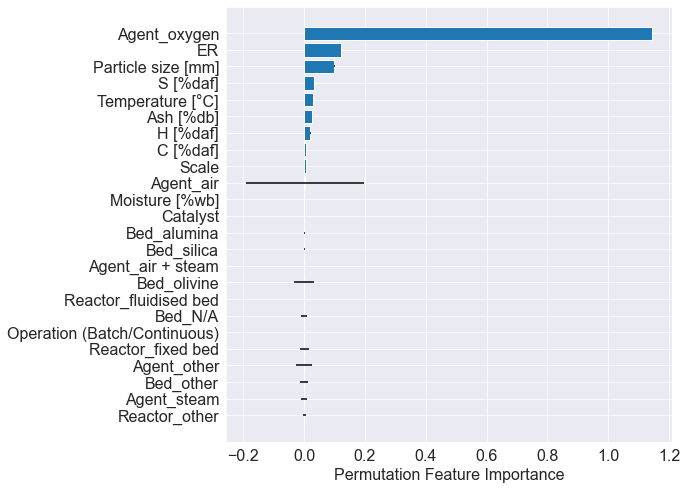

Feature permutation importance of model predicting: Tar [g/Nm3]


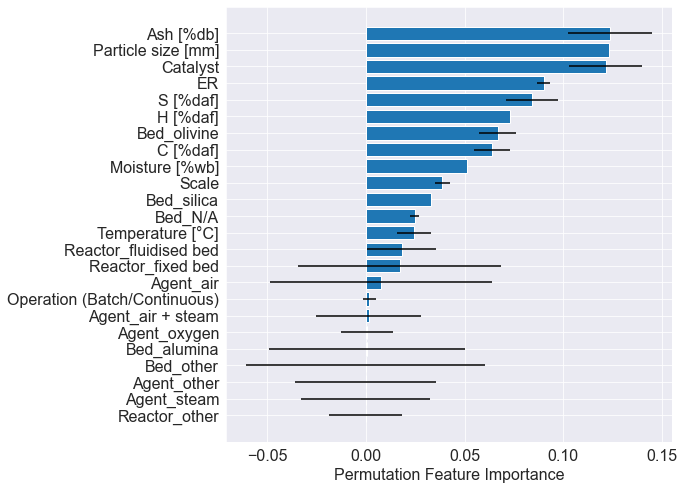

Feature permutation importance of model predicting: Gas yield [Nm3/kg wb]


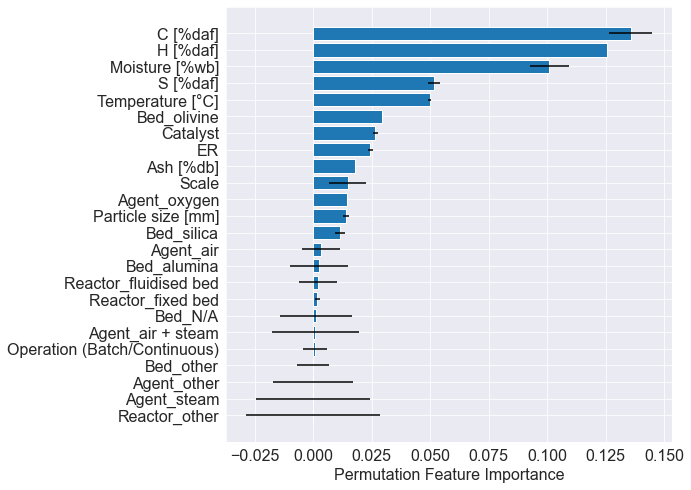

Feature permutation importance of model predicting: Char yield [g/kg wb]


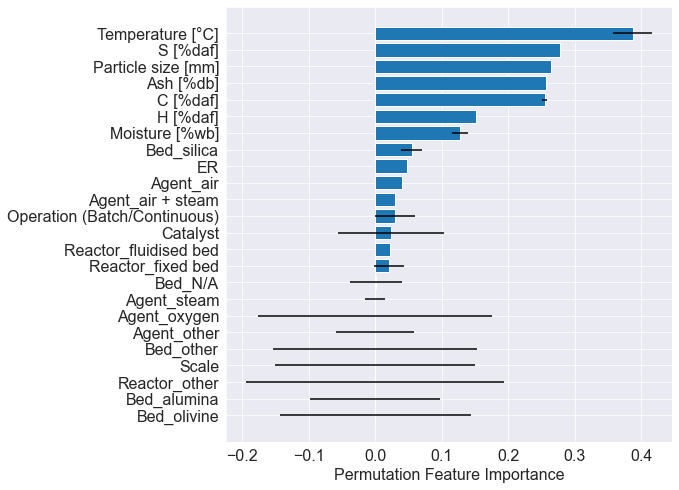

In [70]:
# Permutation importance
individual_feat_imp_plot(RF_performance_summary_opt, plottype = 'perm')

Shap importance of model predicting: N2 [vol.% db]


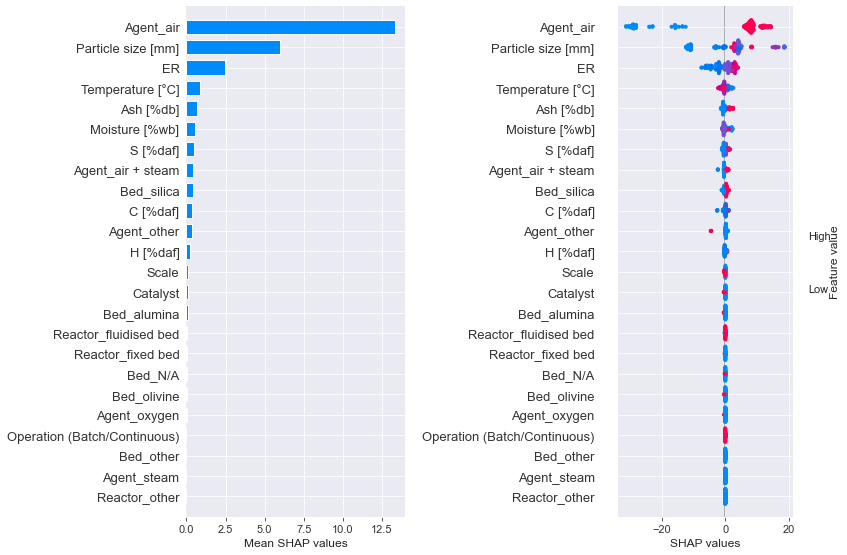

Shap importance of model predicting: H2 [vol.% db]


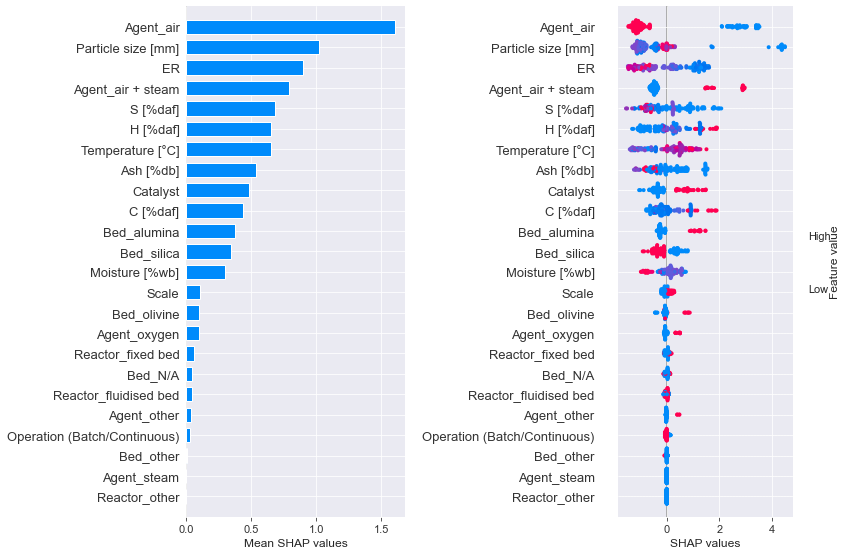

Shap importance of model predicting: CO [vol.% db]


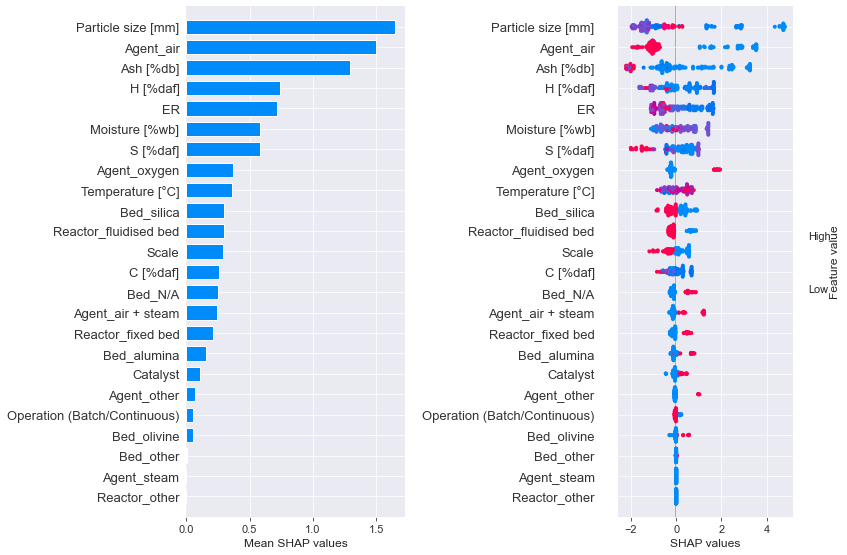

Shap importance of model predicting: CO2 [vol.% db]


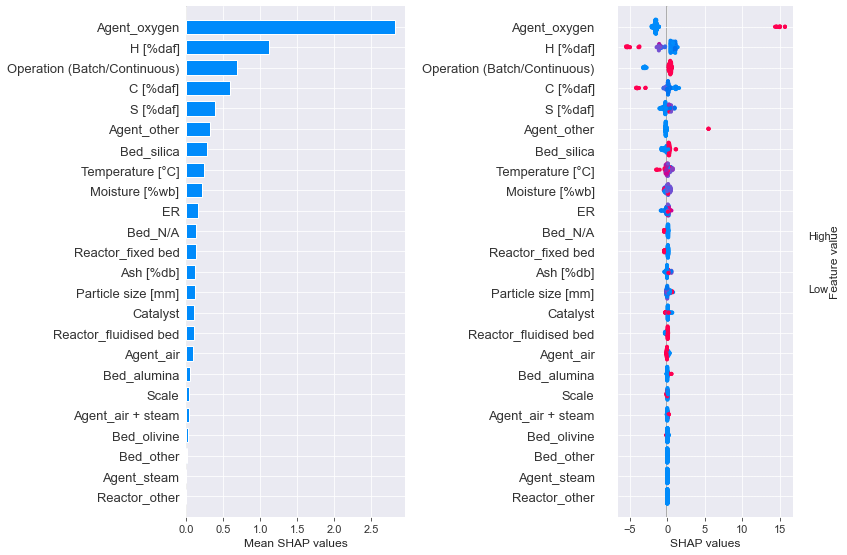

Shap importance of model predicting: CH4 [vol.% db]


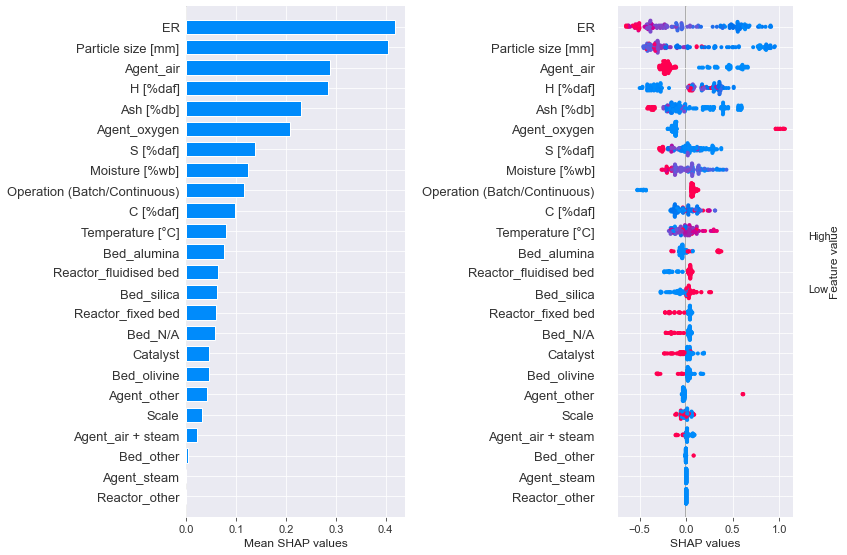

Shap importance of model predicting: C2Hn [vol.% db]


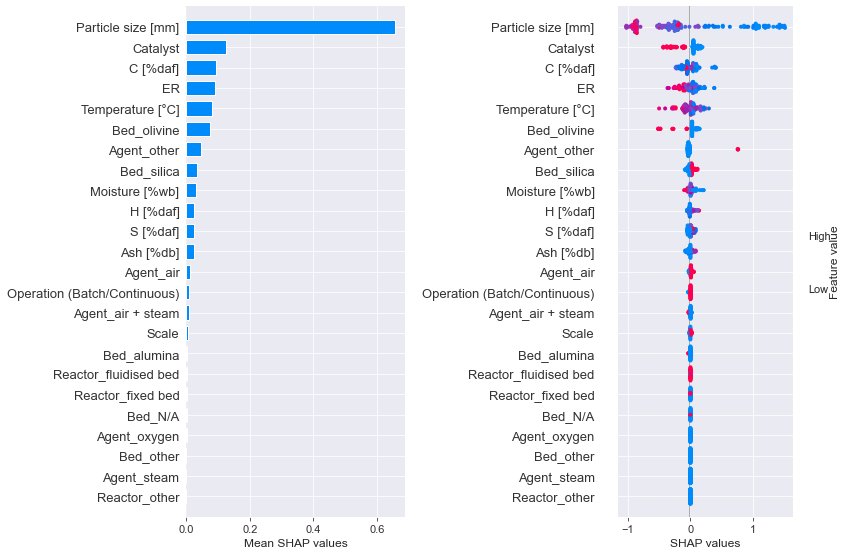

Shap importance of model predicting: LHV [MJ/Nm3]


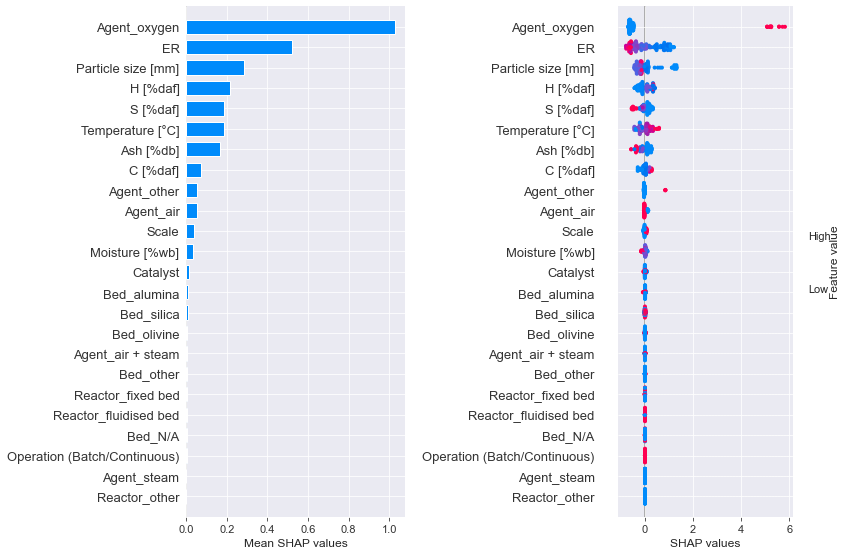

Shap importance of model predicting: Tar [g/Nm3]


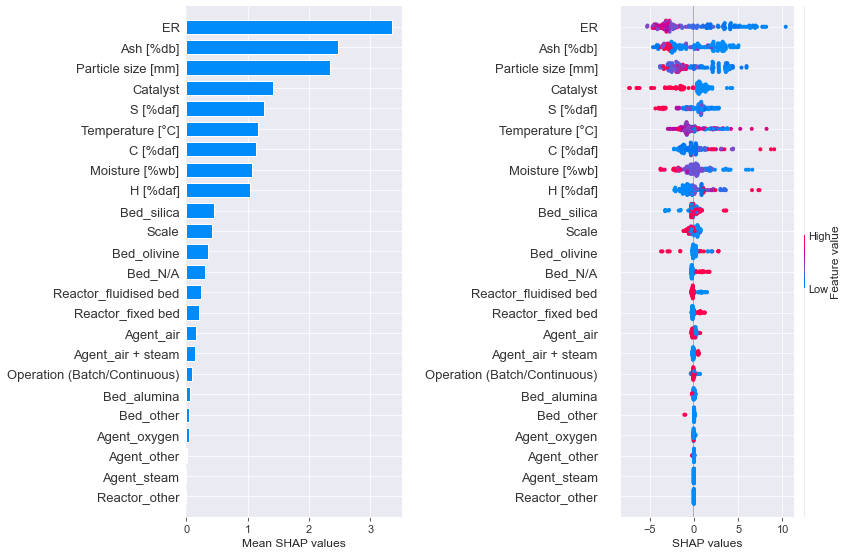

Shap importance of model predicting: Gas yield [Nm3/kg wb]


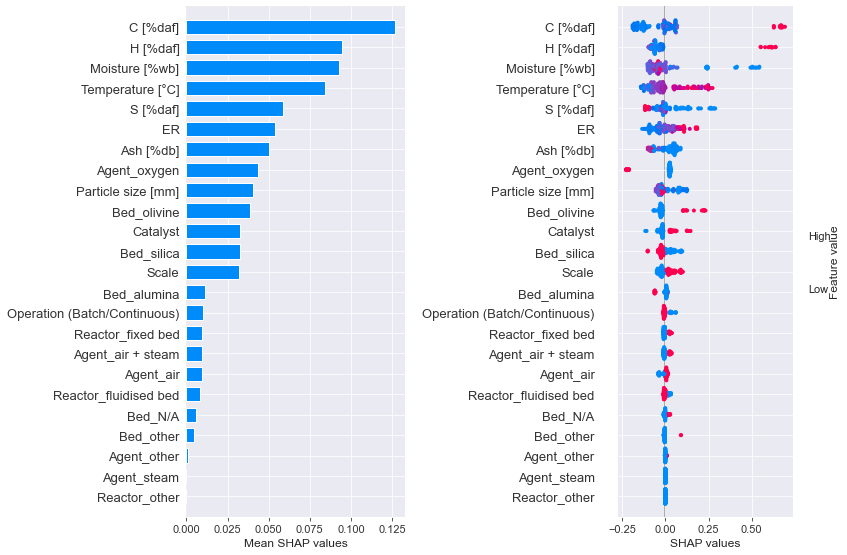

Shap importance of model predicting: Char yield [g/kg wb]


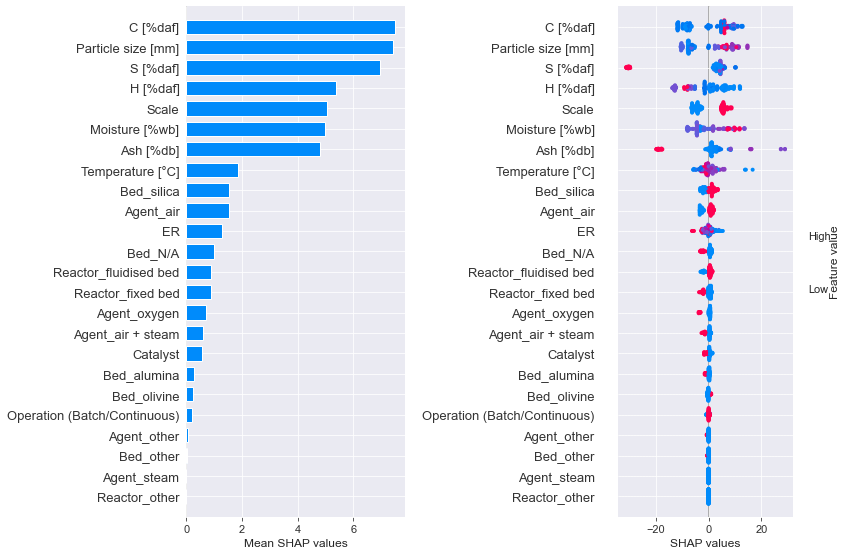

In [71]:
# SHAP importance
individual_feat_imp_plot(RF_performance_summary_opt, plottype = 'shap')

#### 5.2.2) Combined Feature Importance Plots

---

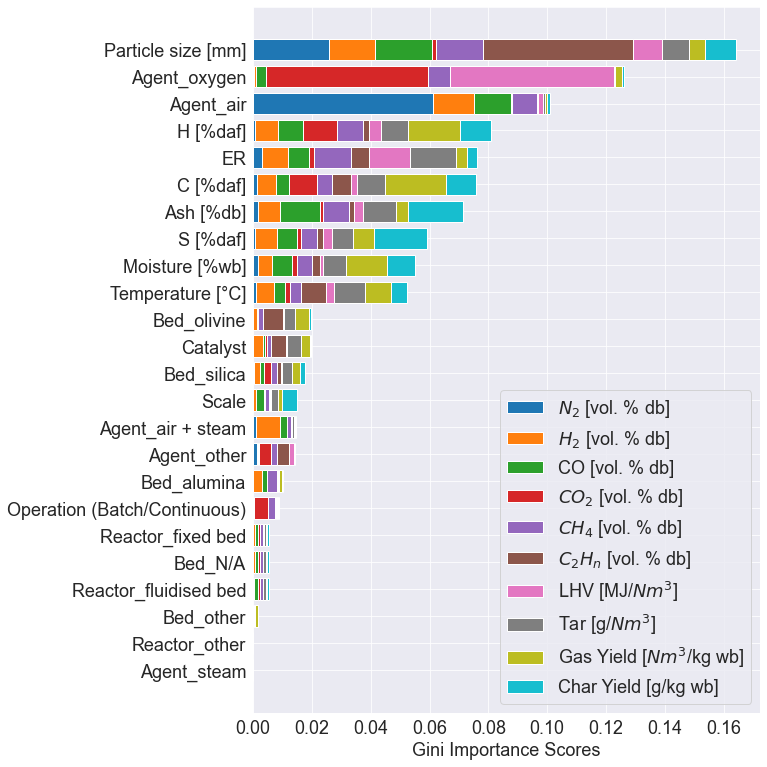

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\2270577A\\PycharmProjects\\Interpretable_Machine_Learning_Gasification\\Figures\\Stacked Feature Importance Graphs\\RF\\gini_stacked_RF.png'

In [72]:
# Gini importance
combined_feat_imp_plot(RF_performance_summary_opt, plottype = 'gini', no_plots = 1, error_bar = True, save = True, save_loc = 'RF')

In [ ]:
# Permutation importance
combined_feat_imp_plot(RF_performance_summary_opt, plottype = 'perm', no_plots = 1, error_bar = True, save = True, save_loc = 'RF')

In [ ]:
# SHAP importance
combined_feat_imp_plot(RF_performance_summary_opt, plottype = 'shap', no_plots = 1, error_bar = True, save = True, save_loc = 'RF')

### 5.3) Sklearn Gradient Boosting Regressor Feature Importance Plots

---

#### 5.3.1) Individual Feature Importance Plots

---

In [ ]:
# Gini importance
individual_feat_imp_plot(GBR_performance_summary_opt, plottype = 'gini')

In [ ]:
# Permutation Importance
individual_feat_imp_plot(GBR_performance_summary_opt, plottype = 'perm')

In [ ]:
# SHAP importance
individual_feat_imp_plot(GBR_performance_summary_opt, plottype = 'shap', save = True, save_loc = 'GBR')

#### 5.3.2) Combined Feature Importance Plots

---

In [ ]:
# Gini importance
combined_feat_imp_plot(GBR_performance_summary_opt, plottype = 'gini', no_plots = 1, error_bar = True, save = True, save_loc = 'GBR')

In [ ]:
# Permutation importance
combined_feat_imp_plot(GBR_performance_summary_opt, plottype = 'perm', no_plots = 1, error_bar = True, save = True, save_loc = 'GBR')

In [ ]:
# SHAP importance
combined_feat_imp_plot(GBR_performance_summary_opt, plottype = 'shap', no_plots = 1, error_bar = True, save = True, save_loc = 'GBR')

### 5.4) XGBoost Feature Importance Plots

---

#### 5.4.1) Individual Feature Importance Plots

---

In [ ]:
# Gini importance
individual_feat_imp_plot(XGBoost_performance_summary_opt, plottype = 'gini')

In [ ]:
# Permutation importance
individual_feat_imp_plot(XGBoost_performance_summary_opt, plottype = 'perm')

In [ ]:
# SHAP importance
individual_feat_imp_plot(XGBoost_performance_summary_opt, plottype = 'shap')

#### 5.4.2) Combined Feature Importance Plots

---

In [ ]:
# Update column names before plotting so they are consistent with other models (e.g. RF and GBR)
XGBoost_performance_summary_opt.loc['x_test'][0].columns = ['C [%daf]', 'H [%daf]', 'S [%daf]', 'Particle size [mm]', 'Ash [%db]',
                                                            'Moisture [%wb]', 'Temperature [°C]', 'Operation (Batch/Continuous)',
                                                            'ER', 'Catalyst', 'Scale', 'agent_air', 'agent_air + steam',
                                                            'agent_other', 'agent_oxygen', 'agent_steam', 'reactor_fixed bed',
                                                            'reactor_fluidised bed', 'reactor_other', 'bed_alumina', 'bed_n/a',
                                                            'bed_olivine', 'bed_other', 'bed_silica'] 

In [ ]:
# Gini importance
combined_feat_imp_plot(XGBoost_performance_summary_opt, plottype = 'gini', no_plots = 1, error_bar = True, save = True, save_loc = 'XGBoost')

In [ ]:
# Permutation importance
combined_feat_imp_plot(XGBoost_performance_summary_opt, plottype = 'perm', no_plots = 1, error_bar = True, save = True, save_loc = 'XGBoost')

In [ ]:
# SHAP importance
combined_feat_imp_plot(XGBoost_performance_summary_opt, plottype = 'shap', no_plots = 1, error_bar = True, save = True, save_loc = 'XGBoost')

### 5.5) AdaBoost Feature Importance Plots

Note: At the time of writing AdaBoost is not supported by the SHAP method. Hence only feature importance by Gini and permutation importance were considered.

---

#### 5.5.1) Individual Feature Importance Plots

---

In [ ]:
# Gini importance
individual_feat_imp_plot(AdaBoost_performance_summary_opt, plottype = 'gini')

In [ ]:
# Permutation importance
individual_feat_imp_plot(AdaBoost_performance_summary_opt, plottype = 'perm')

#### 5.5.2) Combined Feature Importance Plots

---

In [ ]:
# Gini importance
combined_feat_imp_plot(AdaBoost_performance_summary_opt, plottype = 'gini', no_plots = 1, error_bar = True,  save = True, save_loc = 'AdaBoost')

In [ ]:
# Permutation importance
combined_feat_imp_plot(AdaBoost_performance_summary_opt, plottype = 'perm', no_plots = 1, error_bar = True, save = True, save_loc = 'AdaBoost')

### 5.6) SHAP explanations of invdividual predictions
This section illustrates how the SHAP method can be used to explain how a model makes a particular prediciton.<br>

---

#### 5.6.1) Example 1: Barley Straw

---

In [ ]:
# Create data frame with new data for Barley Straw
barley_test_data_array = [[49.09, 6.06, 0.08, 4, 5.88, 11.53, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # base case
                       [49.09, 6.06, 0.08, 4, 5.88, 11.53, 800, 1, 0.3, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], # steam
                       [49.09, 6.06, 0.08, 1, 5.88, 11.53, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # low particle size
                       [49.09, 6.06, 0.08, 20, 5.88, 11.53, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # high particle size                    
                       [49.09, 6.06, 0.08, 4, 5.88, 11.53, 600, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # low temperature                    
                       [49.09, 6.06, 0.08, 4, 5.88, 11.53, 1000, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # high temperature
                       [49.09, 6.06, 0.08, 4, 5.88, 20.00, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # high moisture
                      ]
barley_test_df = pd.DataFrame(data = barley_test_data_array, index = ['Base', 'Steam', 'Low Particle Size','High Particle Size','Low Temperature', 'High Temperature', 'High Moisture'], columns = GBR_performance_summary_opt.loc['x_train']['N2 [vol.% db]'].columns)

# All data taken from https://phyllis.nl/Biomass/View/3169 - other data is listed below - design choices for base case:
# particle size = 4 mm
# temperature = 800 deg C 
# Operation = Continuous
# ER = 0.3
# Catalyst = None
# Scale = Pilot
# agent = air
# bed = fluidesed bed 
# bed material = silica   
                    

In [ ]:
# Plot SHAP force plots for Gas yield [Nm3/kg wb]
Individual_Shap_Plots(barley_test_df, target_name = 'Gas yield [Nm3/kg wb]', save = True, save_type = 'barley')

In [ ]:
# Plot SHAP force plots for LHV [MJ/Nm3]
Individual_Shap_Plots(barley_test_df, target_name = 'LHV [MJ/Nm3]', save = True, save_type = 'barley')

#### 5.6.2) Example 2: MSW

---

In [ ]:
GBR_performance_summary_opt.loc['x_train']['N2 [vol.% db]'].columns

In [ ]:
# Create data frame with new data for MSW
MSW_test_data_array = [[59.19, 9.80, 0.29, 4, 16.82, 6.16, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # base case
                       [59.19, 9.80, 0.29, 1, 16.82, 6.16, 800, 1, 0.3, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1], # steam
                       [59.19, 9.80, 0.29, 1, 16.82, 6.16, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # low particle size
                       [59.19, 9.80, 0.29, 20, 16.82, 6.16, 800, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # high particle size                    
                       [59.19, 9.80, 0.29, 4, 16.82, 6.16, 600, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # low temperature                    
                       [59.19, 9.80, 0.29, 4, 16.82, 6.16, 1000, 1, 0.3, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1], # high temperature
                       [59.19, 9.80, 0.29, 4, 16.82, 6.16, 800, 1, 0.3, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0], # batch and downdraft and steam
                      ]
MSW_test_df = pd.DataFrame(data = MSW_test_data_array, index = ['Base', 'Steam', 'Low Particle Size','High Particle Size','Low Temperature', 'High Temperature', 'Batch, Downdraft, and Steam'], columns = GBR_performance_summary_opt.loc['x_train']['N2 [vol.% db]'].columns)

# All data taken from https://phyllis.nl/Biomass/View/2920 - other data is listed below - design choices for base case:
# particle size = 4 mm
# temperature = 800 deg C 
# Operation = Continuous
# ER = 0.3
# Catalyst = None
# Scale = Pilot
# agent = air
# bed = fluidesed bed 
# bed material = silica   

In [ ]:
# Plot SHAP force plots for Gas yield [Nm3/kg wb]
Individual_Shap_Plots(MSW_test_df, target_name = 'Gas yield [Nm3/kg wb]', save = True, save_type = 'MSW')

In [ ]:
# Plot SHAP force plots for LHV [MJ/Nm3]
Individual_Shap_Plots(MSW_test_df, target_name = 'LHV [MJ/Nm3]', save = True, save_type = 'MSW')

### 5.7) Summary & Conclusions

---

In general, it was found that all studied model types agreed well with each other.<br>
The particle size, gasifying agent (oxygen or air) were found to be key predictors for all models.<br>
Other factors such as the gasifcation temperature, the equivalence ratio (ER), and the feedstock's ash content were also important predictors for the models.<br>
When studying the individual feature importance graphs it can be seen that different predictors were found to be important for different model outputs. So whilst some predictors were found to be important for a particular output, they were not necessarily found to be important for another output. Studying the combined feature importance graphs allows us to see more general trends on which predictors are important when trying to model all outputs.<br>
Feature importance assessment by Gini, permuation importance, and Shap method all resulted in comparable results and showed similar trends.<br>
A more detailed discussion and comments are available in the accompanying paper.<br>
